In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from scipy.optimize import minimize
from scipy.integrate import odeint
from tqdm import tqdm
from scipy.sparse import csr_matrix
from joblib import Parallel, delayed
from scipy.optimize import basinhopping
import sys
from scipy.optimize import differential_evolution
from scipy.optimize import dual_annealing

In [2]:
def expand_array(short_array):
    long_array = np.zeros(6084)  # Create a zero array of the desired size

    # Assign values at the correct positions
    long_array[np.arange(78) * (78 + 1)] = short_array
    return long_array

def expand_timeseries(short_timeseries):
    
    transposed = short_timeseries.T
    
    long_timeseries = np.zeros((day_range,6084))
    for i in range(day_range):
        long_timeseries[i] = expand_array(transposed[i])
        
    long_timeseries = np.array(long_timeseries)
    
    return long_timeseries


def compress_timeseries(long_timeseries):
    compressed = np.zeros((day_range, 78))  # Adjusted to match the original short array shape
    
    for i in range(day_range):
        compressed[i] = compress_array(long_timeseries[i])
        
    return compressed.T  # Transpose back to match original input shape

def compress_array(long_array):
    return long_array[np.arange(78) * (78 + 1)]  # Extract values from the expanded positions


def expand_betas(short_betas,long_length):
    
    long_betas = np.zeros(long_length)
    index = 0
    for i in valid_patch_indices:
        long_betas[i] = short_betas[index]
        index += 1
    
    return long_betas



with open("BA_Patch_Population_Map_1km.pkl", "rb") as file:
    pop_dict = pickle.load(file)
    
# Assuming pop_dict is a pandas DataFrame
pop_dict = dict(zip(pop_dict['estacion'], pop_dict['population']))
pop_dict = dict(sorted(pop_dict.items()))

# Extract values in order
short_pop_vector = np.array(list(pop_dict.values()))

pop_vector = expand_array(short_pop_vector)
    
borough_list = np.array(range(15))+1
    
with open("ba_big station list.pkl", "rb") as file:
    station_list = pickle.load(file)
    
with open("station_comuna_dict.pkl", 'rb') as f:
    station_comuna_dict = pickle.load(f)
    
station_borough_list = list(station_comuna_dict.values())
    
with open("BA Station Comuna Proportions Dict.pkl", 'rb') as f:
    props_dict = pickle.load(f)
    
with open("BA_Covid_Data.pkl", 'rb') as f:
    covid_df = pickle.load(f)
    
import pandas as pd
import matplotlib.pyplot as plt

# Ensure datetime and sort
covid_df['date'] = pd.to_datetime(covid_df['date'])
covid_df = covid_df.sort_values(['comuna', 'date'])

# Filter out comunas 8–11
df_filtered = covid_df[~covid_df['comuna'].isin([8, 9, 10, 11])]

# Create full MultiIndex for relevant comunas and dates
all_dates = pd.date_range('2020-01-01', '2020-05-31')
comunas = df_filtered['comuna'].unique()
multi_index = pd.MultiIndex.from_product([comunas, all_dates], names=['comuna', 'date'])

# Reindex and interpolate daily_cases
df_full = df_filtered.set_index(['comuna', 'date']).reindex(multi_index)
df_full['daily_cases'] = df_full['daily_cases'].interpolate(limit_direction='both')

# Identify missing comuna on April 23
existing_comunas = df_filtered[df_filtered['date'] == '2020-04-23']['comuna'].unique()
interpolated_apr23 = df_full.loc[pd.IndexSlice[:, '2020-04-23'], 'daily_cases']
missing_comuna = list(set(interpolated_apr23.index.get_level_values(0)) - set(existing_comunas))[0]
value = float(interpolated_apr23.loc[missing_comuna])  # proper scalar

# Estimate total_cases using previous day's value
prev_total = covid_df[
    (covid_df['comuna'] == missing_comuna) &
    (covid_df['date'] == pd.Timestamp('2020-04-22'))
]['total_cases'].values[0]
estimated_total = prev_total + value

# Create and insert new row
new_row = {
    'date': pd.Timestamp('2020-04-23'),
    'comuna': missing_comuna,
    'daily_cases': value,
    'total_cases': estimated_total
}
covid_df = pd.concat([covid_df, pd.DataFrame([new_row])], ignore_index=True)
covid_df = covid_df.sort_values(['comuna', 'date']).reset_index(drop=True)

# --- Recalculate total_cases from April 2 onward for comuna 6.0 ---

# Isolate comuna 6.0 from April 2 on
comuna_df = covid_df[
    (covid_df['comuna'] == 6.0) &
    (covid_df['date'] >= '2020-04-02')
].sort_values('date').copy()

# Get first known total_cases to anchor cumulative sum
anchor_total = comuna_df.iloc[0]['total_cases']

# Compute cumulative daily cases
comuna_df['cumulative_daily'] = comuna_df['daily_cases'].cumsum()
comuna_df['adjusted_total'] = anchor_total + (comuna_df['cumulative_daily'] - comuna_df.iloc[0]['cumulative_daily'])

# Update total_cases in original covid_df
covid_df.loc[
    (covid_df['comuna'] == 6.0) & (covid_df['date'] >= '2020-04-02'),
    'total_cases'
] = comuna_df['adjusted_total'].values

    
with open("ba_all_paths.pkl", 'rb') as f:
    all_paths = pickle.load(f)
    
# with open("Final Commuter Matrix Buenos Aires.pkl", "rb") as file:
    # commuter_array = pickle.load(file)
    
    
################################################################################################
################################################################################################
################################################################################################
################################################################################################

def get_timeseries(station_name,covid_df,props_dict):
    
    current_borough = props_dict[station_name][0]
    
    # Filter data for the given area_name "Lambeth" and within the maximum date range
    filtered_df = covid_df[
        (covid_df['date'] <= "2020-08-07") & 
        (covid_df['comuna'] == current_borough)
    ]

    # Find the earliest date where total_cases is nonzero
    # earliest_nonzero_date = filtered_df.loc[filtered_df['total_cases'] > 0, 'date'].min()
    earliest_nonzero_date = "2020-07-23"

    # Filter again using the adjusted start date
    filtered_df = filtered_df[
        (filtered_df['date'] >= earliest_nonzero_date) & 
        (filtered_df['date'] <= "2020-08-07")
    ]
    
    borough_timeseries = np.array(list(filtered_df['total_cases']))
    
    station_timeseries = props_dict[station_name][1]*borough_timeseries
    
    
    return station_timeseries

def get_timeseries_with_five(station_name, covid_df, props_dict):
    current_borough = props_dict[station_name][0]

    # Define the start and end dates
    end_date = "2020-11-30"
    earliest_nonzero_date = "2020-04-05"
    five_days_before = "2020-04-02"  # 5 days before the earliest nonzero date

    # Filter data for the given borough within the maximum date range
    filtered_df = covid_df[
        (covid_df['date'] >= earliest_nonzero_date) & 
        (covid_df['date'] <= end_date) & 
        (covid_df['comuna'] == current_borough)
    ]
    
    borough_timeseries = np.array(filtered_df['total_cases'])
    station_timeseries = props_dict[station_name][1] * borough_timeseries

    # Get new cases in the 5 days before the earliest nonzero date
    previous_df = covid_df[
        (covid_df['date'] >= five_days_before) & 
        (covid_df['date'] < earliest_nonzero_date) & 
        (covid_df['comuna'] == current_borough)
    ]
    
    total_new_cases_prev_5_days = props_dict[station_name][1]*previous_df['daily_cases'].sum()

    return station_timeseries, total_new_cases_prev_5_days


################################################################################################
################################################################################################
################################################################################################
################################################################################################

all_station_timeseries = []
all_new_cases_prev_5_days = []
for i in range(len(station_list)):
    timeseries = get_timeseries_with_five(station_list[i],covid_df,props_dict)
    all_station_timeseries.append(timeseries[0])
    all_new_cases_prev_5_days.append(timeseries[1])
    
    
all_station_timeseries = np.array(all_station_timeseries)
day_range = all_station_timeseries[0].shape[0]
print(day_range)

working_timeseries = expand_timeseries(all_station_timeseries)
short_pop_vector = np.array(list(pop_dict.values()))
pop_vector = expand_array(short_pop_vector)
day_list = np.arange(day_range)
data = np.column_stack((day_list[:, None], working_timeseries))


current_cases = np.array(all_new_cases_prev_5_days)
cum_cases = data[0][1:]

# Define main control panel functions

# with open("London new Nj.pkl", "rb") as file:
    # Nj = pickle.load(file)
    
with open("Buenos Aires Home Patches.pkl", "rb") as file:
    home_patches = pickle.load(file)
    
# Load files
with open("Sparse Buenos Aires P-Matrix.pkl", "rb") as file:
    sparse_p = pickle.load(file)
    
with open("Fixed Sparse Buenos Aires P-Matrix.pkl","rb") as file:
    fixed_sparse_p = pickle.load(file)

p_matrix = sparse_p.toarray()
fixed_p_matrix = fixed_sparse_p.toarray()
Nj = pop_vector @ p_matrix

Nj_safe = Nj.copy()
Nj_safe[Nj_safe == 0] = 1
Nj = Nj_safe.copy()

with open("Buenos Aires Valid Patches.pkl", 'rb') as f:
    valid_patches = pickle.load(f)
    
with open("Buenos Aires Valid Patch Indices.pkl", 'rb') as f:
    valid_patch_indices = pickle.load(f)

np.set_printoptions(suppress=True)

travel_patches = []
for i in valid_patch_indices:
    if i not in home_patches:
        travel_patches.append(i)

current_cases,cum_cases


np.set_printoptions(suppress=True)


pairs_list = []
for i in range(len(station_list)):
    for j in range(len(station_list)):
        pairs_list.append((station_list[i],station_list[j]))
pairs_list = np.array(pairs_list)

with open("Sparse Buenos Aires Expanded P Matrix.pkl", 'rb') as file:
    sparse_expanded_p_matrix = pickle.load(file)

expanded_p_matrix = sparse_expanded_p_matrix.toarray()




/tmp/ipykernel_2272608/875967833.py:96: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  value = float(interpolated_apr23.loc[missing_comuna])  # proper scalar


240


In [3]:
with open("Normed Distributed Updated Formalized Buenos Aires Beta.pkl", "rb") as file:
    best_beta_yet_0 = pickle.load(file)
    
home_betas = best_beta_yet_0[:78]
home_betas.shape

(78,)

In [5]:
N = pop_vector.copy()
gamma = 1/5

def calc_F_for_idx(i):
    F = 0
    
    for k in range(78):
        p_k = home_patches[k]
        denom = 0
        for l in range(78):
            p_l = home_patches[l]
            denom += p_matrix[p_l][p_k]
        F += home_betas[k]*p_matrix[i][p_k]*p_matrix[i][p_k]/denom
    
    return F

calc_F_for_idx(0)

np.float64(0.06096812792326751)

In [54]:
num_infected_16_days = solution[1][home_patches].T[15].T
num_infected_16_days.shape

(78,)

In [6]:
patch_R0s = []
for i in range(78):
    patch_R0s.append(calc_F_for_idx(home_patches[i])/gamma)
patch_R0s = np.array(patch_R0s)
patch_R0s

array([0.30484064, 0.67269841, 0.71669321, 0.71397636, 0.63867369,
       0.57533484, 0.90432912, 0.84806593, 0.78970077, 0.70296743,
       0.69106927, 0.47221471, 0.78574332, 0.54304126, 1.07412655,
       0.73795365, 0.8170694 , 0.24260265, 0.56599077, 0.60679328,
       0.21233274, 0.81577851, 0.46947525, 0.8718967 , 0.85753064,
       1.11413002, 0.89335147, 0.75760229, 0.51044519, 0.85885805,
       0.46259637, 0.57931811, 0.83765751, 0.75983867, 0.94813373,
       1.08960965, 0.54142562, 0.8625811 , 0.76833619, 0.82168754,
       0.65500244, 0.71608209, 0.80247873, 0.74303645, 0.42482485,
       0.72066866, 0.70739242, 0.93864764, 0.60936545, 0.78862207,
       0.70405014, 0.70818829, 0.54535453, 1.00997676, 0.76462948,
       0.59577958, 0.77370393, 0.7592592 , 0.79236232, 0.58930394,
       0.64227454, 0.3250127 , 0.61620649, 0.73639542, 0.34184835,
       0.68495228, 0.74802247, 0.85415524, 0.73683084, 0.83150604,
       0.52551068, 0.52309547, 0.67710373, 0.64787974, 0.96033

In [38]:
# 100 MOST POPULOUS
num_indices = 100

indices = np.argpartition(short_pop_vector, -num_indices)[-num_indices:]
indices = indices[np.argsort(short_pop_vector[indices])[::-1]]
indices

array([ 59, 221, 225,  28, 181,  19,  34, 217, 124,  12,  18, 153, 129,
       106,  45,  97,  91, 164, 210, 193, 140,   5, 109,  33, 125,  60,
        35,   4,  25, 201,  76,  43, 243,  52, 244, 248,  47, 137,  94,
       147, 202,  58,  21, 220, 159, 133,  95,  16,  74, 155,   9, 204,
       104, 209,   7, 168,  62,  48,  30, 240,  26, 139, 162, 194, 246,
         6, 174,  98,  75, 212, 114,  72, 167, 110,  66,  54,  53,  17,
        27, 249, 146,  57,  44,  31,  78, 215, 192, 113, 171, 187, 184,
       247, 231, 188,  29, 105, 115, 117, 236, 216])

In [296]:
# 100 MOST INFECTIOUS

num_indices = 100

indices = np.argpartition(num_infected_16_days, -num_indices)[-num_indices:]
indices = indices[np.argsort(num_infected_16_days[indices])[::-1]]
indices

array([ 28,  18, 109,  33,  59, 181,  45, 210,  19, 221, 225, 193,  34,
       129,  60, 217,  43, 153,  97, 137, 202, 240, 155,   5, 159, 162,
         9,  48,  91, 184, 209,   4, 188, 246, 106, 124, 244,  25,  75,
        74, 248,  47,  94,  44, 243, 201,  58,  12, 164,  95, 247, 147,
         7,  57, 119, 168, 133,  17,  62, 139,  30, 125,  35,  23, 140,
        65,  77, 114,  56, 167,  26,  98, 110, 104, 212,  72,  53, 236,
        31,  14, 215, 166, 194,  54, 238,  27, 174,   6,  21, 191,  78,
       204, 111,  76,  96, 231, 128, 146, 115,  52])

In [88]:
# 100 BIGGEST Betas

num_indices = 100

indices = np.argpartition(home_betas, -num_indices)[-num_indices:]
indices = indices[np.argsort(home_betas[indices])[::-1]]
indices

array([ 91, 187, 127, 171, 144,  37, 237, 163, 200, 195, 223,  28,  92,
        65, 168, 139, 244, 110,  53, 229, 167, 115, 202, 114, 117,  90,
       203, 145,  43, 155, 112, 206, 231, 230, 120,  44, 189,   3, 165,
       245, 193,  60,  45, 209, 210,  33,  18, 148,   9,  23, 109, 129,
       118, 188, 224, 157, 246,   8, 137, 196, 131,  39,  48, 132,  22,
        11,  82,  49, 211, 191,   7,  56, 126, 156, 169, 247, 107, 121,
        83, 123, 161, 208,   1, 130, 136,  20, 241,  64, 198, 215,  40,
        36,  67,  10, 173, 162, 151,   5, 197,  97])

In [10]:
# Get betas > 0.5

# Get indices where beta > 0.6
indices = np.where(home_betas > 0.3)[0]

# Sort indices by descending beta values
indices = indices[np.argsort(home_betas[indices])[::-1]]

# Result
print(indices,"\n\n",indices.size,"in total")


[39 53 25 34 14 35 19 41 37] 

 9 in total


In [47]:
# 100 BIGGEST R0s

num_indices = 100

indices = np.argpartition(patch_R0s, -num_indices)[-num_indices:]
indices = indices[np.argsort(patch_R0s[indices])[::-1]]
indices

array([237, 120, 144, 155,  44, 187, 189,  43, 110,  37, 145, 202, 206,
       163,  53, 115, 112, 139, 203,  90, 109,  23, 165,   3, 200, 171,
       247, 168, 117, 245,  60, 193, 191,  91,   7, 173, 176, 167, 148,
        18,  48, 230, 209, 128, 175, 142, 107,  63, 215, 240,  45,  98,
       220, 223,  33, 228, 134,  79,  41,  81,  15,  51, 234, 137, 114,
       138, 232,  25,  28,  88, 195,  70, 121,  16, 199, 170,  13,  36,
        27, 183, 169, 244, 213, 235,  38,  31, 130, 250, 205, 160, 158,
        57,  24,  17,  42,  64, 172, 217, 185, 226])

In [24]:
# 100 SMALLEST R0s

num_indices = 50

indices = np.argpartition(patch_R0s, num_indices)[:num_indices]
indices = indices[np.argsort(patch_R0s[indices])]
indices

array([156, 224,  34, 126, 116,  10, 127, 129, 157, 222,  83,  87, 214,
       161,  54, 229, 204, 123, 211,  68, 100, 136,   8,  71,  74, 133,
       174,  19, 216, 241, 188,  85, 243, 153, 182,   2,  93,  12, 218,
        40, 105, 227, 231,   4, 198,  61,  67, 225,  39, 149])

In [65]:
cvr = np.array([  0.37541681,   1.89941788,   0.43646397,   0.18299401,
         0.29606019,   0.22222949,   0.77549501,   0.1924569 ,
         1.12079838,   0.47066279, 101.42523556,   0.53326196,
         0.27610548,   0.26246447,   0.26773801,   0.33101228,
         0.22877043,   0.27117427,   0.41103049,   0.28631812,
         3.10474716,   0.32225747,   1.16821027,   0.43416594,
         0.32493835,   0.25863683,   0.28738821,   0.22180516,
         0.41213962,   0.25460087,   0.23263136,   0.23132471,
         0.48013688,   0.42573476,   0.51868428,   0.27487277,
         7.51145869,   0.2801635 ,   0.28122034,   1.06929372,
         7.43710391,   0.25799322,   0.34229115,   0.39098785,
         0.39495872,   0.40733198,   0.75666778,   0.23894593,
         0.32687471,   1.15816353,   0.35292542,   0.23653997,
         0.24417536,   0.17342009,   0.49589756,   0.43496231,
         0.45725491,   0.22074866,   0.26190731,   0.23022554,
         0.39527212,   0.43916323,   0.23453229,   0.2884342 ,
         0.42995271,   0.56747547,   0.7018135 ,  14.58638007,
         1.40788765,   1.7646171 ,   0.26525477,   1.18643024,
         0.25955052,   0.41916122,   0.37725203,   0.26941467,
         0.28058   ,   0.35711469,   0.29508569,   0.21432935,
         0.58591868,   0.24510595,   0.61211062,   5.13772285,
         0.36053348,   0.61270868,   0.30385653,   0.72324628,
         0.28065351,   0.40222304,   0.17514682,   0.25860312,
         0.45336183,   0.53135527,   0.24881079,   0.21906477,
         0.40064011,   0.26990654,   0.26139814,   0.40403608,
         2.15179697,   0.29055797,   0.26012783,   0.74656132,
         0.42110407,   0.4774294 ,   0.3788    ,   0.95995093,
         0.48181676,   0.39775384,   0.16464064,   0.30142119,
         0.1691262 ,   0.74764878,   0.21051422,   0.17926494,
         1.15159264,   0.19132311,   0.74902003,   0.28191619,
         0.41160025,   0.54742906,   0.26729077,   4.67893364,
         0.31857483,   0.32183182,   6.49594353,   1.70158738,
         0.24235552,   1.45833691,   2.21473735,   0.73530505,
         0.44202318,   0.35307219,   0.22357834,   0.54200311,
         5.80023289,   0.3311054 ,   0.28592217,   0.17259992,
         0.25842569,   0.47544299,   0.344979  ,   2.40738876,
         0.27967666,   0.16683561,   0.33228548,   0.31982028,
         0.42879166,   0.44318859,   0.38071774,   0.45261782,
         0.82099457,   0.29825353,   0.43814362,   0.38871217,
         8.96916477,   1.66055929,   0.50866808,   0.23188055,
         0.31836466,   5.33218973,   0.28767723,   0.28988031,
         0.23413873,   0.20698106,   0.24918876,   0.19399675,
         0.17561262,   1.20990281,   0.24144497,   0.29428005,
         0.28982727,   0.42831587,   0.82121708,   0.23588575,
         0.23939167,   0.4885638 ,   0.41198124,   0.46373998,
         0.47453923,   0.27399576,   0.46014388,   0.23262561,
         0.35474281,   0.3122789 ,   0.34046446,   0.27177438,
         0.49221082,   0.16785374,   0.40401141,   0.33606053,
         0.29137617,   0.38898849,   0.78977993,   0.87557171,
         0.94281586,   0.31513756,   8.83226263,   0.2244314 ,
         0.30539424,   0.25476556,   0.40110268,   0.17468109,
         0.48232089,   0.31053469,   0.17563565,   0.32493742,
         2.14228917,   0.42076725,   0.44654552,   2.95671893,
         0.30987717,   0.22369839,   1.48032211,   0.20845441,
         0.55389312,   0.26456275,   0.89804857,   0.7211277 ,
         0.22186481,   0.22869303,   0.60650914,   0.59688808,
         2.07927434,   0.30374721,   0.31144397,   1.12326418,
         0.26470331,   4.26087196,   0.199529  ,   0.27301231,
         0.33158823,   0.29508144,   0.22233369,   0.25705668,
         0.32130981,   0.27669012,   0.24205025,   0.43301377,
         0.22253344,   5.53590988,   0.42247472,   0.32404708,
         0.20065359,   0.21505195,   0.37562552,   0.30455127,
         0.29406257,   0.2959332 ,   0.23113936])

# 100 SMALLEST R0s

num_indices = 50

indices = np.argpartition(cvr, -num_indices)[-num_indices:]
indices = indices[np.argsort(cvr[indices])[::-1]]
indices

array([ 10,  67, 156, 198,  36,  40, 126, 136, 241, 161,  83, 123, 229,
        20, 211, 143, 130, 100, 208, 224,   1,  69, 127, 157, 214, 129,
        68, 169,  71,  22,  49, 116, 227,   8,  39, 107, 196, 218, 195,
       174, 152, 194,   6,  46, 118, 113, 103, 131,  87, 219])

In [66]:
np.array(station_list)[indices]

array(['Bank & Monument', 'Embankment', 'Oxford Circus', "St. Paul's",
       'Cannon Street', 'Charing Cross', 'Liverpool Street', 'Moorgate',
       'Westminster', 'Piccadilly Circus', 'Green Park',
       'Leicester Square', 'Waterloo', 'Blackfriars',
       'Tottenham Court Road', 'North Greenwich', 'Mansion House',
       'Holborn', 'Temple', 'Victoria', 'Aldgate', 'Euston Square',
       'London Bridge', 'Paddington', 'Tower Hill', 'Manor House',
       'Euston', 'Queensway', 'Farringdon', 'Bond Street',
       'Covent Garden', "King's Cross St. Pancras", 'Warren Street',
       'Baker Street', 'Chancery Lane', 'Hyde Park Corner',
       "St. James's Park", 'Upminster', 'Southwark', 'Richmond',
       'Oakwood', 'Southgate', 'Arnos Grove', 'Cockfosters',
       'Knightsbridge', 'Kew Gardens', 'Hornchurch', 'Marble Arch',
       'Hammersmith', 'Upminster Bridge'], dtype='<U24')

In [4]:
# Define function to process solution
def process_solution(solution,timesteps):
    # Grouping by station subpopulation
    S_sol = solution[:6084]
    I_sol = solution[6084:12168]
    I_sol_total = solution[12168:]

    return [S_sol,I_sol,I_sol_total]



def run_model_London(params):
    S0,I0,I_total0,beta,gamma,timesteps = params
    
    if beta.shape[0]==837:
        beta = expand_betas(beta,6084)

    
    # Ensure no dividing by zero
    Nj[Nj == 0] = 1
    
    # Set up initial y0 vector
    y0 = np.concatenate((S0,I0,I_total0))
    
    # beta_p_matrix = (beta*p_matrix.T).T
    # beta_p_matrix = beta[:, None] * p_matrix 
    beta_p_matrix = sparse_p.multiply(beta[:, None])
    
    t = np.linspace(0,timesteps-1,num=timesteps)
    
    
    
    def sir(y,timestep):
        S = y[:6084]
        I = y[6084:12168]
        I_total = y[12168:]

        dSdt = np.zeros_like(S)
        dIdt = np.zeros_like(I)
        dI_totaldt = np.zeros_like(I_total)

        Ij = p_matrix.T @ I
        
        
        method = "vector"
        
        if method == "vector":

            # Compute Ij_div_Nj efficiently
            Ij_div_Nj = Ij / Nj  # Shape (6084,)
        
            # Vectorized computation of infection terms using sparse matrix multiplication
            infection_terms = beta_p_matrix.multiply(S[:, None])  # (6084, 6084)
            infection_terms = infection_terms @ Ij_div_Nj  # (6084,)
        
            # Update derivatives
            dSdt -= infection_terms
            dIdt += infection_terms
            

        else:
            # Essentially, for all i, all j, dSdt[i] += -beta[j]*p_matrix[i][j]*S[i]*Ij[j]/Nj[j]
            for i in valid_patch_indices:
                for j in valid_patch_indices:
                    dSdt[i] += -beta[j]*p_matrix[i][j]*S[i]*Ij[j]/Nj[j]
            dIdt -= dSdt
    
        dI_totaldt += dIdt

        # Add the gamma terms
        dIdt -= gamma * I
        # dSdt += gamma * I

        # Concatenate results
        dx = np.concatenate((dSdt, dIdt, dI_totaldt))

        return dx
    
    y_log = np.zeros((len(t)+1,18252))
    y_log[0] = y0.copy()

    for step in range(len(t)):
        # print("step:",step)
        results = sir(y_log[step],step)
        y_log[step+1] = y_log[step] + results
    
    solution = process_solution(y_log.T,timesteps)
    
    return solution
    

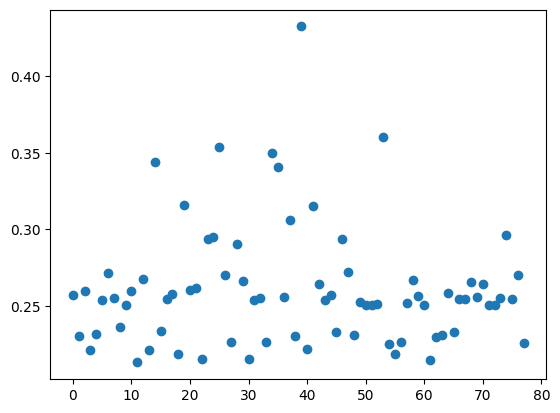

In [9]:
plt.scatter(range(78),home_betas)

In [5]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

travel_patches = []
for i in valid_patch_indices:
    if i not in home_patches:
        travel_patches.append(i)
        
def make_detailed_beta(short_beta):
    new_beta_0 = np.zeros(837)

    for i in range(78):
        new_beta_0[i] = short_beta[i]
    for i in range(837-78):
        new_beta_0[i+78] = short_beta[-1]
    return np.array(new_beta_0)

def expand_detailed_beta(detailed_beta):
    big_beta = np.zeros(6084)
    home_betas = detailed_beta[:78]
    travel_betas = detailed_beta[78:]
    big_beta[home_patches] = home_betas
    big_beta[travel_patches] = travel_betas
    
    return big_beta

# Load best beta values
with open("Normed Distributed Updated Final Formalized Buenos Aires Beta.pkl", "rb") as file:
    best_beta_yet_0 = pickle.load(file)
    
def expand_concise_betas(home_patches,travel_patches,concise_beta):
    long_beta = np.zeros(6084)
    for i in range(78):
        long_beta[home_patches[i]] = concise_beta[i]
    long_beta[travel_patches] = concise_beta[-1]
    
    return long_beta
    
best_beta_yet = expand_concise_betas(home_patches,travel_patches,best_beta_yet_0)

def plot_best_beta_vs_data(full_timeseries, pop_dict):
    """
    Extracts the relevant data, runs the SIR model with best_beta_yet, 
    and plots the beta values against the corresponding observed data.

    Parameters:
        full_timeseries (array-like): The full dataset of observed values.
        pop_dict (dict): Dictionary mapping population values.
    """
     # Load data
    working_timeseries = expand_timeseries(full_timeseries)
    
    short_pop_vector = np.array(list(pop_dict.values()))
    pop_vector = expand_array(short_pop_vector)
    
    day_list = np.arange(day_range)  # There are day_range days

    # Stack so each row is [day_index, corresponding 9 values]
    data = np.column_stack((day_list[:, None], working_timeseries))

    tspan = data[:, 0]
    timespan = tspan.shape[0] - 1
    gamma = 1 / 5

    # print(data.shape)
    
    I0 = np.zeros(6084)
    I0[home_patches] = current_cases
    S0 = pop_vector - I0
    I_total_0 = cum_cases
    
    params = [S0, I0, I_total_0, best_beta_yet, gamma, timespan]
    solution = run_model_London(params)
    y = solution[2]

    I_sum_model = compress_timeseries(y.T)
    raw_real_data = compress_timeseries(data.T[1:].T)
    normalizer = compress_array(pop_vector)[:, np.newaxis]
    test_data = I_sum_model / normalizer
    real_data = raw_real_data / normalizer

    # Get indices of the 10 stations with the highest total populations
    top_10_indices = np.argsort(-short_pop_vector)[:10]
    

    # Plot results
    # for i in top_10_indices:
        # plt.figure()
        # plt.plot(data[:, 0], test_data[i], 'r-', linewidth=2, label='Model Cumulative Cases')
        # plt.scatter(data[:, 0], real_data[i], c='k', s=50, label='Observed Cumulative Cases')

        # plt.xlabel('Time (Days)')
        # plt.ylabel('Normalized Cases')
        # plt.title(f'Beta Model vs Observed Data for Station {station_list[i]}')
        # plt.legend()
        # plt.show()
        
    # Plot total summed data across all patches
    summed_model = test_data.sum(axis=0)
    summed_real = real_data.sum(axis=0)

    # plt.figure()
    # plt.plot(data[:, 0], summed_model, 'r-', linewidth=2, label='Total Model Cumulative Cases')
    # plt.plot(data[:, 0], summed_real, 'k--', linewidth=2, label='Total Observed Cumulative Cases')
    # plt.xlabel('Time (Days)')
    # plt.ylabel('Summed Cumulative Cases')
    # plt.title('Total Model vs Observed Data Across All Patches')
    # plt.legend()
    # plt.show()
        
    return np.array(solution),params


In [51]:
# Get top 50 

reshaped_sol = solution[1][home_patches]

# Compute the ratio of final values to corresponding short_pop_vector entries
ratios = reshaped_sol[:, -1] / short_pop_vector

# Get indices of the 50 rows with the highest ratios
top_50_indices = np.argsort(ratios)[-100:][::-1]

top_50_indices

array([188, 184,  18, 109,  56,  77,  96, 151,  33, 119, 233, 240,  28,
       101, 118, 122,  23, 162, 128, 176,  43, 155, 228, 202, 137,  65,
        48,  44, 197, 210,  63, 247, 246,  45, 193,  60,   9, 191,  15,
       209, 159, 132, 120,  57,  75,  64, 223, 173, 195,  11, 238, 166,
        79,  14, 183, 127, 121, 199,  82, 131, 129, 170,   8, 196, 224,
        39, 157, 182,  22, 229, 107,  49, 169,  17,  87, 242, 211,   1,
       208, 130,  20, 126, 123,  83, 156, 161, 241, 136,  40, 236, 198,
        36, 111,  67,  38,  10, 138,  88, 207,  32])

In [52]:
np.array(station_list)[top_50_indices]

array(['South Kensington', 'Sloane Square', 'Bermondsey', 'Kennington',
       "Earl's Court", 'Gloucester Road', 'High Street Kensington',
       'Notting Hill Gate', 'Canada Water', 'Ladbroke Grove',
       'West Brompton', 'Westbourne Park', 'Brixton', 'Holland Park',
       'Knightsbridge', 'Latimer Road', 'Borough', 'Pimlico',
       'Maida Vale', 'Royal Oak', 'Clapham Common', 'Oval',
       'Warwick Avenue', 'Stockwell', 'Morden', 'Elephant & Castle',
       'Colliers Wood', 'Clapham North', "St. John's Wood",
       'Tooting Broadway', 'Edgware Road (B)', 'Wimbledon Park',
       'Wimbledon', 'Clapham South', 'Southfields', 'East Putney',
       'Balham', 'South Wimbledon', 'Bayswater', 'Tooting Bec',
       'Parsons Green', 'Marylebone', 'Lambeth North', 'East Acton',
       'Fulham Broadway', 'Edgware Road (C)', 'Vauxhall', "Regent's Park",
       'Southwark', 'Barbican', 'West Kensington', 'Putney Bridge',
       'Goldhawk Road', 'Barons Court', "Shepherd's Bush Market",
   

In [6]:

def sparse_isolate_patch(sparse_expanded_p_matrix, patch_idx, modification):
    from scipy.sparse import lil_matrix

    new_p = sparse_expanded_p_matrix.copy().tolil()  # stay sparse throughout
    changing_rows, home_indices = get_associated_indices(patch_idx)

    for idx in range(len(changing_rows)):
        row = changing_rows[idx]
        home = home_indices[idx]
        row_data = new_p.rows[row], new_p.data[row]

        # Scale all nonzero entries
        for i in range(len(row_data[1])):
            row_data[1][i] *= 1 - modification

        # Find the sum after scaling
        row_total = sum(row_data[1])

        # Find the original total (before scaling)
        original_total = sum(sparse_expanded_p_matrix.getrow(row).data)

        # Correct the home index
        found = False
        for idx_in_row, col_idx in enumerate(row_data[0]):
            if col_idx == home:
                row_data[1][idx_in_row] += original_total - row_total
                found = True
                break
        if not found:
            # If home wasn't in original nonzeros, add it
            new_p[row, home] = original_total - row_total

    return new_p.tocsr()

def get_associated_indices(station_idx):
    station_name = station_list[station_idx]
    associated_indices = []
    associated_homes = []
    mode = "everyone"
    # mode = "workers only"
    
    for i in range(6084):
        if station_name in pairs_list[i]:
            home_idx = home_patches[station_list.index(pairs_list[i][0])]
            if mode == "workers only":
                if home_patches[station_idx] != home_idx:
                    associated_indices.append(i)
                    associated_homes.append(home_idx)
            else:
                associated_indices.append(i)
                associated_homes.append(home_idx)
    return associated_indices,associated_homes

def isolate_patch(expanded_p_matrix,patch_idx,modification):
    new_p = expanded_p_matrix.copy()
    important_indices = get_associated_indices(patch_idx)
    changing_rows = important_indices[0]
    home_indices = important_indices[1]
    for idx in range(len(changing_rows)):
        row = changing_rows[idx]
        home = home_indices[idx]
        row_total = np.sum(new_p[row])
        new_p[row] *= 1-modification
        new_p[row][home] += row_total - np.sum(new_p[row])
    
    return np.round(new_p,1)

def convert_back_to_classic_p(fourth_phase):
    fifth_phase = np.zeros((6084,6084))

    for i in range(6084):
        connection = connections_list[i]
        home_patch = connection[0]
        home_index = connections_list.index((home_patch,home_patch))
        fifth_phase[home_index] += fourth_phase[i]

    sixth_phase = np.zeros((6084,6084))

    for i in range(6084):
        if np.sum(fifth_phase[i]) != 0:
            sixth_phase[i] = fifth_phase[i]/np.sum(fifth_phase[i])
        else:
            sixth_phase[i][i] = 1
    
    return sixth_phase


def full_sparse_isolate(sparse_expanded_p_matrix, patch_indices, station_list, pairs_list, home_patches, modification=0.9):
    # Precompute lookup
    station_to_indices_homes = {}
    for i in range(6084):
        pair = pairs_list[i]
        for station in pair:
            if station not in station_to_indices_homes:
                station_to_indices_homes[station] = ([], [])
            station_to_indices_homes[station][0].append(i)
            station_to_indices_homes[station][1].append(home_patches[station_list.index(pair[0])])

    # Build total set of affected rows and homes
    changing_rows = []
    home_indices = []
    for patch_idx in patch_indices:
        station_name = station_list[patch_idx]
        associated = station_to_indices_homes.get(station_name, ([], []))
        changing_rows.extend(associated[0])
        home_indices.extend(associated[1])

    # Now apply all changes
    new_p = sparse_expanded_p_matrix.copy().tolil()
    for idx in range(len(changing_rows)):
        row = changing_rows[idx]
        home = home_indices[idx]
        row_data = new_p.rows[row], new_p.data[row]

        for i in range(len(row_data[1])):
            row_data[1][i] *= 1 - modification

        row_total = sum(row_data[1])
        original_total = sum(sparse_expanded_p_matrix.getrow(row).data)

        found = False
        for idx_in_row, col_idx in enumerate(row_data[0]):
            if col_idx == home:
                row_data[1][idx_in_row] += original_total - row_total
                found = True
                break
        if not found:
            new_p[row, home] = original_total - row_total

    return new_p.tocsr()

def full_sparse_isolate_fast(sparse_expanded_p_matrix, patch_indices, station_list, pairs_list, home_patches, modification=0.9):
    # Precompute lookup
    station_to_indices_homes = {}
    for i, pair in enumerate(pairs_list[:6084]):
        for station in pair:
            if station not in station_to_indices_homes:
                station_to_indices_homes[station] = []
            station_to_indices_homes[station].append((i, home_patches[station_list.index(pair[0])]))

    # Collect affected rows and homes
    changing_info = []
    for patch_idx in patch_indices:
        station_name = station_list[patch_idx]
        changing_info.extend(station_to_indices_homes.get(station_name, []))

    if not changing_info:
        return sparse_expanded_p_matrix.copy()

    # Convert once
    new_p = sparse_expanded_p_matrix.tolil()
    
    # Apply changes
    for row, home in changing_info:
        cols = new_p.rows[row]
        data = new_p.data[row]

        if not data:
            continue

        original_total = sum(data)
        for i in range(len(data)):
            data[i] *= (1 - modification)

        reduced_total = sum(data)
        correction = original_total - reduced_total

        try:
            idx_home = cols.index(home)
            data[idx_home] += correction
        except ValueError:
            cols.append(home)
            data.append(correction)

    return new_p.tocsr()


import numpy as np
from scipy.sparse import csr_matrix

# --- Precompute everything outside the function ---

# Assume station_list, pairs_list, home_patches already defined
station_idx_map = {station: idx for idx, station in enumerate(station_list)}
home_patches = np.array(home_patches)

station_to_rows = {}
row_home_patches = np.empty(len(pairs_list[:6084]), dtype=int)

for i, pair in enumerate(pairs_list[:6084]):
    home = home_patches[station_idx_map[pair[0]]]
    row_home_patches[i] = home
    for station in pair:
        station_to_rows.setdefault(station, []).append(i)

# (Optional) Preconvert patch indices to station names
def get_patch_station_names(patch_indices, station_list):
    return [station_list[idx] for idx in patch_indices]

def full_sparse_isolate_ultrafast_csr(sparse_expanded_p_matrix, patch_station_names, station_to_rows, row_home_patches, modification=0.9):
    affected_rows = set()
    for station_name in patch_station_names:
        affected_rows.update(station_to_rows.get(station_name, []))
    
    if not affected_rows:
        return sparse_expanded_p_matrix.copy()

    affected_rows = np.array(list(affected_rows), dtype=int)

    p_csr = sparse_expanded_p_matrix.copy().tocsr()

    for row in affected_rows:
        start, end = p_csr.indptr[row], p_csr.indptr[row+1]
        if start == end:
            continue
        
        cols = p_csr.indices[start:end]
        data = p_csr.data[start:end]

        original_total = np.sum(data)
        data *= (1 - modification)
        reduced_total = np.sum(data)
        correction = original_total - reduced_total

        home = row_home_patches[row]
        home_idx = np.where(cols == home)[0]
        
        if home_idx.size > 0:
            data[home_idx[0]] += correction
        else:
            p_csr = insert_into_csr(p_csr, row, home, correction)

    return p_csr

def insert_into_csr(csr, row, col, value):
    new_indices = np.insert(csr.indices[csr.indptr[row]:csr.indptr[row+1]], 0, col)
    new_data = np.insert(csr.data[csr.indptr[row]:csr.indptr[row+1]], 0, value)

    sorted_idx = np.argsort(new_indices)
    new_indices = new_indices[sorted_idx]
    new_data = new_data[sorted_idx]

    csr.indices = np.concatenate([
        csr.indices[:csr.indptr[row]],
        new_indices,
        csr.indices[csr.indptr[row]:]
    ])
    csr.data = np.concatenate([
        csr.data[:csr.indptr[row]],
        new_data,
        csr.data[csr.indptr[row]:]
    ])
    csr.indptr[row+1:] += 1

    return csr




In [7]:
# PIECEWISE FUNCTION
# Define function to process solution
def process_solution(solution,timesteps):
    # Grouping by station subpopulation
    S_sol = solution[:6084]
    I_sol = solution[6084:12168]
    I_sol_total = solution[12168:]

    return [S_sol,I_sol,I_sol_total]



def run_model_London_with_isolation(params):
    S0,I0,I_total0,beta,gamma,timesteps = params
    
    if beta.shape[0]==837:
        beta = expand_betas(beta,6084)

    
    # Ensure no dividing by zero
    Nj[Nj == 0] = 1
    
    # Set up initial y0 vector
    y0 = np.concatenate((S0,I0,I_total0))
    
    # beta_p_matrix = (beta*p_matrix.T).T
    # beta_p_matrix = beta[:, None] * p_matrix 
    beta_p_matrix = sparse_p.multiply(beta[:, None])
    
    t = np.linspace(0,timesteps-1,num=timesteps)
    
    
    
    def sir(y,timestep,used_p,used_p_sparse,bpm):
        S = y[:6084]
        I = y[6084:12168]
        I_total = y[12168:]

        dSdt = np.zeros_like(S)
        dIdt = np.zeros_like(I)
        dI_totaldt = np.zeros_like(I_total)

        Ij = used_p.T @ I
        
        
        method = "vector"
        
        if method == "vector":

            # Compute Ij_div_Nj efficiently
            Ij_div_Nj = Ij / Nj  # Shape (6084,)
        
            # Vectorized computation of infection terms using sparse matrix multiplication
            infection_terms = bpm.multiply(S[:, None])  # (6084, 6084)
            infection_terms = infection_terms @ Ij_div_Nj  # (6084,)
        
            # Update derivatives
            dSdt -= infection_terms
            dIdt += infection_terms
            

        else:
            # Essentially, for all i, all j, dSdt[i] += -beta[j]*p_matrix[i][j]*S[i]*Ij[j]/Nj[j]
            for i in valid_patch_indices:
                for j in valid_patch_indices:
                    dSdt[i] += -beta[j]*used_p[i][j]*S[i]*Ij[j]/Nj[j]
            dIdt -= dSdt
    
        dI_totaldt += dIdt

        # Add the gamma terms
        dIdt -= gamma * I
        # dSdt += gamma * I

        # Concatenate results
        dx = np.concatenate((dSdt, dIdt, dI_totaldt))

        return dx
    
    y_log = np.zeros((len(t)+1,18252))
    y_log[0] = y0.copy()
    
    beta_p_matrix = sparse_p.multiply(beta[:, None])
    
    fitting_days = 14
    isolation_period = 60

    for step in range(len(t)):
        if step == fitting_days:
            beta_p_matrix = sparse_second_p.multiply(beta[:, None])
        if step == (fitting_days+isolation_period):
            beta_p_matrix = sparse_p.multiply(beta[:, None])
            
        if step >= fitting_days and step < (fitting_days+isolation_period):
            results = sir(y_log[step],step,second_p_matrix,sparse_second_p,beta_p_matrix)
        else:
            results = sir(y_log[step],step,p_matrix,sparse_p,beta_p_matrix)
        # print("step:",step)
        y_log[step+1] = y_log[step] + results
    
    solution = process_solution(y_log.T,timesteps)
    
    return solution
    
    
def plot_best_beta_vs_data_with_isolation(full_timeseries, pop_dict):
    """
    Extracts the relevant data, runs the SIR model with best_beta_yet, 
    and plots the beta values against the corresponding observed data.

    Parameters:
        full_timeseries (array-like): The full dataset of observed values.
        pop_dict (dict): Dictionary mapping population values.
    """
     # Load data
    working_timeseries = expand_timeseries(full_timeseries)
    
    short_pop_vector = np.array(list(pop_dict.values()))
    pop_vector = expand_array(short_pop_vector)
    
    day_list = np.arange(day_range)  # There are day_range days

    # Stack so each row is [day_index, corresponding 9 values]
    data = np.column_stack((day_list[:, None], working_timeseries))

    tspan = data[:, 0]
    timespan = tspan.shape[0] - 1
    gamma = 1 / 5

    # print(data.shape)
    
    I0 = np.zeros(6084)
    I0[home_patches] = current_cases
    S0 = pop_vector - I0
    I_total_0 = cum_cases
    
    params = [S0, I0, I_total_0, best_beta_yet, gamma, timespan]
    solution = run_model_London_with_isolation(params)
    y = solution[2]

    I_sum_model = compress_timeseries(y.T)
    raw_real_data = compress_timeseries(data.T[1:].T)
    normalizer = compress_array(pop_vector)[:, np.newaxis]
    test_data = I_sum_model / normalizer
    real_data = raw_real_data / normalizer

    # Get indices of the 10 stations with the highest total populations
    top_10_indices = np.argsort(-short_pop_vector)[:10]
    

    # Plot results
    # for i in top_10_indices:
        # plt.figure()
        # plt.plot(data[:, 0], test_data[i], 'r-', linewidth=2, label='Model Cumulative Cases')
        # plt.scatter(data[:, 0], real_data[i], c='k', s=50, label='Observed Cumulative Cases')

        # plt.xlabel('Time (Days)')
        # plt.ylabel('Normalized Cases')
        # plt.title(f'Beta Model vs Observed Data for Station {station_list[i]}')
        # plt.legend()
        # plt.show()
        
    # Plot total summed data across all patches
    summed_model = test_data.sum(axis=0)
    summed_real = real_data.sum(axis=0)

    # plt.figure()
    # plt.plot(data[:, 0], summed_model, 'r-', linewidth=2, label='Total Model Cumulative Cases')
    # plt.plot(data[:, 0], summed_real, 'k--', linewidth=2, label='Total Observed Cumulative Cases')
    # plt.xlabel('Time (Days)')
    # plt.ylabel('Summed Cumulative Cases')
    # plt.title('Total Model vs Observed Data Across All Patches')
    # plt.legend()
    # plt.show()
        
    return np.array(solution),params

In [167]:
# with open("Sparse R0 based 75 Patch Isolated P Matrix.pkl", "wb") as f:
    # pickle.dump(sparse_second_p, f)

In [49]:
indices.shape

(100,)

In [19]:
expanded_p_matrix.shape

(78, 78)

Isolating patches one by one: 100%|██████████| 78/78 [02:39<00:00,  2.05s/it]


In [63]:
from scipy.sparse import csr_matrix
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress bar

with open("combined_travel_times.pkl", "rb") as file:
    travel_times = pickle.load(file)

connections_list = []
for i in range(78):
    for j in range(78):
        connections_list.append((station_list[i],station_list[j]))

travel_vector = np.zeros(6084)
for i in range(6084):
    current_leg = connections_list[i]
    if current_leg[0]==current_leg[1]:
        travel_vector[i] = 8/24
    else:
        if current_leg in list(travel_times.keys()):
            travel_vector[i] = travel_times[current_leg]/(60*24)


# Define time range
# timesteps = 8
# tspan = np.linspace(0, timesteps, timesteps+1)

# Initialize storage for results
# isolated_patches = np.array([0])  # [0, 5, 10, ..., 50]
isolated_patches = np.array([ 3, 40, 51, 50, 28, 62, 54,  1, 48,  4, 45, 65, 15, 56, 77, 27, 63,
       39, 33, 38,  8])
patch_station_names = get_patch_station_names(isolated_patches, station_list)
isolation_strength = 0.9
infection_sums = []
modified_expanded_p_matrix = sparse_expanded_p_matrix.copy()

for patch in tqdm(isolated_patches, desc="Isolating patches"):
    modified_expanded_p_matrix = full_sparse_isolate_ultrafast_csr(
                                                                    sparse_expanded_p_matrix,
                                                                    patch_station_names,
                                                                    station_to_rows,
                                                                    row_home_patches,
                                                                    modification=0.9
                                                                ).toarray()



    
second_p_matrix = convert_back_to_classic_p(modified_expanded_p_matrix)
sparse_second_p = csr_matrix(second_p_matrix)

solution,params = plot_best_beta_vs_data(all_station_timeseries, pop_dict)
solution_best_iso,params_best_iso = plot_best_beta_vs_data_with_isolation(all_station_timeseries, pop_dict)

Isolating patches: 100%|██████████| 21/21 [00:03<00:00,  6.81it/s]


In [55]:
with open("Sparse Buenos Aires Expanded P Matrix.pkl", 'rb') as file:
    sparse_expanded_p_matrix = pickle.load(file)

expanded_p_matrix = sparse_expanded_p_matrix.toarray()

solution,params = plot_best_beta_vs_data(all_station_timeseries, pop_dict)

In [64]:
from scipy.sparse import csr_matrix
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress bar

with open("combined_travel_times.pkl", "rb") as file:
    travel_times = pickle.load(file)

connections_list = []
for i in range(78):
    for j in range(78):
        connections_list.append((station_list[i],station_list[j]))

travel_vector = np.zeros(6084)
for i in range(6084):
    current_leg = connections_list[i]
    if current_leg[0]==current_leg[1]:
        travel_vector[i] = 8/24
    else:
        if current_leg in list(travel_times.keys()):
            travel_vector[i] = travel_times[current_leg]/(60*24)


# Define time range
# timesteps = 8
# tspan = np.linspace(0, timesteps, timesteps+1)

# Initialize storage for results
# isolated_patches = np.array([0])  # [0, 5, 10, ..., 50]
isolated_patches = range(78)
# isolated_patches = top_n_indices.copy()
patch_station_names = get_patch_station_names(isolated_patches, station_list)
isolation_strength = 0.9
infection_sums = []
modified_expanded_p_matrix = sparse_expanded_p_matrix.copy()

for patch in tqdm(isolated_patches, desc="Isolating patches"):
    modified_expanded_p_matrix = full_sparse_isolate_ultrafast_csr(
                                                                    sparse_expanded_p_matrix,
                                                                    patch_station_names,
                                                                    station_to_rows,
                                                                    row_home_patches,
                                                                    modification=0.9
                                                                ).toarray()



    
second_p_matrix = convert_back_to_classic_p(modified_expanded_p_matrix)
sparse_second_p = csr_matrix(second_p_matrix)


solution_full_iso, params_full_iso = plot_best_beta_vs_data_with_isolation(all_station_timeseries, pop_dict)

Isolating patches: 100%|██████████| 78/78 [00:16<00:00,  4.81it/s]


In [59]:
top_n_indices

array([ 3, 40, 51, 50, 28, 62, 54,  1, 48,  4, 45, 65, 15, 56, 77, 27, 63,
       39, 33, 38,  8])

In [ ]:
# PIECEWISE FUNCTION
# Define function to process solution
def process_solution(solution,timesteps):
    # Grouping by station subpopulation
    S_sol = solution[:6084]
    I_sol = solution[6084:12168]
    I_sol_total = solution[12168:]

    return [S_sol,I_sol,I_sol_total]



def run_model_London_with_isolation(params):
    S0,I0,I_total0,beta,gamma,timesteps = params
    
    if beta.shape[0]==837:
        beta = expand_betas(beta,6084)

    
    # Ensure no dividing by zero
    Nj[Nj == 0] = 1
    
    # Set up initial y0 vector
    y0 = np.concatenate((S0,I0,I_total0))
    
    # beta_p_matrix = (beta*p_matrix.T).T
    # beta_p_matrix = beta[:, None] * p_matrix 
    beta_p_matrix = sparse_p.multiply(beta[:, None])
    
    t = np.linspace(0,timesteps-1,num=timesteps)
    
    
    
    def sir(y,timestep,used_p,used_p_sparse,bpm):
        S = y[:6084]
        I = y[6084:12168]
        I_total = y[12168:]

        dSdt = np.zeros_like(S)
        dIdt = np.zeros_like(I)
        dI_totaldt = np.zeros_like(I_total)

        Ij = used_p.T @ I
        
        
        method = "vector"
        
        if method == "vector":

            # Compute Ij_div_Nj efficiently
            Ij_div_Nj = Ij / Nj  # Shape (6084,)
        
            # Vectorized computation of infection terms using sparse matrix multiplication
            infection_terms = bpm.multiply(S[:, None])  # (6084, 6084)
            infection_terms = infection_terms @ Ij_div_Nj  # (6084,)
        
            # Update derivatives
            dSdt -= infection_terms
            dIdt += infection_terms
            

        else:
            # Essentially, for all i, all j, dSdt[i] += -beta[j]*p_matrix[i][j]*S[i]*Ij[j]/Nj[j]
            for i in valid_patch_indices:
                for j in valid_patch_indices:
                    dSdt[i] += -beta[j]*used_p[i][j]*S[i]*Ij[j]/Nj[j]
            dIdt -= dSdt
    
        dI_totaldt += dIdt

        # Add the gamma terms
        dIdt -= gamma * I
        # dSdt += gamma * I

        # Concatenate results
        dx = np.concatenate((dSdt, dIdt, dI_totaldt))

        return dx
    
    y_log = np.zeros((len(t)+1,18252))
    y_log[0] = y0.copy()
    
    beta_p_matrix = sparse_p.multiply(beta[:, None])
    
    fitting_days = 14
    isolation_period = 90

    for step in range(len(t)):
        if step == fitting_days:
            beta_p_matrix = sparse_second_p.multiply(beta[:, None])
        if step == (fitting_days+isolation_period):
            beta_p_matrix = sparse_p.multiply(beta[:, None])
            
        if step >= fitting_days and step < (fitting_days+isolation_period):
            results = sir(y_log[step],step,second_p_matrix,sparse_second_p,beta_p_matrix)
        else:
            results = sir(y_log[step],step,p_matrix,sparse_p,beta_p_matrix)
        # print("step:",step)
        y_log[step+1] = y_log[step] + results
    
    solution = process_solution(y_log.T,timesteps)
    
    return solution
    
    
def plot_best_beta_vs_data_with_isolation(full_timeseries, pop_dict):
    """
    Extracts the relevant data, runs the SIR model with best_beta_yet, 
    and plots the beta values against the corresponding observed data.

    Parameters:
        full_timeseries (array-like): The full dataset of observed values.
        pop_dict (dict): Dictionary mapping population values.
    """
     # Load data
    working_timeseries = expand_timeseries(full_timeseries)
    
    short_pop_vector = np.array(list(pop_dict.values()))
    pop_vector = expand_array(short_pop_vector)
    
    day_list = np.arange(day_range)  # There are day_range days

    # Stack so each row is [day_index, corresponding 9 values]
    data = np.column_stack((day_list[:, None], working_timeseries))

    tspan = data[:, 0]
    timespan = tspan.shape[0] - 1
    gamma = 1 / 5

    # print(data.shape)
    
    I0 = np.zeros(6084)
    I0[home_patches] = current_cases
    S0 = pop_vector - I0
    I_total_0 = cum_cases
    
    params = [S0, I0, I_total_0, best_beta_yet, gamma, timespan]
    solution = run_model_London_with_isolation(params)
    y = solution[2]

    I_sum_model = compress_timeseries(y.T)
    raw_real_data = compress_timeseries(data.T[1:].T)
    normalizer = compress_array(pop_vector)[:, np.newaxis]
    test_data = I_sum_model / normalizer
    real_data = raw_real_data / normalizer

    # Get indices of the 10 stations with the highest total populations
    top_10_indices = np.argsort(-short_pop_vector)[:10]
    

    # Plot results
    # for i in top_10_indices:
        # plt.figure()
        # plt.plot(data[:, 0], test_data[i], 'r-', linewidth=2, label='Model Cumulative Cases')
        # plt.scatter(data[:, 0], real_data[i], c='k', s=50, label='Observed Cumulative Cases')

        # plt.xlabel('Time (Days)')
        # plt.ylabel('Normalized Cases')
        # plt.title(f'Beta Model vs Observed Data for Station {station_list[i]}')
        # plt.legend()
        # plt.show()
        
    # Plot total summed data across all patches
    summed_model = test_data.sum(axis=0)
    summed_real = real_data.sum(axis=0)

    # plt.figure()
    # plt.plot(data[:, 0], summed_model, 'r-', linewidth=2, label='Total Model Cumulative Cases')
    # plt.plot(data[:, 0], summed_real, 'k--', linewidth=2, label='Total Observed Cumulative Cases')
    # plt.xlabel('Time (Days)')
    # plt.ylabel('Summed Cumulative Cases')
    # plt.title('Total Model vs Observed Data Across All Patches')
    # plt.legend()
    # plt.show()
        
    return np.array(solution),params


import numpy as np
import pickle
import sys
import os
import contextlib
import matplotlib
from tqdm import tqdm
from scipy.sparse import csr_matrix

# Suppress matplotlib GUI
matplotlib.use('Agg')

# Load travel times
with open("combined_travel_times.pkl", "rb") as file:
    travel_times = pickle.load(file)

# Build travel vector
connections_list = [(station_list[i], station_list[j]) for i in range(78) for j in range(78)]
travel_vector = np.zeros(6084)
for i, current_leg in enumerate(connections_list):
    if current_leg[0] == current_leg[1]:
        travel_vector[i] = 8/24
    elif current_leg in travel_times:
        travel_vector[i] = travel_times[current_leg] / (60*24)

# Initialize
patch_isolation_benefits = []

# Save original stdout
saved_stdout = sys.stdout
saved_stderr = sys.stderr

# Suppress everything except tqdm
class TqdmCompatibleFile:
    def write(self, x):
        if x.strip():
            saved_stdout.write(x)
    def flush(self):
        saved_stdout.flush()

sys.stdout = TqdmCompatibleFile()
sys.stderr = TqdmCompatibleFile()

solution, params = plot_best_beta_vs_data(all_station_timeseries, pop_dict)
y1_sum = solution[2][home_patches].sum(axis=0)

try:
    for patch in tqdm(range(78), desc="Evaluating isolated matrices one by one"):
        # Load precomputed isolated matrix
        isolated_p_matrix_path = f"isolated_p_matrices_ba/isolated_p_matrix_patch_{patch}.pkl"
        if not os.path.exists(isolated_p_matrix_path):
            continue  # Skip if missing
        
        with open(isolated_p_matrix_path, "rb") as f:
            sparse_second_p = pickle.load(f)
            
        second_p_matrix = sparse_second_p.toarray()
        
        # Simulate using loaded matrix
        
        solution_with_iso, params_with_iso = plot_best_beta_vs_data_with_isolation(all_station_timeseries, pop_dict)

        
        y2_sum = solution_with_iso[2][home_patches].sum(axis=0)
        infections_prevented = (y1_sum - y2_sum)[-1]

        patch_isolation_benefits.append(infections_prevented)
finally:
    sys.stdout = saved_stdout
    sys.stderr = saved_stderr

In [113]:
#with open("90 Day Take 2 14 Day Fitted Beta 14 Day Buffer 240 Days Total Buenos Aires Patch Isolation Effects.pkl", "wb") as f:
    #pickle.dump(patch_isolation_benefits, f)
    

In [114]:
patch_isolation_benefits

[np.float64(-10973.209169035312),
 np.float64(-660.9555628796807),
 np.float64(-330.0625625536777),
 np.float64(141.26949091383722),
 np.float64(-527.5507911841851),
 np.float64(-2587.8588682864793),
 np.float64(-906.7361366071273),
 np.float64(-512.4855458607199),
 np.float64(-3567.614225034835),
 np.float64(-293.7311419004109),
 np.float64(-389.81711380009074),
 np.float64(-2248.648970321752),
 np.float64(-380.19967707712203),
 np.float64(532.3195701463846),
 np.float64(2625.0639587319456),
 np.float64(-1600.2171869087033),
 np.float64(-210.9557975278003),
 np.float64(-16386.900846604956),
 np.float64(-138.50138850533403),
 np.float64(2687.2902727875626),
 np.float64(-17897.464314523735),
 np.float64(-428.07251308870036),
 np.float64(-1769.4821324604563),
 np.float64(928.8123024899978),
 np.float64(1073.4191247134004),
 np.float64(3008.7597907364834),
 np.float64(-500.2402060084278),
 np.float64(-1692.3404900230234),
 np.float64(-1619.2950045750476),
 np.float64(-874.9247662455309),


In [134]:
import numpy as np
from tqdm import tqdm
from scipy.sparse import csr_matrix

with open("60 Day Take 2 14 Day Fitted Beta 14 Day Buffer 240 Days Total Buenos Aires Patch Isolation Effects.pkl", "rb") as file:
    patch_isolation_effects = np.array(pickle.load(file))
    
# Sort patches most helpful first
patch_order = np.argsort(-np.array(patch_isolation_effects))
save_path = "BA 60 Day total_infections_prevented_progress.pkl"

# Load previous progress if exists
if os.path.exists(save_path):
    with open(save_path, 'rb') as f:
        total_infections_prevented = pickle.load(f)
else:
    total_infections_prevented = []

start_n = len(total_infections_prevented)
solution, params = plot_best_beta_vs_data(all_station_timeseries, pop_dict)
y1_sum = solution[2][home_patches].sum(axis=0)

for n in tqdm(range(start_n + 1, len(patch_order)+1), desc="Increasing number of patches isolated"):
    isolated_patches = patch_order[:n]
    patch_station_names = get_patch_station_names(isolated_patches, station_list)
    isolation_strength = 0.9

    modified_expanded_p_matrix = full_sparse_isolate_ultrafast_csr(
        sparse_expanded_p_matrix,
        patch_station_names,
        station_to_rows,
        row_home_patches,
        modification=isolation_strength
    ).toarray()

    second_p_matrix = convert_back_to_classic_p(modified_expanded_p_matrix)
    sparse_second_p = csr_matrix(second_p_matrix)

    
    solution_with_iso, params_with_iso = plot_best_beta_vs_data_with_isolation(all_station_timeseries, pop_dict)

    
    y2_sum = solution_with_iso[2][home_patches].sum(axis=0)

    infections_prevented = (y1_sum - y2_sum)[-1]
    total_infections_prevented.append(infections_prevented)
    
    # Save progress after each append
    with open(save_path, 'wb') as f:
        pickle.dump(total_infections_prevented, f)


Increasing number of patches isolated: 100%|██████████| 78/78 [02:07<00:00,  1.63s/it]


In [13]:
with open("BA 60 Day total_infections_prevented_progress.pkl", "rb") as file:
    total_infections_prevented = np.array(pickle.load(file))
    
total_infections_prevented

array([   7796.85398688,   13542.13555197,   16737.31886888,
         19988.5907077 ,   22887.36433381,   25737.15122649,
         28823.33378672,   30549.67377769,   31903.75236275,
         31045.60172861,   30848.52129723,   30553.37862683,
         28915.24053966,   28742.71599438,   29571.62732303,
         28234.56824849,   27653.44795118,   27434.91274232,
         27338.87659559,   26165.53793167,   26054.4990577 ,
         23569.59386643,   23350.94707745,   22894.27425456,
         21721.08814838,   20314.44095712,   19618.83652158,
         19386.43961429,   18732.71536224,   16403.60246352,
         14883.93149104,   13119.75298046,   11868.42709027,
         10877.87453234,   10533.60056577,   10308.28924985,
          8563.96913816,    6399.448834  ,    2803.61696907,
           389.61526491,   -1584.32894163,   -5483.40505383,
         -7867.90266878,  -11154.0944021 ,  -14524.44770268,
        -16442.95111537,  -19159.32134081,  -20617.57932436,
        -22799.47526983,

In [15]:
total_infections_prevented.shape

(78,)

In [16]:
test_array = np.array([1,2,3,4,3,2,3,2,1])

def get_up_indices(arr):
    indices = []
    indices.append(0)
    print(indices)
    
    for i in range(arr.shape[0]-1):
        if arr[i+1]>arr[i]:
            indices.append(i+1)
            print(indices)
    
    return np.array(indices)

get_up_indices(total_infections_prevented)

[0]
[0, 1]
[0, 1, 2]
[0, 1, 2, 3]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5, 6]
[0, 1, 2, 3, 4, 5, 6, 7]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 14]


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 14])

In [17]:
np.max(total_infections_prevented)

np.float64(31903.752362754545)

In [18]:
from scipy.sparse import csr_matrix
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress bar

with open("combined_travel_times.pkl", "rb") as file:
    travel_times = pickle.load(file)

connections_list = []
for i in range(78):
    for j in range(78):
        connections_list.append((station_list[i],station_list[j]))

travel_vector = np.zeros(6084)
for i in range(6084):
    current_leg = connections_list[i]
    if current_leg[0]==current_leg[1]:
        travel_vector[i] = 8/24
    else:
        if current_leg in list(travel_times.keys()):
            travel_vector[i] = travel_times[current_leg]/(60*24)


# Define time range
# timesteps = 8
# tspan = np.linspace(0, timesteps, timesteps+1)

# Initialize storage for results
# isolated_patches = np.array([0])  # [0, 5, 10, ..., 50]
isolated_patches = get_up_indices(total_infections_prevented)
# isolated_patches = top_n_indices.copy()
patch_station_names = get_patch_station_names(isolated_patches, station_list)
isolation_strength = 0.9
infection_sums = []
modified_expanded_p_matrix = sparse_expanded_p_matrix.copy()

for patch in tqdm(isolated_patches, desc="Isolating patches"):
    modified_expanded_p_matrix = full_sparse_isolate_ultrafast_csr(
                                                                    sparse_expanded_p_matrix,
                                                                    patch_station_names,
                                                                    station_to_rows,
                                                                    row_home_patches,
                                                                    modification=0.9
                                                                ).toarray()



    
second_p_matrix = convert_back_to_classic_p(modified_expanded_p_matrix)
sparse_second_p = csr_matrix(second_p_matrix)


solution_test_iso, params_test_iso = plot_best_beta_vs_data_with_isolation(all_station_timeseries, pop_dict)

[0]
[0, 1]
[0, 1, 2]
[0, 1, 2, 3]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5, 6]
[0, 1, 2, 3, 4, 5, 6, 7]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 14]


Isolating patches: 100%|██████████| 10/10 [00:01<00:00,  7.25it/s]


In [33]:
og_sum = solution[2][home_patches].sum(axis=0)  # shape (16,)
new_sum = solution_test_iso[2][home_patches].sum(axis=0)
best_sum = solution_best_iso[2][home_patches].sum(axis=0)


In [109]:
total_infections_prevented[:18]

[np.float64(816.0142579844687),
 np.float64(826.8057676220778),
 np.float64(837.4915245746961),
 np.float64(848.8357708873227),
 np.float64(855.9436690341681),
 np.float64(862.4570930809714),
 np.float64(859.8335908532608),
 np.float64(855.2730790264904),
 np.float64(853.8738233905751),
 np.float64(848.1997752813622),
 np.float64(836.1425042913761),
 np.float64(835.2850543620298),
 np.float64(834.822470256011),
 np.float64(819.67899076303),
 np.float64(806.8128860667348),
 np.float64(796.9220574261853),
 np.float64(790.1127099080477),
 np.float64(770.7430429244414)]

<IPython.core.display.Javascript object>


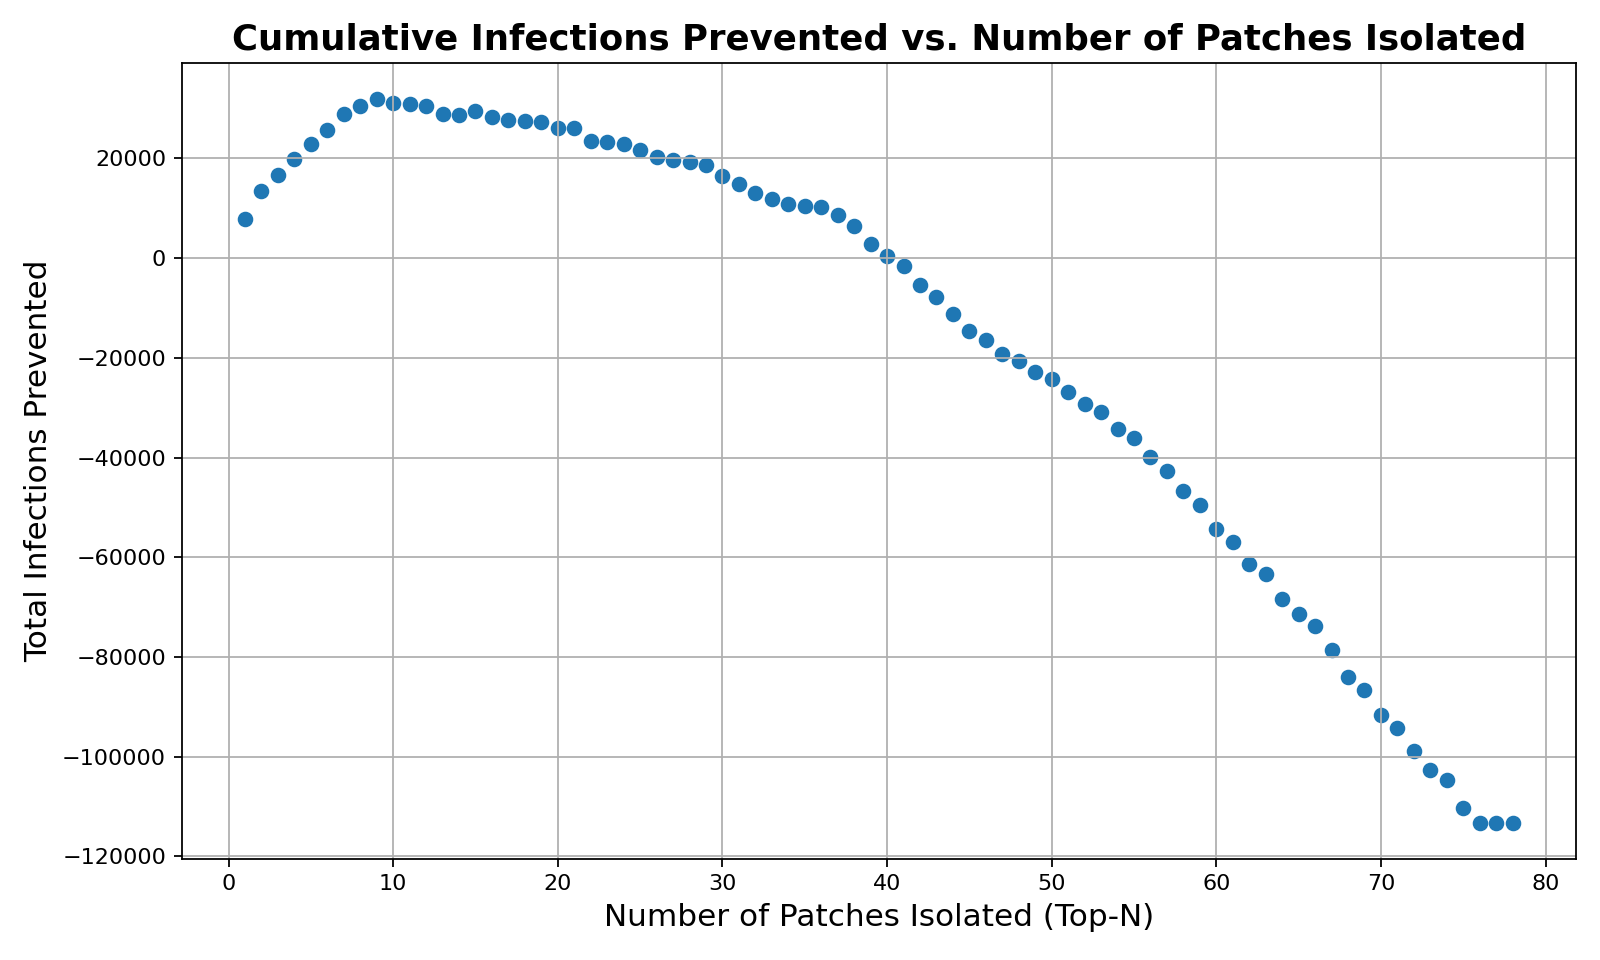

In [33]:
import matplotlib.pyplot as plt
import os


with open("60 Day Take 2 14 Day Fitted Beta 14 Day Buffer 240 Days Total Buenos Aires Patch Isolation Effects.pkl", "rb") as file:
    patch_isolation_benefits = np.array(pickle.load(file))
    
    
save_path = "BA 60 Day total_infections_prevented_progress.pkl"

# Load previous progress if exists
if os.path.exists(save_path):
    with open(save_path, 'rb') as f:
        total_infections_prevented = pickle.load(f)

patch_isolation_effects = np.array(patch_isolation_benefits)
best_top_n = np.argmax(total_infections_prevented) + 1  # +1 because x_vals starts at 1

# Now, get the top-N values from patch_isolation_effects
top_n_values = np.sort(patch_isolation_effects)[-best_top_n:]  # largest N values


top_n_indices = np.argsort(patch_isolation_effects)[-best_top_n:]
top_n_values = patch_isolation_effects[top_n_indices]

import matplotlib.pyplot as plt

x_vals = np.arange(1, len(total_infections_prevented)+ 1)

plt.figure(figsize=(10,6))
plt.scatter(x_vals, total_infections_prevented, marker='o')
plt.xlabel('Number of Patches Isolated (Top-N)', fontsize=14)
plt.ylabel('Total Infections Prevented', fontsize=14)
plt.title('Cumulative Infections Prevented vs. Number of Patches Isolated', fontsize=16, fontweight='bold')
plt.grid(True)
plt.tight_layout()
plt.show()

In [151]:
top_n_indices.shape

(9,)

In [137]:
top_n_indices,top_n_values

(array([41, 37, 35, 14, 19, 25, 53, 34, 39]),
 array([1480.79048039, 1691.46390949, 2481.84492618, 2625.06395873,
        2687.29027279, 3008.75979074, 3080.12918891, 5522.21096596,
        7796.85398688]))

In [126]:
first_drop_found = False

for i in range(len(total_infections_prevented) - 1):
    if not first_drop_found:
        if total_infections_prevented[i+1] < total_infections_prevented[i]:
            print(f"First drop at index {i}")
            first_drop_found = True
    else:
        if total_infections_prevented[i+1] > total_infections_prevented[i]:
            print(f"Not monotone at index {i} (increase detected)")

First drop at index 12


In [48]:
len(total_infections_prevented)

78

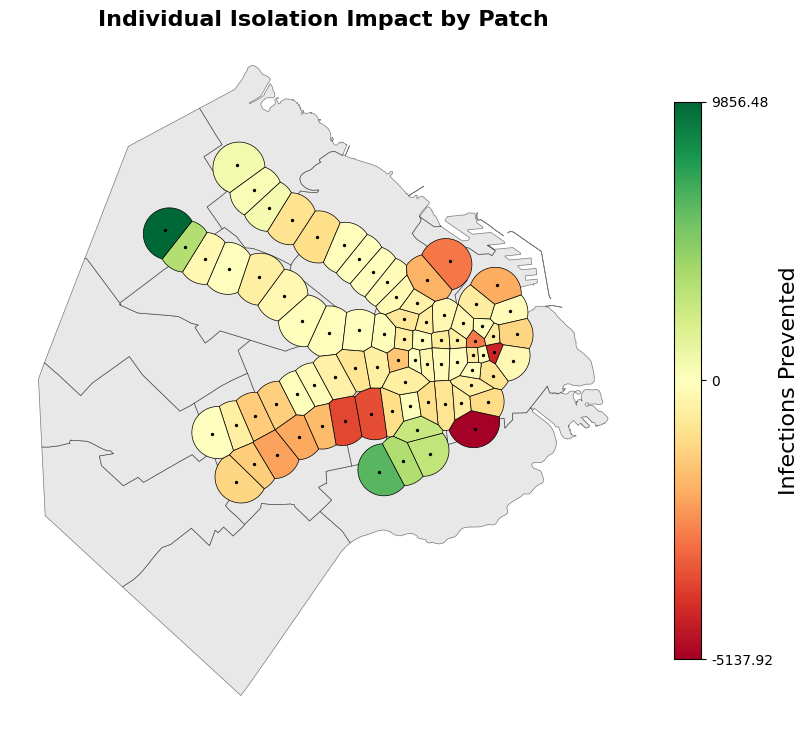

In [149]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pickle
import numpy as np

with open("60 Day Take 2 14 Day Fitted Beta 14 Day Buffer 240 Days Total Buenos Aires Patch Isolation Effects.pkl", 'rb') as file:
    patch_isolation_effects = pickle.load(file)

def plot_isolation_effects_map(patch_isolation_effects, title="Individual Isolation Impact by Patch"):
    voronoi_gdf = gpd.read_file("BA_Voronoi_File_1km.shp")
    boroughs_gdf = gpd.read_file("comunas.shp")

    voronoi_gdf = voronoi_gdf.to_crs(epsg=3857)
    boroughs_gdf = boroughs_gdf.to_crs(epsg=3857)

    voronoi_gdf["effects"] = patch_isolation_effects

    fig, ax = plt.subplots(figsize=(12, 9))
    boroughs_gdf.plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=0.5, alpha=0.5)

    vmin = voronoi_gdf["effects"].min()
    vmax = voronoi_gdf["effects"].max()
    norm = mcolors.TwoSlopeNorm(vcenter=0, vmin=vmin, vmax=vmax)

    mesh = voronoi_gdf.plot(
        ax=ax,
        column="effects",
        cmap="RdYlGn",
        norm=norm,
        edgecolor="black",
        linewidth=0.5,
        alpha=1,
        legend=False  # don't use built-in legend
    )

    sm = plt.cm.ScalarMappable(cmap="RdYlGn", norm=norm)
    sm.set_array([])  # needed for colorbar
    cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.04, ticks=[vmin, 0, vmax])
    cbar.ax.set_yticklabels([f"{vmin:.2f}", "0", f"{vmax:.2f}"])
    cbar.set_label("Infections Prevented", fontsize=16)

    voronoi_gdf["geometry"].centroid.plot(ax=ax, color="black", markersize=2)

    ax.set_title(title, fontweight='bold', fontsize=16)
    ax.axis("off")
    plt.show()

plot_isolation_effects_map(patch_isolation_effects)


In [147]:
np.sum(pop_vector)

np.float64(1339058.7229030002)

<IPython.core.display.Javascript object>


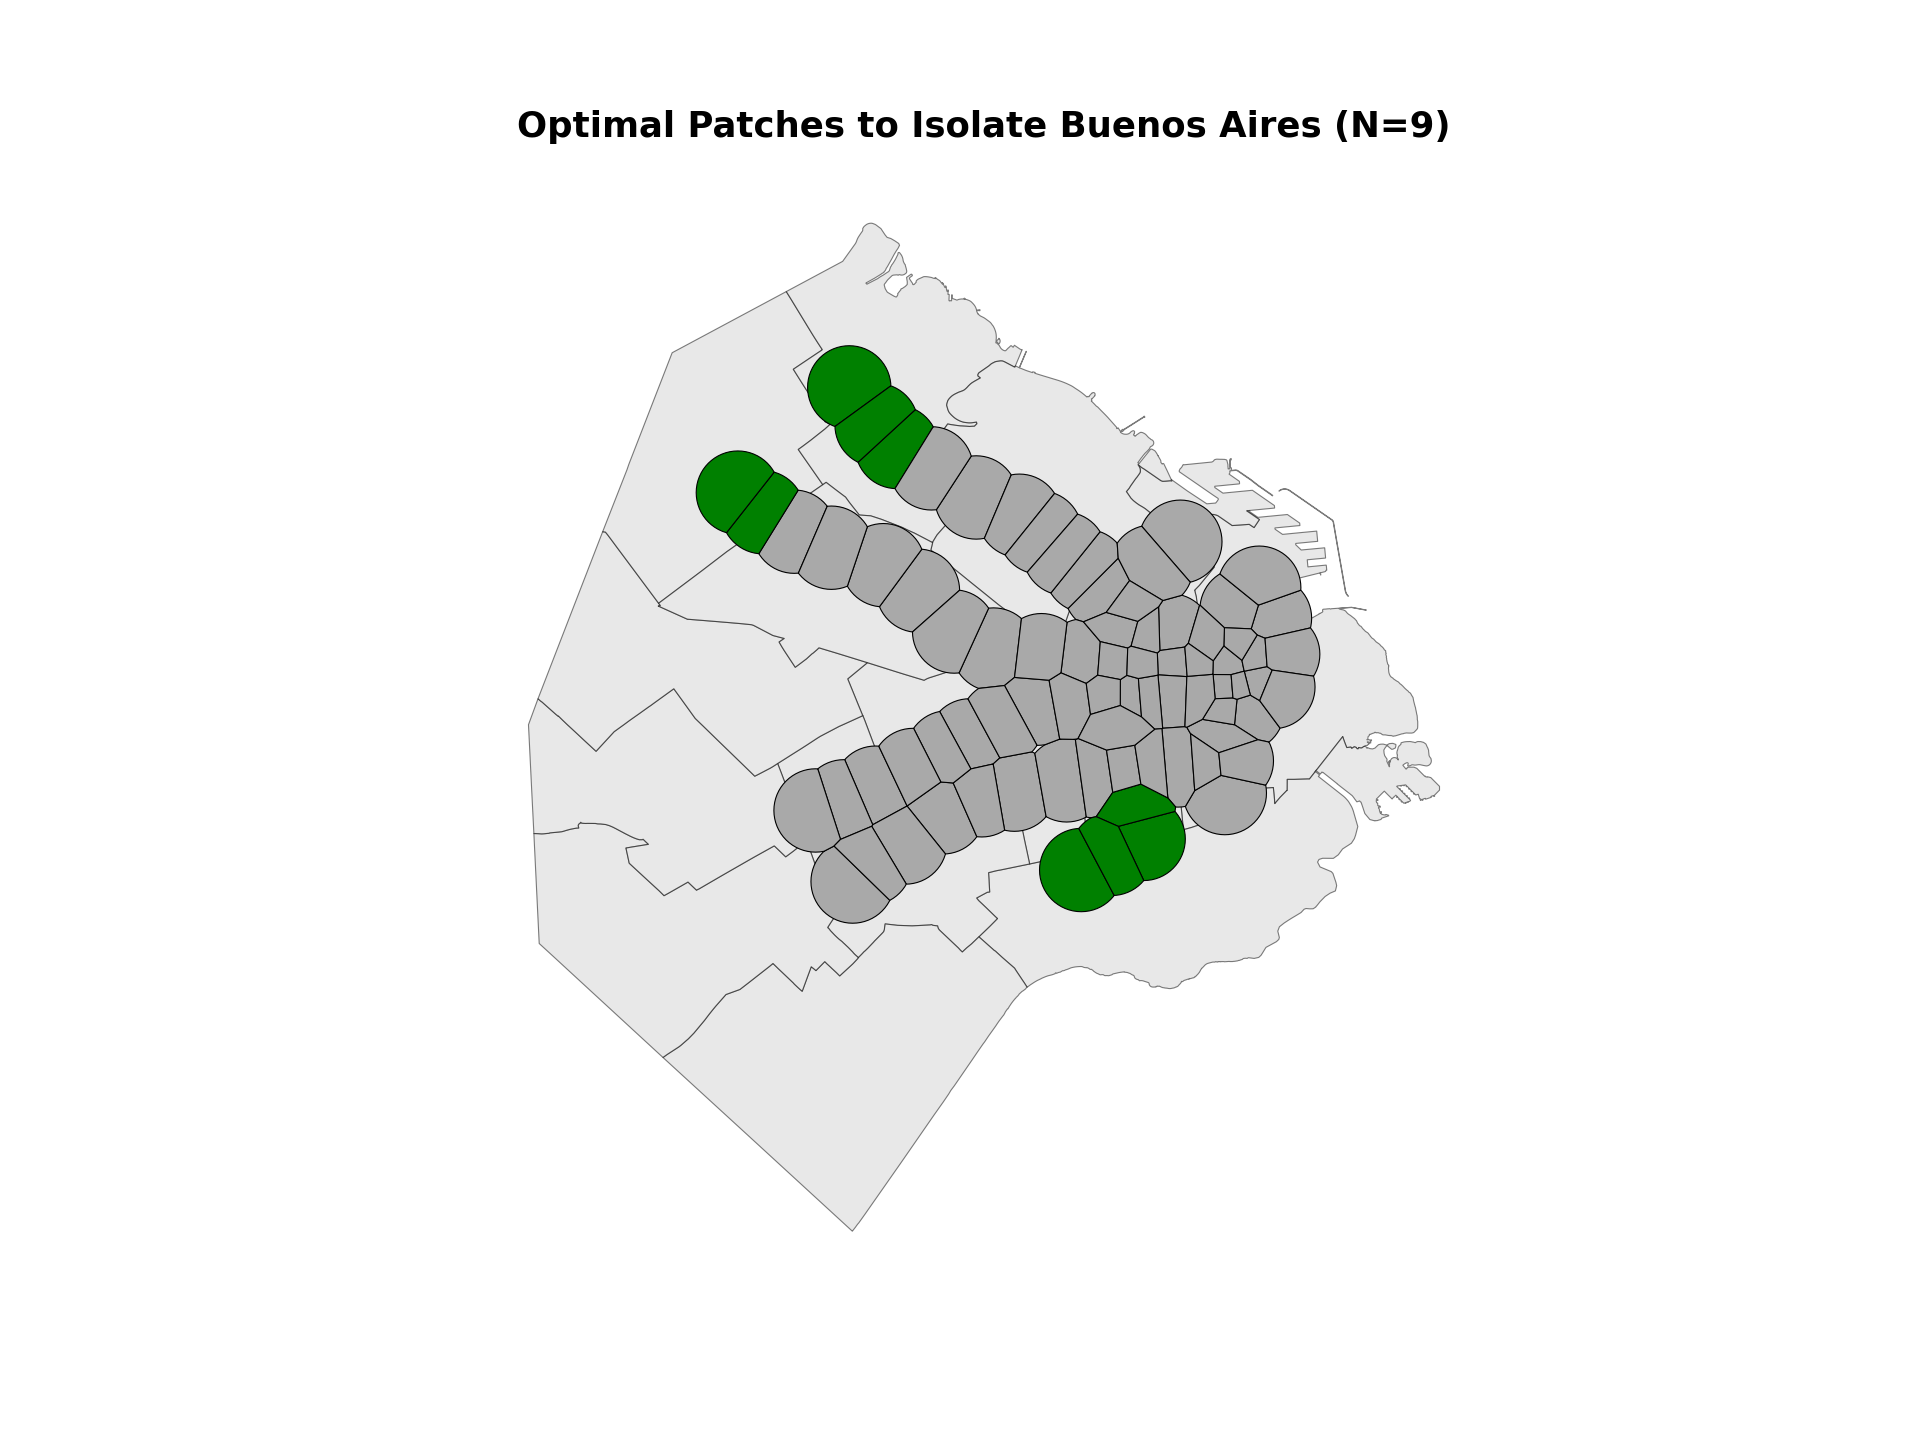

In [37]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pickle

with open("60 Day Take 2 14 Day Fitted Beta 14 Day Buffer 240 Days Total Buenos Aires Patch Isolation Effects.pkl", 'rb') as file:
    patch_isolation_effects = pickle.load(file)

selected_indices = top_n_indices.copy()  # example selected indices

def plot_selected_patches(selected_indices, title="Optimal Patches to Isolate Buenos Aires (N=9)"):
    voronoi_gdf = gpd.read_file("BA_Voronoi_File_1km.shp")
    boroughs_gdf = gpd.read_file("comunas.shp")

    voronoi_gdf = voronoi_gdf.to_crs(epsg=3857)
    boroughs_gdf = boroughs_gdf.to_crs(epsg=3857)

    colors = np.full(len(voronoi_gdf), 'darkgray')
    colors[selected_indices] = 'green'
    voronoi_gdf['color'] = colors

    fig, ax = plt.subplots(figsize=(12, 9))
    boroughs_gdf.plot(ax=ax, color="lightgray", edgecolor="black", linewidth=0.5, alpha=0.5)

    voronoi_gdf.plot(ax=ax, color=voronoi_gdf['color'], edgecolor="black", linewidth=0.5)

    ax.set_title(title, fontweight='bold', fontsize=16)
    ax.axis("off")
    plt.show()

plot_selected_patches(selected_indices)


<IPython.core.display.Javascript object>


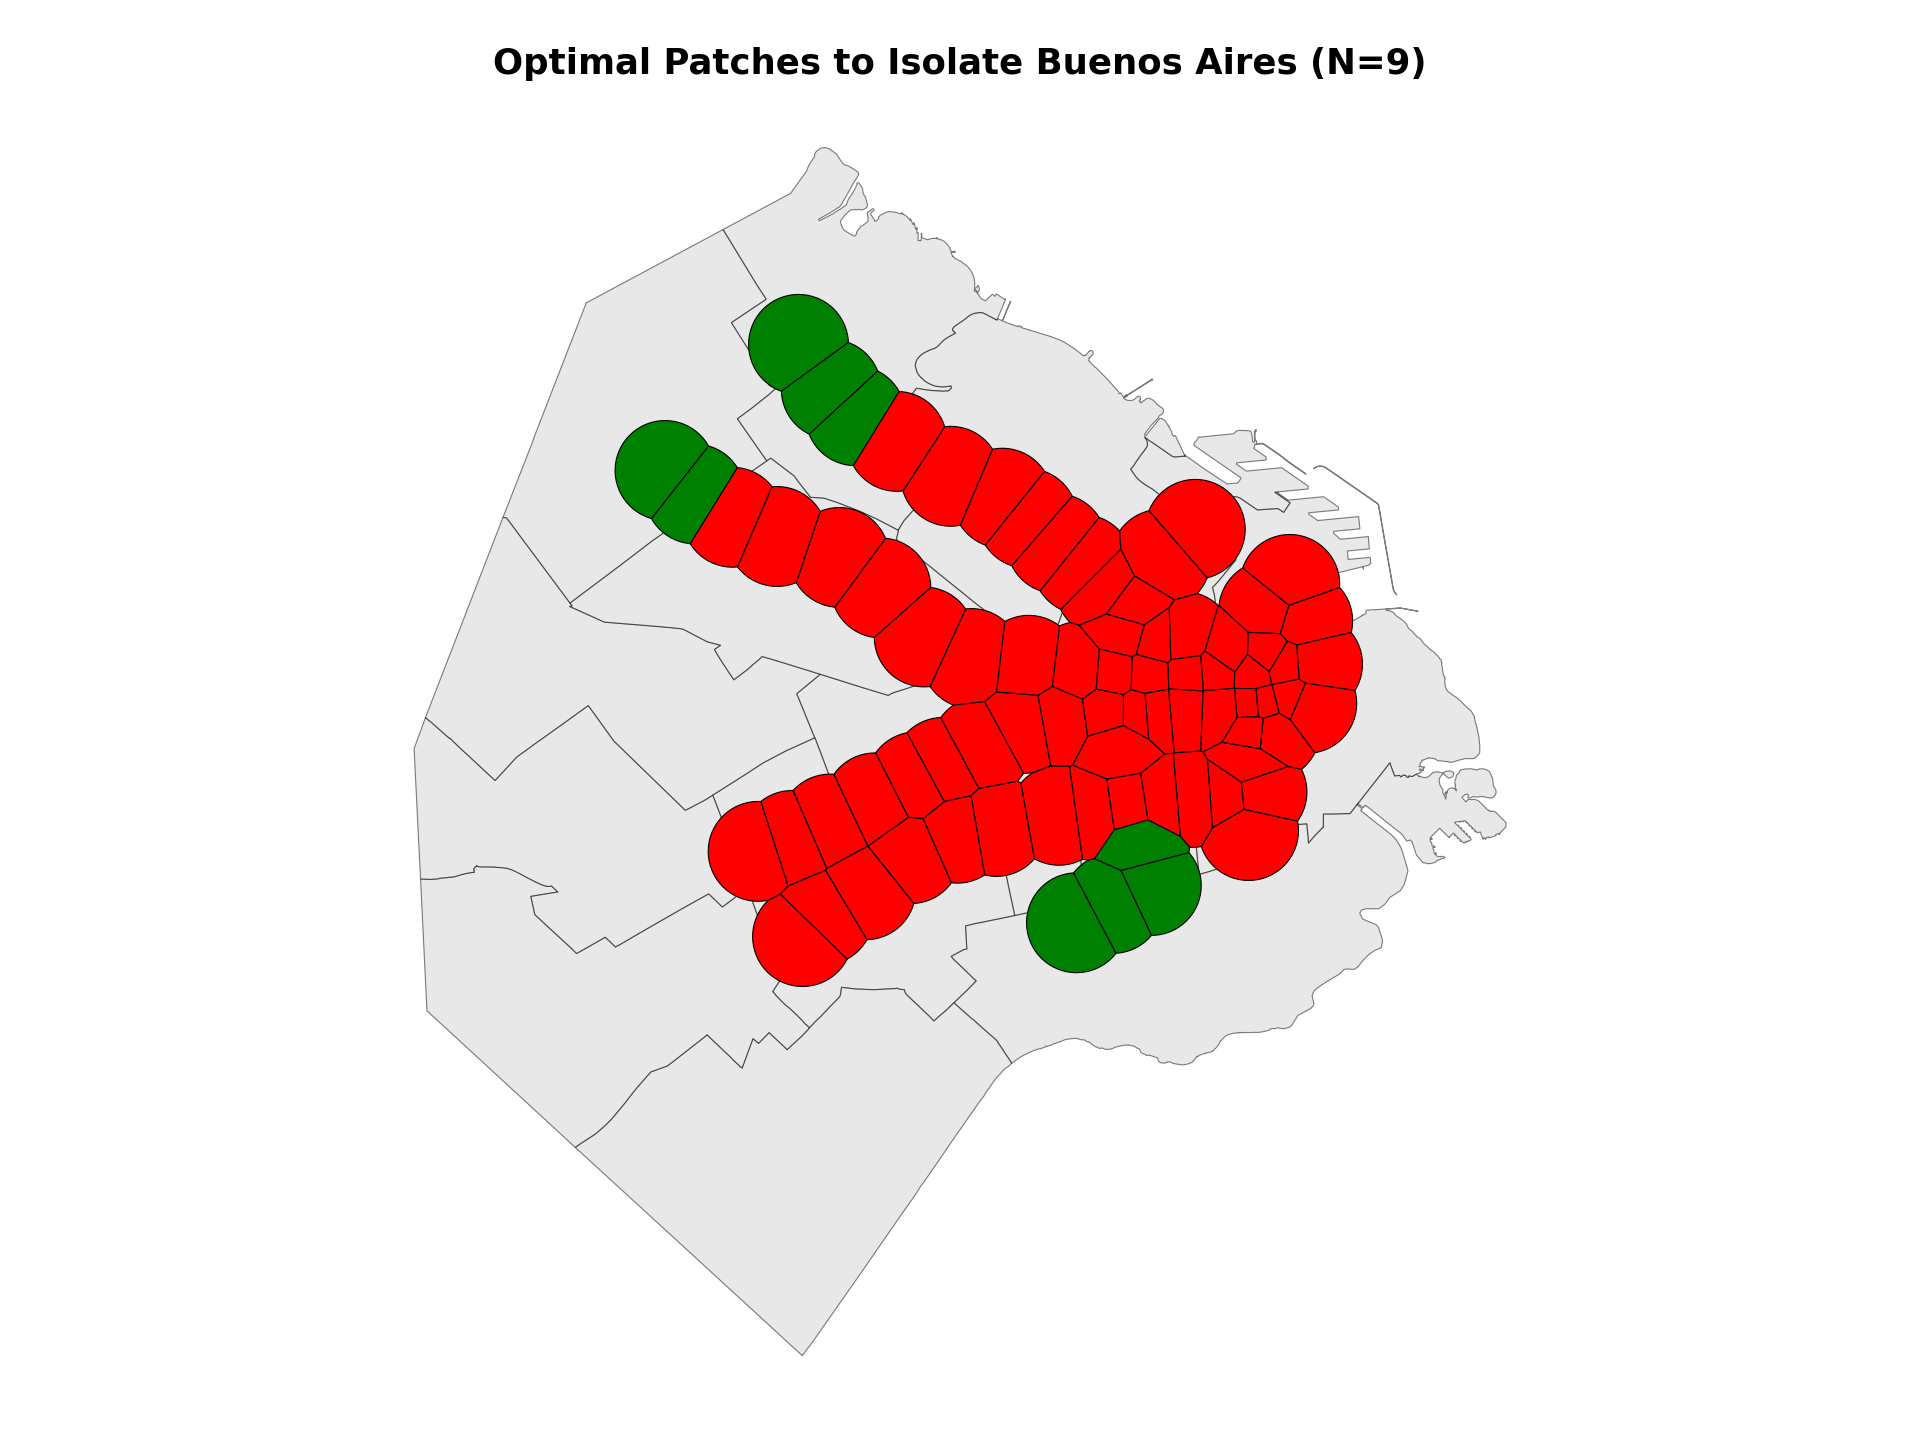

In [39]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pickle

with open("60 Day Take 2 14 Day Fitted Beta 14 Day Buffer 240 Days Total Buenos Aires Patch Isolation Effects.pkl", 'rb') as file:
    patch_isolation_effects = pickle.load(file)

selected_indices = top_n_indices.copy()  # example selected indices

def plot_selected_patches(selected_indices, title="Optimal Patches to Isolate Buenos Aires (N=9)"):
    voronoi_gdf = gpd.read_file("BA_Voronoi_File_1km.shp")
    boroughs_gdf = gpd.read_file("comunas.shp")

    voronoi_gdf = voronoi_gdf.to_crs(epsg=3857)
    boroughs_gdf = boroughs_gdf.to_crs(epsg=3857)

    # Robust color assignment
    colors = np.where(np.isin(np.arange(len(voronoi_gdf)), selected_indices), 'green', 'red')
    voronoi_gdf['color'] = colors

    fig, ax = plt.subplots(figsize=(12, 9))
    boroughs_gdf.plot(ax=ax, color="lightgray", edgecolor="black", linewidth=0.5, alpha=0.5)
    voronoi_gdf.plot(ax=ax, color=voronoi_gdf['color'], edgecolor="black", linewidth=0.5)

    ax.set_title(title, fontweight='bold', fontsize=16)
    ax.axis("off")
    plt.tight_layout()
    plt.show()

plot_selected_patches(selected_indices)

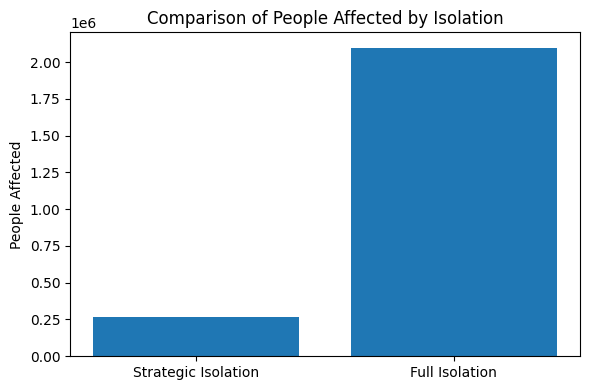

Strategic Isolation affects 268517 people.
Full Isolation affects 2096966 people.

Full Isolation affected 7.81 times more people.


In [140]:
with open("Fixed Final Commuter Matrix Buenos Aires.pkl", "rb") as file:
    p_populations = pickle.load(file)

p_populations *= np.sum(short_pop_vector)/np.sum(p_populations)

people_affected_by_isolation = []

for home in range(78):
    #home people going to work
    people = np.sum(p_populations[home])-p_populations[home][home]
    
    #people coming to work in home
    people += np.sum(p_populations.T[home])-p_populations[home][home]
    
    people_affected_by_isolation.append(people)
    
people_affected_by_isolation

people_affected_by_isolation = np.array(people_affected_by_isolation)

best_iso_affected_ppl = 0.9*np.sum(people_affected_by_isolation[np.array(top_n_indices)])

full_iso_affected_ppl = 0.9*np.sum(people_affected_by_isolation)

# Values
values = [best_iso_affected_ppl, full_iso_affected_ppl]
labels = ['Strategic Isolation', 'Full Isolation']

# Plot
plt.figure(figsize=(6,4))
plt.bar(labels, values)
plt.ylabel('People Affected')
plt.title('Comparison of People Affected by Isolation')
plt.tight_layout()
plt.show()

# Print statements
print(f"Strategic Isolation affects {best_iso_affected_ppl:.0f} people.")
print(f"Full Isolation affects {full_iso_affected_ppl:.0f} people.")
print(f"\nFull Isolation affected {np.round(full_iso_affected_ppl / best_iso_affected_ppl,2)} times more people.")



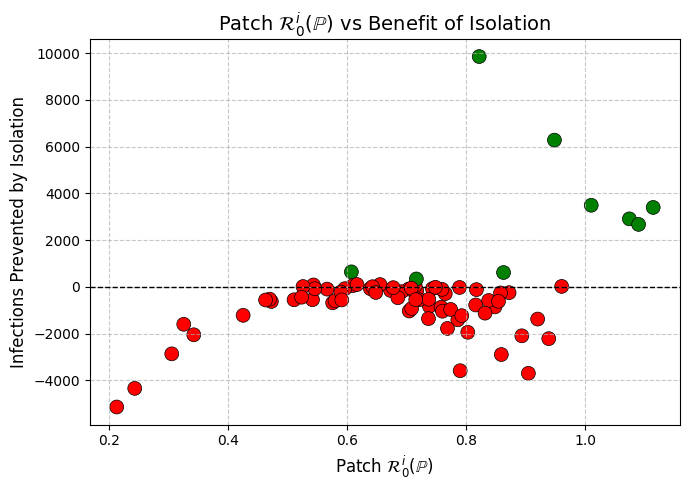

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize all red
colors = np.full(len(patch_R0s), 'red', dtype=object)
# Set top_n_indices to green
colors[top_n_indices] = 'green'

plt.figure(figsize=(7,5))
plt.scatter(patch_R0s, patch_isolation_benefits, c=colors, s=100, edgecolor='black', linewidth=0.5)
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # <-- added dashed line at y=0
plt.xlabel(r'Patch $\mathcal{R}_0^i(\mathbb{P})$', fontsize=12)
plt.ylabel('Infections Prevented by Isolation', fontsize=12)
plt.title(r'Patch $\mathcal{R}_0^i(\mathbb{P})$ vs Benefit of Isolation', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


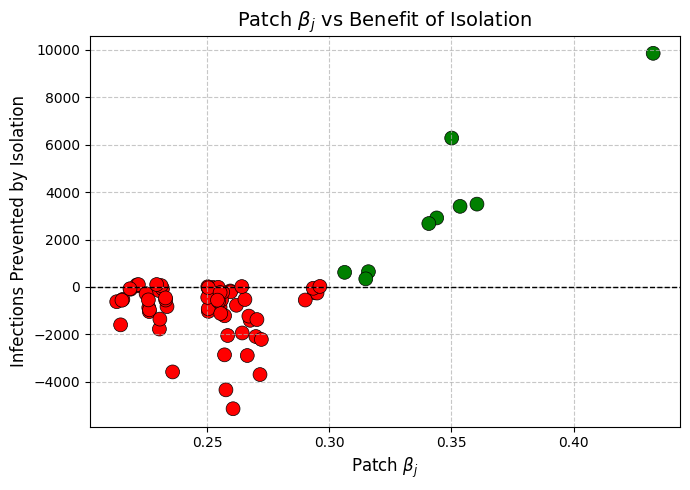

In [17]:
plt.figure(figsize=(7,5))
colors = np.full(len(home_betas), 'red', dtype=object)
colors[top_n_indices] = 'green'

plt.scatter(home_betas, patch_isolation_benefits, c=colors, s=100, edgecolor='black', linewidth=0.5)
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # <-- added dashed line at y=0
plt.xlabel(r'Patch $\beta_j$', fontsize=12)
plt.ylabel('Infections Prevented by Isolation', fontsize=12)
plt.title(r'Patch $\beta_j$ vs Benefit of Isolation', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


<IPython.core.display.Javascript object>


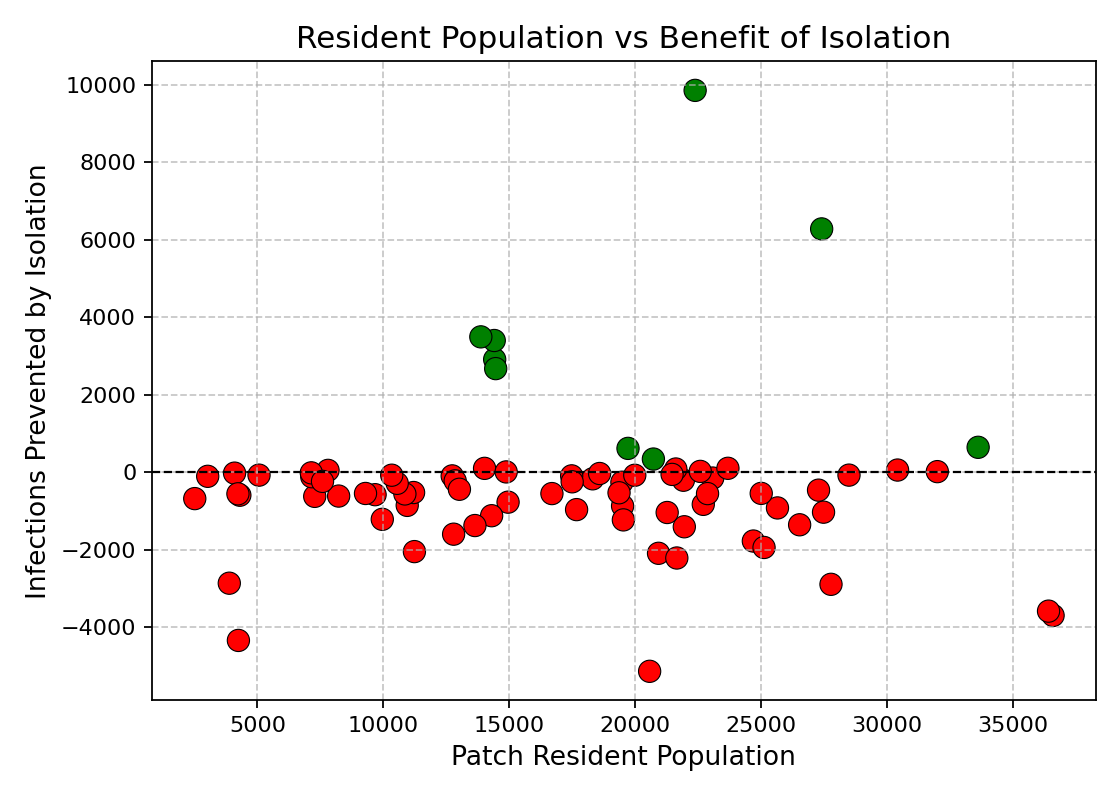

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize all red
colors = np.full(len(short_pop_vector), 'red', dtype=object)
# Set top_n_indices to green
colors[top_n_indices] = 'green'

plt.figure(figsize=(7,5))
plt.scatter(short_pop_vector, patch_isolation_benefits, c=colors, s=100, edgecolor='black', linewidth=0.5)
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # dashed line at y=0
plt.xlabel('Patch Resident Population', fontsize=12)
plt.ylabel('Infections Prevented by Isolation', fontsize=12)
plt.title('Resident Population vs Benefit of Isolation', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


<IPython.core.display.Javascript object>


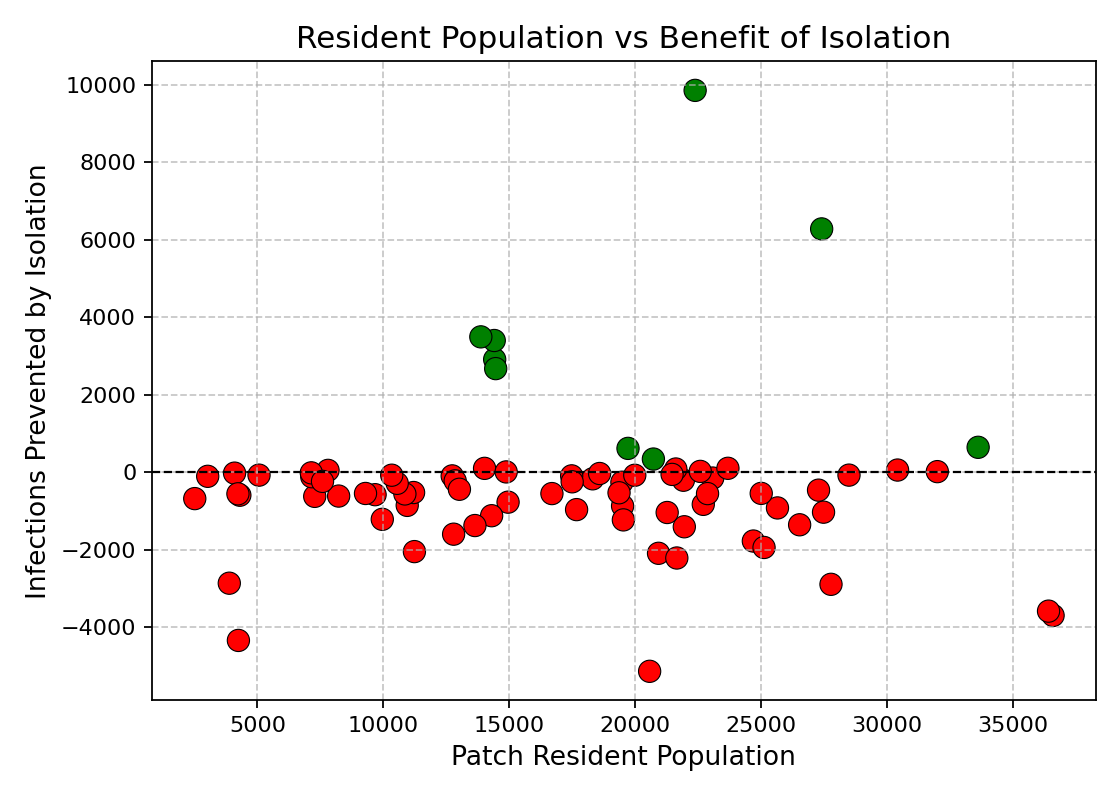

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize all red
colors = np.full(len(short_pop_vector), 'red', dtype=object)
# Set top_n_indices to green
colors[top_n_indices] = 'green'

plt.figure(figsize=(7,5))
plt.scatter(short_pop_vector, patch_isolation_benefits, c=colors, s=100, edgecolor='black', linewidth=0.5)
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # dashed line at y=0
plt.xlabel('Patch Resident Population', fontsize=12)
plt.ylabel('Infections Prevented by Isolation', fontsize=12)
plt.title('Resident Population vs Benefit of Isolation', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


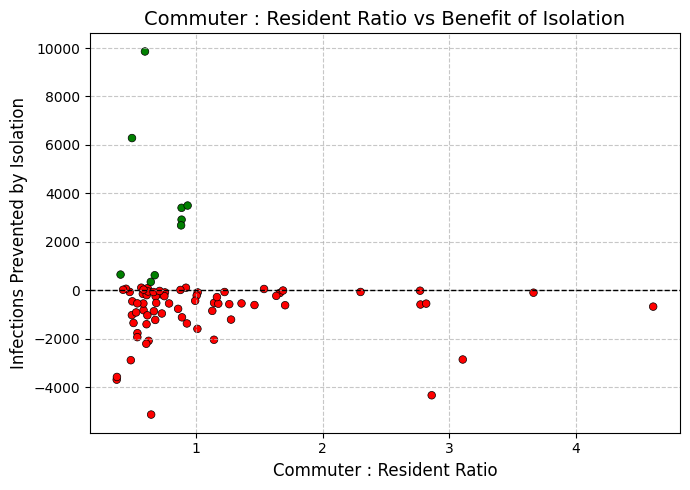

In [64]:
with open("Fixed Final Commuter Matrix Buenos Aires.pkl",'rb') as file:
    p_populations = pickle.load(file)
    
commuters_vs_residents = []
for i in range(78):
    residents = np.sum(p_populations[i])
    col_sum = np.sum(p_populations.T[i])
    commuters = col_sum - p_populations[i][i]
    commuters_vs_residents.append(commuters/residents)
commuters_vs_residents = np.array(commuters_vs_residents)

import matplotlib.pyplot as plt
import numpy as np

# Initialize all red
colors = np.full(len(commuters_vs_residents), 'red', dtype=object)
# Set top_n_indices to green
colors[top_n_indices] = 'green'

plt.figure(figsize=(7,5))
plt.scatter(commuters_vs_residents, patch_isolation_benefits, c=colors, s=30, edgecolor='black', linewidth=0.5)
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # dashed line at y=0
plt.xlabel('Commuter : Resident Ratio', fontsize=12)
plt.ylabel('Infections Prevented by Isolation', fontsize=12)
plt.title('Commuter : Resident Ratio vs Benefit of Isolation', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


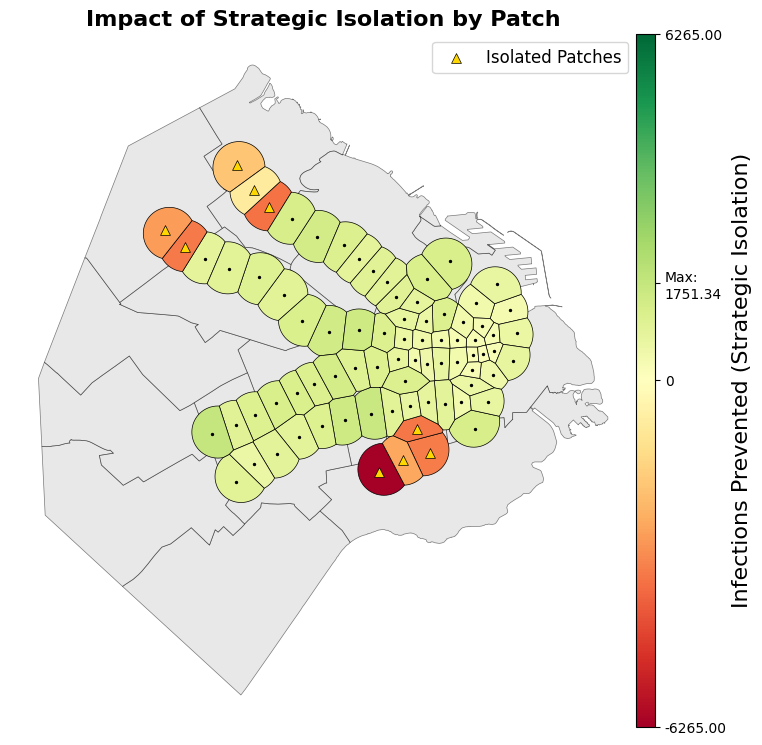

In [86]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pickle
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Assume 'solution', 'solution_best_iso', 'solution_full_iso', 'home_patches', and 'top_n_indices' are already loaded

# Compute improvement
original_ending = solution[2][home_patches].T[-1]
best_iso_ending = solution_best_iso[2][home_patches].T[-1]
full_iso_ending = solution_full_iso[2][home_patches].T[-1]

best_iso_patch_improvement = original_ending - best_iso_ending

# Load shapefiles
voronoi_gdf = gpd.read_file("BA_Voronoi_File_1km.shp")
boroughs_gdf = gpd.read_file("comunas.shp")

voronoi_gdf = voronoi_gdf.to_crs(epsg=3857)
boroughs_gdf = boroughs_gdf.to_crs(epsg=3857)

# Add improvement values
if len(best_iso_patch_improvement) < len(voronoi_gdf):
    best_iso_patch_improvement = np.concatenate(
        [best_iso_patch_improvement, np.zeros(len(voronoi_gdf) - len(best_iso_patch_improvement))]
    )
voronoi_gdf["effects"] = best_iso_patch_improvement

# Plot
fig, ax = plt.subplots(figsize=(12, 9))
boroughs_gdf.plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=0.5, alpha=0.5)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0)

vmin_raw = voronoi_gdf.loc[voronoi_gdf["effects"] != 0, "effects"].min()
vmax_raw = voronoi_gdf.loc[voronoi_gdf["effects"] != 0, "effects"].max()
abs_max = max(abs(vmin_raw), abs(vmax_raw))
vmin, vmax = -abs_max, abs_max

norm = mcolors.TwoSlopeNorm(vcenter=0, vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap="RdYlGn", norm=norm)
sm.set_array([])

# Nonzero patches
nonzero = voronoi_gdf["effects"] != 0
voronoi_gdf[nonzero].plot(
    ax=ax,
    column="effects",
    cmap="RdYlGn",
    norm=norm,
    edgecolor="black",
    linewidth=0.5,
    alpha=1,
)

# Zero patches
if (~nonzero).any():
    voronoi_gdf[~nonzero].plot(
        ax=ax,
        color="gray",
        edgecolor="black",
        linewidth=0.5,
        alpha=1,
    )

# Colorbar
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label("Infections Prevented (Strategic Isolation)", fontsize=16)

ticks = [vmin, 0, vmax]
tick_labels = [f"{vmin:.2f}", "0", f"{vmax:.2f}"]

# Add raw vmin if it differs significantly
if np.abs(vmin_raw - vmin) > 1e-5:
    ticks.insert(0, vmin_raw)
    tick_labels.insert(0, f"Min:\n{vmin_raw:.2f}")

# Add raw vmax if it differs significantly
if np.abs(vmax_raw - vmax) > 1e-5:
    ticks.append(vmax_raw)
    tick_labels.append(f"Max:\n{vmax_raw:.2f}")

cbar.set_ticks(ticks)
cbar.ax.set_yticklabels(tick_labels)
# Centroids
voronoi_centroids = voronoi_gdf.centroid
voronoi_centroids = gpd.GeoSeries(voronoi_centroids, crs="EPSG:3857")

# Split top_n_indices vs others
top_n_centroids = voronoi_centroids.iloc[top_n_indices]
other_centroids = voronoi_centroids.drop(index=top_n_indices)

# Plot other centroids (black dots)
other_centroids.plot(ax=ax, color="black", markersize=2)

# Plot top_n centroids (gold triangles)
ax.scatter(
    top_n_centroids.x, top_n_centroids.y,
    color="gold", marker="^", s=50, edgecolor="black", linewidth=0.5
)

# Add legend for isolated patches
ax.scatter([], [], color="gold", marker="^", s=50, edgecolor="black", linewidth=0.5, label="Isolated Patches")
ax.legend(loc="upper right", fontsize=12, frameon=True)


ax.set_title("Impact of Strategic Isolation by Patch", fontweight='bold', fontsize=16)
ax.axis("off")
plt.show()


In [19]:
# with open("60 Day Take 2 14 Day Fitted Beta 14 Day Buffer 240 Days Total Buenos Aires Patch Isolation Effects.pkl", "wb") as f:
    # pickle.dump(patch_isolation_benefits, f)
    
    

In [52]:
with open("Sparse Buenos Aires Expanded P Matrix.pkl", 'rb') as file:
    sparse_expanded_p_matrix = pickle.load(file)

expanded_p_matrix = sparse_expanded_p_matrix.toarray()

isolated_patches = top_n_indices.copy()
patch_station_names = get_patch_station_names(isolated_patches, station_list)
isolation_strength = 0.9
infection_sums = []
modified_expanded_p_matrix = sparse_expanded_p_matrix.copy()

for patch in tqdm(isolated_patches, desc="Isolating patches"):
    modified_expanded_p_matrix = full_sparse_isolate_ultrafast_csr(
                                                                    sparse_expanded_p_matrix,
                                                                    patch_station_names,
                                                                    station_to_rows,
                                                                    row_home_patches,
                                                                    modification=isolation_strength
                                                                ).toarray()



    
second_p_matrix = convert_back_to_classic_p(modified_expanded_p_matrix)
sparse_second_p = csr_matrix(second_p_matrix)


solution_best_iso, params_best_iso = plot_best_beta_vs_data_with_isolation(all_station_timeseries, pop_dict)

Isolating patches: 100%|██████████| 9/9 [00:01<00:00,  7.41it/s]


In [59]:
with open("Sparse Buenos Aires Expanded P Matrix.pkl", 'rb') as file:
    sparse_expanded_p_matrix = pickle.load(file)

expanded_p_matrix = sparse_expanded_p_matrix.toarray()

isolated_patches = range(78)
# isolated_patches = top_n_indices.copy()
patch_station_names = get_patch_station_names(isolated_patches, station_list)
isolation_strength = 0.9
infection_sums = []
modified_expanded_p_matrix = sparse_expanded_p_matrix.copy()

# Load precomputed fully isolated matrix
# with open("isolated_p_matrices_ba/isolated_p_matrix_full_isolation.pkl", "rb") as f:
    # sparse_second_p = pickle.load(f)
    
isolated_patches = range(78)
patch_station_names = get_patch_station_names(isolated_patches, station_list)
isolation_strength = 0.9
infection_sums = []
modified_expanded_p_matrix = sparse_expanded_p_matrix.copy()

for patch in tqdm(isolated_patches, desc="Isolating patches"):
    modified_expanded_p_matrix = full_sparse_isolate_ultrafast_csr(
                                                                    sparse_expanded_p_matrix,
                                                                    patch_station_names,
                                                                    station_to_rows,
                                                                    row_home_patches,
                                                                    modification=isolation_strength
                                                                ).toarray()
second_p_matrix = convert_back_to_classic_p(modified_expanded_p_matrix)
sparse_second_p = csr_matrix(second_p_matrix)


# Convert to dense if needed
# second_p_matrix = sparse_second_p.toarray()

solution_full_iso, params_full_iso = plot_best_beta_vs_data_with_isolation(all_station_timeseries, pop_dict)

Isolating patches: 100%|██████████| 78/78 [00:13<00:00,  5.64it/s]


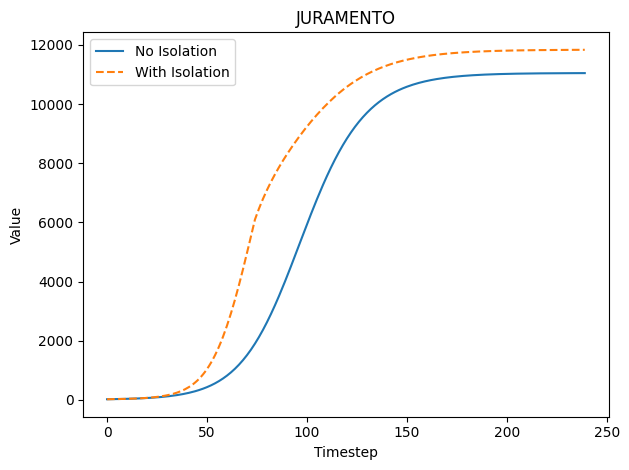

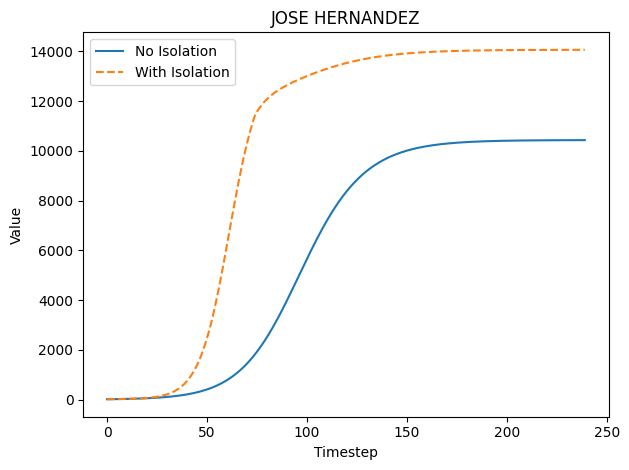

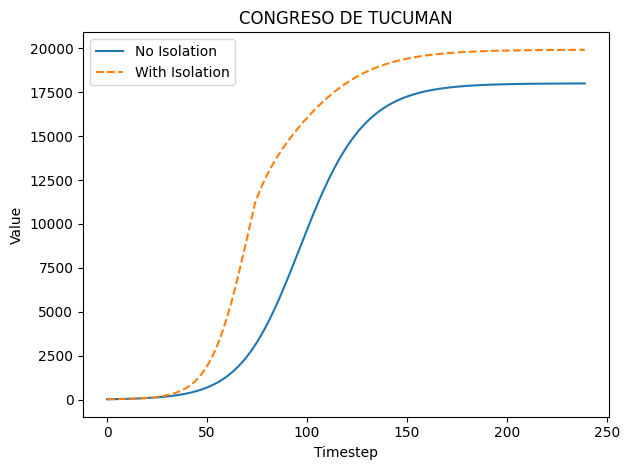

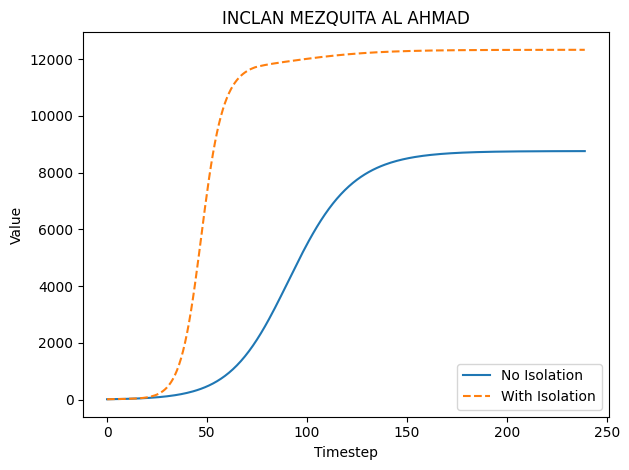

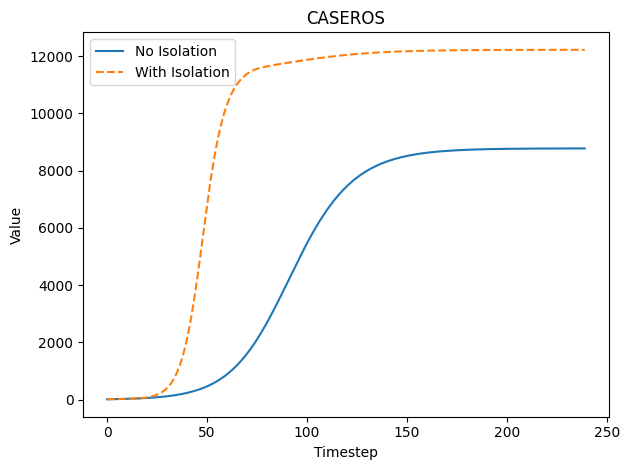

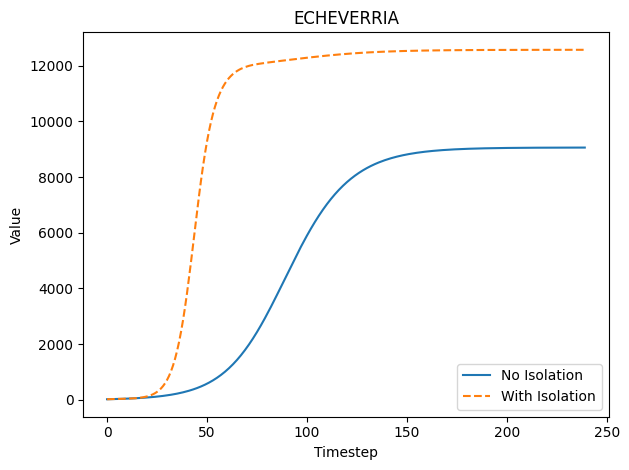

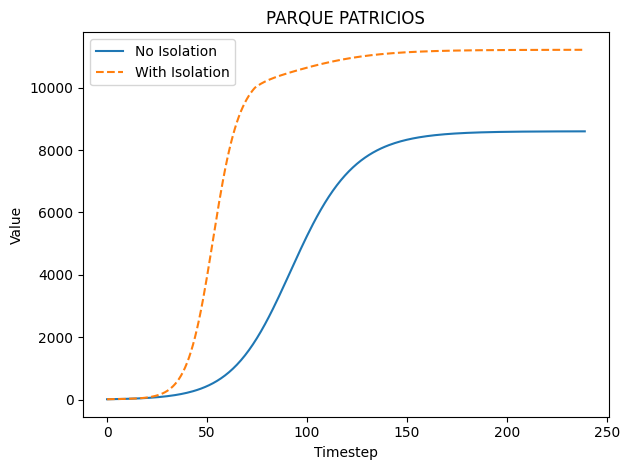

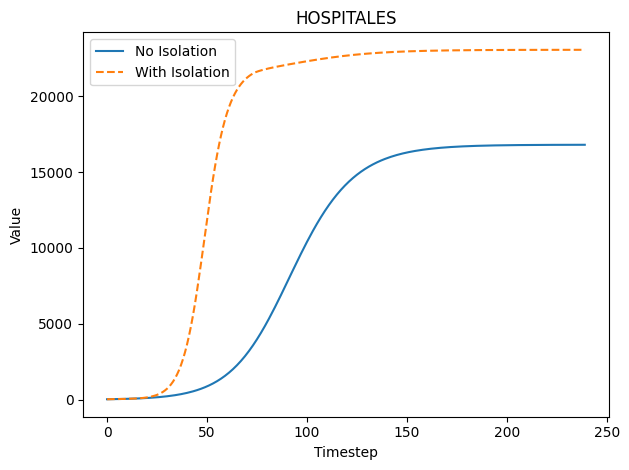

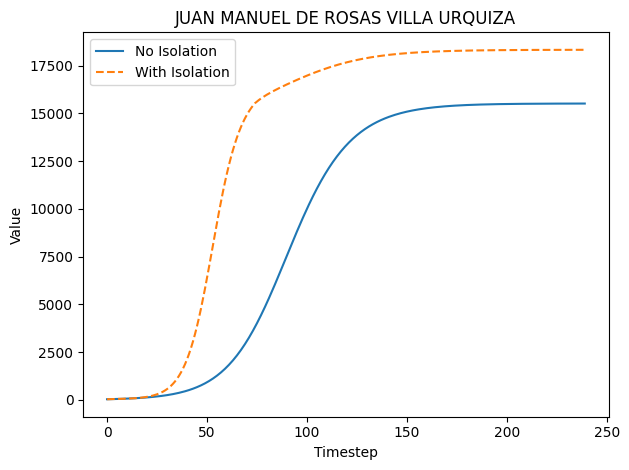

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Assume: both arrays are shaped (78, 16)
y1 = solution[2][home_patches]  # shape (78, 16)
y2 = solution_best_iso[2][home_patches]  # shape (78, 16)
timesteps = np.arange(solution.shape[2])

for i in top_n_indices:
    plt.figure()
    plt.plot(timesteps, y1[i], label='No Isolation')
    plt.plot(timesteps, y2[i], label='With Isolation', linestyle='--')
    plt.title(f'{station_list[i]}')
    plt.xlabel('Timestep')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [34]:
np.sum(np.array([[1,2,3],[1,2,3]]),axis=0)

array([2, 4, 6])

In [60]:
# Get populations at the given indices
selected_pops = short_pop_vector[top_n_indices]

# Get populations not at the given indices
all_indices = np.arange(len(short_pop_vector))
complement_indices = np.setdiff1d(all_indices, top_n_indices)
complement_pops = short_pop_vector[complement_indices]

# Calculate averages
mean_selected = np.mean(selected_pops)
mean_complement = np.mean(complement_pops)

print("Mean at selected indices:", mean_selected)
print("Mean at non-selected indices:", mean_complement)

Mean at selected indices: 20117.513981666667
Mean at non-selected indices: 16782.62459518841


In [102]:
y1_sum-y2_sum

array([     0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,     -0.5771636 ,
           -1.61344773,     -3.25236707,     -5.66542936,     -9.05667016,
          -13.66780098,    -19.78402497,    -27.74056972,    -37.9299767 ,
          -50.81017071,    -66.9133075 ,    -86.85536159,   -111.34636467,
         -141.20113537,   -177.35024838,   -220.85087041,   -272.89693858,
         -334.82796956,   -408.13556445,   -494.46641791,   -595.62035935,
         -713.54166885,   -850.30165194,  -1008.07027487,  -1189.0746242 ,
        -1395.54214869,  -1629.62717186,  -1893.32013511,  -2188.34053014,
        -2516.01653447,  -2857.87371774,  -3224.59005639,  -3616.73471812,
        -4034.90879958,  -4479.73715905,  -4951.85927627,  -5451.9190958 ,
        -5980.55380716,  

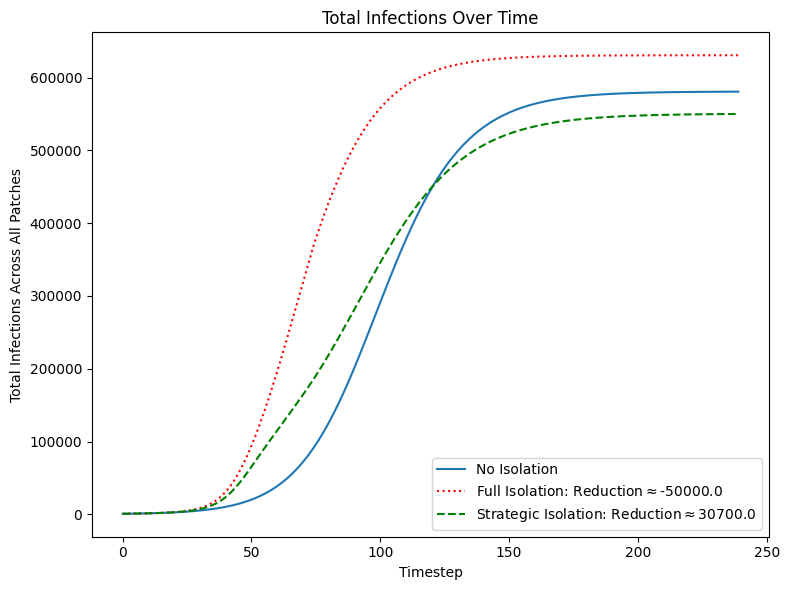

In [60]:
import matplotlib.pyplot as plt
import numpy as np

y1_sum = solution[2][home_patches].sum(axis=0)  # shape (16,)
y2_sum = solution_best_iso[2][home_patches].sum(axis=0)  # shape (16,)
y3_sum = solution_full_iso[2][home_patches].sum(axis=0)
timesteps = np.arange(solution.shape[2])

plt.figure(figsize=(8,6))
plt.plot(timesteps, y1_sum, label='No Isolation')
plt.plot(timesteps, y3_sum, label=f'Full Isolation: Reduction$\\approx${np.round(y1_sum[-1]-y3_sum[-1],-2)}', linestyle=':', color='red')

plt.plot(timesteps, y2_sum, label=f'Strategic Isolation: Reduction$\\approx${np.round(y1_sum[-1]-y2_sum[-1],-2)}', linestyle='--', color='green')
plt.xlabel('Timestep')
plt.ylabel('Total Infections Across All Patches')
plt.title('Total Infections Over Time')
plt.legend()
plt.tight_layout()
plt.show()


In [145]:
with open("Fixed Final Commuter Matrix Buenos Aires.pkl", "rb") as file:
    p_populations = pickle.load(file)

p_populations *= np.sum(short_pop_vector)/np.sum(p_populations)

people_affected_by_isolation = []

for home in range(78):
    #home people going to work
    people = np.sum(p_populations[home])-p_populations[home][home]
    
    #people coming to work in home
    people += np.sum(p_populations.T[home])-p_populations[home][home]
    
    people_affected_by_isolation.append(people)
    
people_affected_by_isolation = np.array(people_affected_by_isolation)

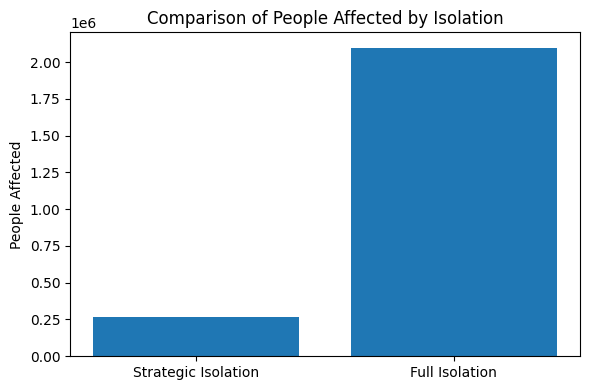

Strategic Isolation affects 268517 people.
Full Isolation affects 2096966 people.

Full Isolation affected 7.81 times more people.


In [146]:
best_iso_affected_ppl = 0.9*np.sum(people_affected_by_isolation[np.array(top_n_indices)])

full_iso_affected_ppl = 0.9*np.sum(people_affected_by_isolation)

# Values
values = [best_iso_affected_ppl, full_iso_affected_ppl]
labels = ['Strategic Isolation', 'Full Isolation']

# Plot
plt.figure(figsize=(6,4))
plt.bar(labels, values)
plt.ylabel('People Affected')
plt.title('Comparison of People Affected by Isolation')
plt.tight_layout()
plt.show()

# Print statements
print(f"Strategic Isolation affects {best_iso_affected_ppl:.0f} people.")
print(f"Full Isolation affects {full_iso_affected_ppl:.0f} people.")
print(f"\nFull Isolation affected {np.round(full_iso_affected_ppl / best_iso_affected_ppl,2)} times more people.")



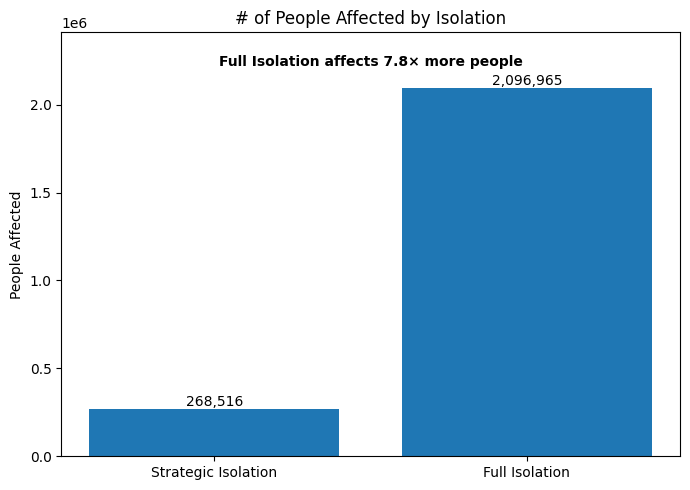

In [174]:
import matplotlib.pyplot as plt
import numpy as np

# Values
values = [best_iso_affected_ppl, full_iso_affected_ppl]
labels = ['Strategic Isolation', 'Full Isolation']

# Plot
plt.figure(figsize=(7,5))
bars = plt.bar(labels, values)
plt.ylabel('People Affected')
plt.title('# of People Affected by Isolation')

# Add text labels above bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
             f'{int(value):,}', ha='center', va='bottom', fontsize=10)

# Add ratio text separately
ratio = full_iso_affected_ppl / best_iso_affected_ppl
plt.text(0.5, max(values)*1.05, 
         f'Full Isolation affects {ratio:.1f}× more people', 
         ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.ylim(0, max(values)*1.15)  # add extra space for text
plt.tight_layout()
plt.show()


In [45]:
import geopandas as gpd
import numpy as np
import os
import tempfile
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from IPython.display import HTML
from datetime import timedelta, datetime
from tqdm import tqdm
import IPython
import base64

def embed_gif_base64(gif_path):
    with open(gif_path, "rb") as f:
        gif_data = f.read()
    b64_gif = base64.b64encode(gif_data).decode("utf-8")
    return HTML(f'<img src="data:image/gif;base64,{b64_gif}" style="display:block;margin:0 auto;" autoplay loop>')


# Load Buenos Aires Voronoi and borough data
station_gdf = gpd.read_file("BA_Voronoi_File_1km.shp")
# Ensure CRS consistency
borough_gdf = gpd.read_file("comunas.shp")
station_gdf = station_gdf.to_crs(epsg=3857)  
borough_gdf = borough_gdf.to_crs(epsg=3857)

pop_array = np.array(list(pop_dict.values()))

def create_voronoi_gif_ba(solution, params, pop_array, label_mode="number"):
    """
    Generates a GIF of the Buenos Aires disease spread simulation using Voronoi coloring 
    while maintaining black station dots, ensuring boroughs are drawn behind. Includes a label at the top.

    Parameters:
    - solution: The output of the disease model simulation.
    - params: Model parameters including timesteps.
    - pop_array: Population array for normalization.
    - label_mode: "date" (MM/DD/YYYY format) or "number" (time index).
    """
    output_filename = "buenos_aires_voronoi_disease.gif"

    # Extract station data and normalize by population
    map_data = solution
    station_data = map_data[1][home_patches]
    
    num_timesteps = station_data.shape[1]
    for i in range(len(station_data)):
        station_data[i] = station_data[i] / pop_array[i]


    # Define start date for label_mode="date"
    start_date = datetime(2020, 4, 5)

    # Temporary storage for frames
    with tempfile.TemporaryDirectory() as temp_dir:
        frames = []

        # Progress bar
        for t in tqdm(range(num_timesteps), desc="Generating Frames", unit="frame"):
            # Normalize the color values for better colormap utilization
            color_values = station_data[:, t]
            color_min, color_max = np.nanmin(color_values), np.nanmax(color_values)

            # Avoid division by zero if all values are the same
            if color_max > color_min:
                station_gdf["color"] = (color_values - color_min) / (color_max - color_min)
            else:
                station_gdf["color"] = 0.5  # Set to mid-range if all values are identical

            # Create figure with increased size
            fig, ax = plt.subplots(figsize=(10, 10))

            # Plot boroughs first (grey background, borders retained)
            borough_gdf.plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=0.5, alpha=0.5)

            # Plot Voronoi regions with edges
            station_gdf.plot(ax=ax, column="color", cmap="plasma", edgecolor="black", linewidth=0.5, alpha=1)
            
            # Plot stations as black dots
            # station_gdf.centroid.plot(ax=ax, color="black", markersize=1)
            station_gdf["centroid"] = station_gdf.geometry.centroid  # Compute centroids
            station_gdf["centroid"] = station_gdf["centroid"].to_crs(epsg=3857)  # Ensure projected CRS
            station_gdf["centroid"].plot(ax=ax, color="black", markersize=1)  # Plot centroids


            # Generate label text
            if label_mode == "date":
                label_text = (start_date + timedelta(days=t)).strftime("%m/%d/%Y")
            else:
                label_text = f"t = {t}"

            # Add label at the top
            plt.text(0.5, 1.02, label_text, transform=ax.transAxes, fontsize=16, ha="center", va="bottom", fontweight="bold")

            # Save frame
            temp_filepath = os.path.join(temp_dir, f"frame_{t}.png")
            # Remove axis and save tightly cropped frame
            ax.set_axis_off()
            plt.savefig(temp_filepath, bbox_inches='tight', pad_inches=0)
            plt.close(fig)  # Free memory

            frames.append(imageio.imread(temp_filepath))

        # Create GIF
        print("Creating GIF...")
        imageio.mimsave(output_filename, frames, duration=3.0, loop=0)
        IPython.display.clear_output(wait=True)
    return HTML(f'<img src="{output_filename}" style="display:block;margin:0 auto;" loop="infinite" autoplay>')


# Example usage:
create_voronoi_gif_ba(solution, params, pop_array, label_mode="date")


In [15]:
import geopandas as gpd
import numpy as np
import os
import tempfile
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from IPython.display import HTML
from datetime import timedelta, datetime
from tqdm import tqdm
import IPython
import base64

def embed_gif_base64(gif_path):
    with open(gif_path, "rb") as f:
        gif_data = f.read()
    b64_gif = base64.b64encode(gif_data).decode("utf-8")
    return HTML(f'<img src="data:image/gif;base64,{b64_gif}" style="display:block;margin:0 auto;" autoplay loop>')


# Load Buenos Aires Voronoi and borough data
station_gdf = gpd.read_file("BA_Voronoi_File_1km.shp")
# Ensure CRS consistency
borough_gdf = gpd.read_file("comunas.shp")
station_gdf = station_gdf.to_crs(epsg=3857)  
borough_gdf = borough_gdf.to_crs(epsg=3857)

pop_array = np.array(list(pop_dict.values()))

def create_voronoi_gif_ba(solution, params, pop_array, label_mode="number"):
    """
    Generates a GIF of the Buenos Aires disease spread simulation using Voronoi coloring 
    while maintaining black station dots, ensuring boroughs are drawn behind. Includes a label at the top.

    Parameters:
    - solution: The output of the disease model simulation.
    - params: Model parameters including timesteps.
    - pop_array: Population array for normalization.
    - label_mode: "date" (MM/DD/YYYY format) or "number" (time index).
    """
    output_filename = "buenos_aires_voronoi_disease_best_iso.gif"

    # Extract station data and normalize by population
    map_data = solution
    station_data = map_data[1][home_patches]
    
    num_timesteps = station_data.shape[1]
    for i in range(len(station_data)):
        station_data[i] = station_data[i] / pop_array[i]


    # Define start date for label_mode="date"
    start_date = datetime(2020, 4, 5)

    # Temporary storage for frames
    with tempfile.TemporaryDirectory() as temp_dir:
        frames = []

        # Progress bar
        for t in tqdm(range(num_timesteps), desc="Generating Frames", unit="frame"):
            # Normalize the color values for better colormap utilization
            color_values = station_data[:, t]
            color_min, color_max = np.nanmin(color_values), np.nanmax(color_values)

            # Avoid division by zero if all values are the same
            if color_max > color_min:
                station_gdf["color"] = (color_values - color_min) / (color_max - color_min)
            else:
                station_gdf["color"] = 0.5  # Set to mid-range if all values are identical

            # Create figure with increased size
            fig, ax = plt.subplots(figsize=(10, 10))

            # Plot boroughs first (grey background, borders retained)
            borough_gdf.plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=0.5, alpha=0.5)

            # Plot Voronoi regions with edges
            station_gdf.plot(ax=ax, column="color", cmap="plasma", edgecolor="black", linewidth=0.5, alpha=1)
            
            # Plot stations as black dots
            # station_gdf.centroid.plot(ax=ax, color="black", markersize=1)
            station_gdf["centroid"] = station_gdf.geometry.centroid  # Compute centroids
            station_gdf["centroid"] = station_gdf["centroid"].to_crs(epsg=3857)  # Ensure projected CRS
            station_gdf["centroid"].plot(ax=ax, color="black", markersize=1)  # Plot centroids


            # Generate label text
            if label_mode == "date":
                label_text = (start_date + timedelta(days=t)).strftime("%m/%d/%Y")
            else:
                label_text = f"t = {t}"

            # Add label at the top
            plt.text(0.5, 1.02, label_text, transform=ax.transAxes, fontsize=16, ha="center", va="bottom", fontweight="bold")

            # Save frame
            temp_filepath = os.path.join(temp_dir, f"frame_{t}.png")
            # Remove axis and save tightly cropped frame
            ax.set_axis_off()
            plt.savefig(temp_filepath, bbox_inches='tight', pad_inches=0)
            plt.close(fig)  # Free memory

            frames.append(imageio.imread(temp_filepath))

        # Create GIF
        print("Creating GIF...")
        imageio.mimsave(output_filename, frames, duration=3.0, loop=0)
        IPython.display.clear_output(wait=True)
    return HTML(f'<img src="{output_filename}" style="display:block;margin:0 auto;" loop="infinite" autoplay>')


# Example usage:
create_voronoi_gif_ba(solution_with_iso, params_with_iso, pop_array, label_mode="date")


In [27]:
import geopandas as gpd
import numpy as np
import os
import tempfile
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from IPython.display import HTML
from datetime import timedelta, datetime
from tqdm import tqdm
import IPython
import base64

def embed_gif_base64(gif_path):
    with open(gif_path, "rb") as f:
        gif_data = f.read()
    b64_gif = base64.b64encode(gif_data).decode("utf-8")
    return HTML(f'<img src="data:image/gif;base64,{b64_gif}" style="display:block;margin:0 auto;" autoplay loop>')


# Load Buenos Aires Voronoi and borough data
station_gdf = gpd.read_file("BA_Voronoi_File_1km.shp")
# Ensure CRS consistency
borough_gdf = gpd.read_file("comunas.shp")
station_gdf = station_gdf.to_crs(epsg=3857)  
borough_gdf = borough_gdf.to_crs(epsg=3857)

pop_array = np.array(list(pop_dict.values()))

def create_voronoi_gif_ba(solution, params, pop_array, label_mode="number"):
    """
    Generates a GIF of the Buenos Aires disease spread simulation using Voronoi coloring 
    while maintaining black station dots, ensuring boroughs are drawn behind. Includes a label at the top.

    Parameters:
    - solution: The output of the disease model simulation.
    - params: Model parameters including timesteps.
    - pop_array: Population array for normalization.
    - label_mode: "date" (MM/DD/YYYY format) or "number" (time index).
    """
    output_filename = "buenos_aires_voronoi_disease_full_iso.gif"

    # Extract station data and normalize by population
    map_data = solution
    station_data = map_data[1][home_patches]
    
    num_timesteps = station_data.shape[1]
    for i in range(len(station_data)):
        station_data[i] = station_data[i] / pop_array[i]


    # Define start date for label_mode="date"
    start_date = datetime(2020, 4, 5)

    # Temporary storage for frames
    with tempfile.TemporaryDirectory() as temp_dir:
        frames = []

        # Progress bar
        for t in tqdm(range(num_timesteps), desc="Generating Frames", unit="frame"):
            # Normalize the color values for better colormap utilization
            color_values = station_data[:, t]
            color_min, color_max = np.nanmin(color_values), np.nanmax(color_values)

            # Avoid division by zero if all values are the same
            if color_max > color_min:
                station_gdf["color"] = (color_values - color_min) / (color_max - color_min)
            else:
                station_gdf["color"] = 0.5  # Set to mid-range if all values are identical

            # Create figure with increased size
            fig, ax = plt.subplots(figsize=(10, 10))

            # Plot boroughs first (grey background, borders retained)
            borough_gdf.plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=0.5, alpha=0.5)

            # Plot Voronoi regions with edges
            station_gdf.plot(ax=ax, column="color", cmap="plasma", edgecolor="black", linewidth=0.5, alpha=1)
            
            # Plot stations as black dots
            # station_gdf.centroid.plot(ax=ax, color="black", markersize=1)
            station_gdf["centroid"] = station_gdf.geometry.centroid  # Compute centroids
            station_gdf["centroid"] = station_gdf["centroid"].to_crs(epsg=3857)  # Ensure projected CRS
            station_gdf["centroid"].plot(ax=ax, color="black", markersize=1)  # Plot centroids


            # Generate label text
            if label_mode == "date":
                label_text = (start_date + timedelta(days=t)).strftime("%m/%d/%Y")
            else:
                label_text = f"t = {t}"

            # Add label at the top
            plt.text(0.5, 1.02, label_text, transform=ax.transAxes, fontsize=16, ha="center", va="bottom", fontweight="bold")

            # Save frame
            temp_filepath = os.path.join(temp_dir, f"frame_{t}.png")
            # Remove axis and save tightly cropped frame
            ax.set_axis_off()
            plt.savefig(temp_filepath, bbox_inches='tight', pad_inches=0)
            plt.close(fig)  # Free memory

            frames.append(imageio.imread(temp_filepath))

        # Create GIF
        print("Creating GIF...")
        imageio.mimsave(output_filename, frames, duration=3.0, loop=0)
        IPython.display.clear_output(wait=True)
    return HTML(f'<img src="{output_filename}" style="display:block;margin:0 auto;" loop="infinite" autoplay>')


# Example usage:
create_voronoi_gif_ba(solution_full_iso, params_full_iso, pop_array, label_mode="date")


In [164]:
def sparse_get_associated_indices(station_idx):
    station_name = station_list[station_idx]
    associated_indices = []
    associated_homes = []
    for i in range(9):
        if station_name in pairs_list[i]:
            associated_indices.append(i)
            associated_homes.append(home_patches[station_list.index(pairs_list[i][0])])
    return associated_indices, associated_homes

def sparse_isolate_patch(sparse_expanded_p_matrix, patch_idx, modification):
    from scipy.sparse import lil_matrix

    new_p = sparse_expanded_p_matrix.copy().tolil()  # stay sparse throughout
    changing_rows, home_indices = get_associated_indices(patch_idx)
    print(changing_rows, home_indices)

    for idx in tqdm(range(len(changing_rows)), desc="Isolating Patch"):
        row = changing_rows[idx]
        home = home_indices[idx]
        row_data = new_p.rows[row], new_p.data[row]

        # Scale all nonzero entries
        for i in range(len(row_data[1])):
            row_data[1][i] *= 1 - modification

        # Find the sum after scaling
        row_total = sum(row_data[1])

        # Find the original total (before scaling)
        original_total = sum(sparse_expanded_p_matrix.getrow(row).data)

        # Correct the home index
        found = False
        for idx_in_row, col_idx in enumerate(row_data[0]):
            if col_idx == home:
                row_data[1][idx_in_row] += original_total - row_total
                found = True
                break
        if not found:
            # If home wasn't in original nonzeros, add it
            new_p[row, home] = original_total - row_total

    return new_p.tocsr()


def get_associated_indices(station_idx):
    station_name = station_list[station_idx]
    associated_indices = []
    associated_homes = []
    mode = "everyone"
    
    for i in range(9):
        if station_name in pairs_list[i]:
            home_idx = home_patches[station_list.index(pairs_list[i][0])]
            if mode == "workers only":
                if home_patches[station_idx] != home_idx:
                    associated_indices.append(i)
                    associated_homes.append(home_idx)
            else:
                associated_indices.append(i)
                associated_homes.append(home_idx)
    return associated_indices,associated_homes

def isolate_patch(expanded_p_matrix,patch_idx,modification):
    new_p = expanded_p_matrix.copy()
    important_indices = get_associated_indices(patch_idx)
    changing_rows = important_indices[0]
    home_indices = important_indices[1]
    for idx in range(len(changing_rows)):
        row = changing_rows[idx]
        home = home_indices[idx]
        row_total = np.sum(new_p[row])
        new_p[row] *= 1-modification
        new_p[row][home] += row_total - np.sum(new_p[row])
    
    return new_p

def convert_back_to_classic_p(fourth_phase):
    fifth_phase = np.zeros((9,9))

    for i in range(9):
        connection = connections_list[i]
        home_patch = connection[0]
        home_index = connections_list.index((home_patch,home_patch))
        fifth_phase[home_index] += fourth_phase[i]

    sixth_phase = np.zeros((9,9))

    for i in range(9):
        if np.sum(fifth_phase[i]) != 0:
            sixth_phase[i] = fifth_phase[i]/np.sum(fifth_phase[i])
        else:
            sixth_phase[i][i] = 1
    
    return sixth_phase


In [165]:
import numpy as np
from scipy.sparse import lil_matrix, csr_matrix

def full_sparse_isolate(sparse_expanded_p_matrix, patch_indices, station_list, pairs_list, home_patches, modification=0.9):
    # Precompute lookup
    station_to_indices_homes = {}
    for i in range(9):
        pair = pairs_list[i]
        for station in pair:
            if station not in station_to_indices_homes:
                station_to_indices_homes[station] = ([], [])
            station_to_indices_homes[station][0].append(i)
            station_to_indices_homes[station][1].append(home_patches[station_list.index(pair[0])])

    # Build total set of affected rows and homes
    changing_rows = []
    home_indices = []
    for patch_idx in patch_indices:
        station_name = station_list[patch_idx]
        associated = station_to_indices_homes.get(station_name, ([], []))
        changing_rows.extend(associated[0])
        home_indices.extend(associated[1])

    # Now apply all changes
    new_p = sparse_expanded_p_matrix.copy().tolil()
    for idx in range(len(changing_rows)):
        row = changing_rows[idx]
        home = home_indices[idx]
        row_data = new_p.rows[row], new_p.data[row]

        for i in range(len(row_data[1])):
            row_data[1][i] *= 1 - modification

        row_total = sum(row_data[1])
        original_total = sum(sparse_expanded_p_matrix.getrow(row).data)

        found = False
        for idx_in_row, col_idx in enumerate(row_data[0]):
            if col_idx == home:
                row_data[1][idx_in_row] += original_total - row_total
                found = True
                break
        if not found:
            new_p[row, home] = original_total - row_total

    return new_p.tocsr()

modified_sparse = full_sparse_isolate(
    sparse_expanded_p_matrix,
    patch_indices=[1],
    station_list=station_list,
    pairs_list=pairs_list,
    home_patches=home_patches,
    modification=0.9
)


modified_sparse.toarray()

array([[1345.2709    ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [  13.4790929 ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   8.19027465,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,   30.48144931],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    1.83627333],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        , 1351.2195    ]])

In [96]:
np.sum(expanded_p_matrix,axis=1)

array([300., 200., 100., 200., 300., 190., 100., 190., 300.])

In [275]:
get_associated_indices(2)

([2, 5], [0, 4])

array([500., 300., 200.,  45., 180.,  75.,  10.,  20.,  70.])

In [147]:
np.round((tspent.T*workpops).T,2)

array([[500.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ],
       [175.  ,  12.5 ,   0.  ,  12.5 , 100.  ,   0.  ,   0.  ,   0.  ,
          0.  ],
       [ 83.33,   8.33,   0.  ,   8.33,   0.  ,  16.67,   0.  ,  16.67,
         66.67],
       [ 15.  ,   1.88,   0.  ,   1.88,  26.25,   0.  ,   0.  ,   0.  ,
          0.  ],
       [  0.  ,   0.  ,   0.  ,   0.  , 180.  ,   0.  ,   0.  ,   0.  ,
          0.  ],
       [  0.  ,   0.  ,   0.  ,   0.  ,  37.5 ,   6.25,   0.  ,   6.25,
         25.  ],
       [  3.33,   0.42,   0.  ,   0.42,   0.  ,   0.83,   0.  ,   0.83,
          4.17],
       [  0.  ,   0.  ,   0.  ,   0.  ,   6.67,   1.67,   0.  ,   1.67,
         10.  ],
       [  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         70.  ]])

In [129]:
def full_sparse_isolate_fast(sparse_expanded_p_matrix, patch_indices, station_list, pairs_list, home_patches, modification=0.9):
    # Precompute lookup
    station_to_indices_homes = {}
    for i, pair in enumerate(pairs_list[:9]):
        for station in pair:
            if station not in station_to_indices_homes:
                station_to_indices_homes[station] = []
            station_to_indices_homes[station].append((i, home_patches[station_list.index(pair[0])]))

    # Collect affected rows and homes
    changing_info = []
    for patch_idx in patch_indices:
        station_name = station_list[patch_idx]
        changing_info.extend(station_to_indices_homes.get(station_name, []))

    if not changing_info:
        return sparse_expanded_p_matrix.copy()

    # Convert once
    new_p = sparse_expanded_p_matrix.tolil()
    
    # Apply changes
    for row, home in changing_info:
        cols = new_p.rows[row]
        data = new_p.data[row]

        if not data:
            continue

        original_total = sum(data)
        for i in range(len(data)):
            data[i] *= (1 - modification)

        reduced_total = sum(data)
        correction = original_total - reduced_total

        try:
            idx_home = cols.index(home)
            data[idx_home] += correction
        except ValueError:
            cols.append(home)
            data.append(correction)

    return new_p.tocsr()

In [184]:
import numpy as np
from scipy.sparse import csr_matrix

# --- Precompute everything outside the function ---

# Assume station_list, pairs_list, home_patches already defined
station_idx_map = {station: idx for idx, station in enumerate(station_list)}
home_patches = np.array(home_patches)

station_to_rows = {}
row_home_patches = np.empty(len(pairs_list[:9]), dtype=int)

for i, pair in enumerate(pairs_list[:9]):
    home = home_patches[station_idx_map[pair[0]]]
    row_home_patches[i] = home
    for station in pair:
        station_to_rows.setdefault(station, []).append(i)

# (Optional) Preconvert patch indices to station names
def get_patch_station_names(patch_indices, station_list):
    return [station_list[idx] for idx in patch_indices]

def full_sparse_isolate_ultrafast_csr(sparse_expanded_p_matrix, patch_station_names, station_to_rows, row_home_patches, modification=0.9):
    affected_rows = set()
    for station_name in patch_station_names:
        affected_rows.update(station_to_rows.get(station_name, []))
    
    if not affected_rows:
        return sparse_expanded_p_matrix.copy()

    affected_rows = np.array(list(affected_rows), dtype=int)

    p_csr = sparse_expanded_p_matrix.copy().tocsr()

    for row in affected_rows:
        start, end = p_csr.indptr[row], p_csr.indptr[row+1]
        if start == end:
            continue
        
        cols = p_csr.indices[start:end]
        data = p_csr.data[start:end]

        original_total = np.sum(data)
        data *= (1 - modification)
        reduced_total = np.sum(data)
        correction = original_total - reduced_total

        home = row_home_patches[row]
        home_idx = np.where(cols == home)[0]
        
        if home_idx.size > 0:
            data[home_idx[0]] += correction
        else:
            p_csr = insert_into_csr(p_csr, row, home, correction)

    return p_csr

def insert_into_csr(csr, row, col, value):
    new_indices = np.insert(csr.indices[csr.indptr[row]:csr.indptr[row+1]], 0, col)
    new_data = np.insert(csr.data[csr.indptr[row]:csr.indptr[row+1]], 0, value)

    sorted_idx = np.argsort(new_indices)
    new_indices = new_indices[sorted_idx]
    new_data = new_data[sorted_idx]

    csr.indices = np.concatenate([
        csr.indices[:csr.indptr[row]],
        new_indices,
        csr.indices[csr.indptr[row]:]
    ])
    csr.data = np.concatenate([
        csr.data[:csr.indptr[row]],
        new_data,
        csr.data[csr.indptr[row]:]
    ])
    csr.indptr[row+1:] += 1

    return csr

patch_station_names = get_patch_station_names(patches_to_isolate, station_list)



[0, 1, 2, 3, 6] [0, 0, 0, 4, 8]


Isolating Patch: 100%|██████████| 5/5 [00:00<00:00, 5831.90it/s]


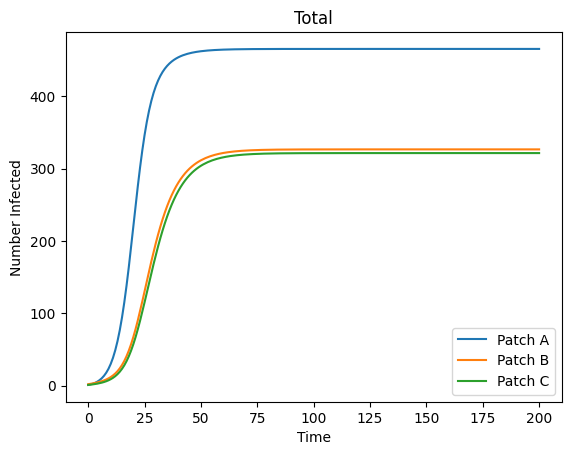

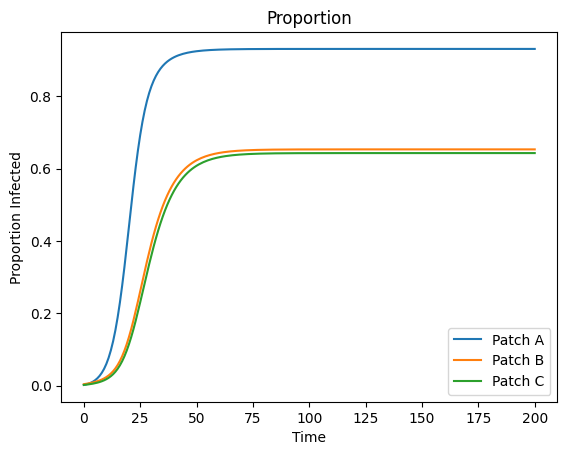


-------------------------------------


-------------------------------------

Original full_sparse_isolate time: 0.000745 seconds
Optimized full_sparse_isolate_fast time: 0.000290 seconds
True
[[250.           0.           0.           0.           0.
    0.           0.           0.           0.        ]
 [143.75         0.625        0.           0.625        5.
    0.           0.           0.           0.        ]
 [ 94.16666667   0.41666667   0.           0.41666667   0.
    0.83333333   0.           0.83333333   3.33333333]
 [  2.5          0.3125       0.           0.3125      71.875
    0.           0.           0.           0.        ]
 [  0.           0.           0.           0.         300.
    0.           0.           0.           0.        ]
 [  0.           0.           0.           0.          62.5
   10.41666667   0.          10.41666667  41.66666667]
 [  1.66666667   0.20833333   0.           0.20833333   0.
    0.41666667   0.           0.41666667  47.08333333]
 [ 

In [185]:
import scipy.sparse as sp

station_list = ["A","B","C"]
home_patches = [0,4,8]
travel_patches = [1,3,5,7]
valid_patch_indices = [0,1,3,4,5,7,8]

connections_list = []
for i in range(3):
    for j in range(3):
        connections_list.append((station_list[i],station_list[j]))



np.set_printoptions(suppress=True)





tspent = np.array([
    [1,0,0, 0,0,0, 0,0,0],
    [14/24, 1/24, 0, 1/24, 8/24, 0, 0, 0, 0],
    [10/24, 1/24, 0, 1/24, 0, 2/24, 0, 2/24, 8/24],
    [8/24, 1/24, 0, 1/24, 14/24, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 12/24, 2/24, 0, 2/24, 8/24],
    [8/24, 1/24, 0, 1/24, 0, 2/24, 0, 2/24, 10/24],
    [0, 0, 0, 0, 8/24, 2/24, 0, 2/24, 12/24],
    [0, 0, 0, 0, 0, 0, 0, 0, 1],
])

# N = [1000,300,100]
N = [500,500,500]

workpops = np.array([
    0.5*N[0],
    0.3*N[0],
    0.2*N[0],
    0.15*N[1],
    0.6*N[1],
    0.25*N[1],
    0.1*N[2],
    0.2*N[2],
    0.7*N[2],
])

expanded_p_matrix = (tspent.T*workpops).T

p_matrix = convert_back_to_classic_p(expanded_p_matrix)

sparse_expanded_p_matrix = sp.csr_matrix(expanded_p_matrix)



pairs_list = []
for i in range(3):
    for j in range(3):
        pairs_list.append((station_list[i],station_list[j]))
pairs_list = np.array(pairs_list)


isolated = sparse_isolate_patch(sparse_expanded_p_matrix,0,0.9).toarray()


def long(short):
    long = np.zeros(9)
    long[[0,4,8]] = short
    return long

# data_A = np.array([1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4])
# data_B = np.array([2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4])
# data_C = np.array([1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 5, 6])


pop_vector = long(N)

I0 = np.array([1,0,0,0,2,0,0,0,1])
S0 = pop_vector-I0
I_total_0 = I0.copy()
pop_vector,S0,I0

Nj = pop_vector @ p_matrix
for i in range(9):
    if Nj[i] == 0:
        Nj[i] = 1
        


def run_model(p_matrix,params):
    S0, I0, I_total0, beta, gamma, timesteps = params
    y0 = np.concatenate((S0, I0, I_total0))
    beta_p_matrix = csr_matrix(p_matrix).multiply(beta[:, None])
    t = np.linspace(0, timesteps, num=timesteps)
    y_log = np.zeros((len(t)+1, 27))
    y_log[0] = y0

    def sir(y):
        S, I, I_total = y[:9], y[9:18], y[18:]
        Ij = p_matrix.T @ I
        Ij_div_Nj = Ij / Nj
        inf = beta_p_matrix.multiply(S[:, None]) @ Ij_div_Nj
        dSdt = -inf
        dIdt = inf - gamma * I
        dI_totaldt = -dSdt
        return np.concatenate((dSdt, dIdt, dI_totaldt))

    for step in range(len(t)):
        y_log[step+1] = y_log[step] + sir(y_log[step])

    return y_log.T[18:]


everyone_else = 0.3
beta = np.array([0.6, everyone_else,everyone_else,everyone_else,everyone_else,everyone_else,everyone_else,everyone_else,everyone_else])
gamma = 1/5
gammas = np.ones(9)*gamma
timesteps = 200

output = run_model(p_matrix,(S0, I0, I_total_0, beta, gamma, timesteps))

t = np.linspace(0, timesteps, timesteps+1)

plt.plot(t, output[0], label='Patch A')
plt.plot(t, output[4], label='Patch B')
plt.plot(t, output[8], label='Patch C')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Number Infected")
plt.title("Total")
plt.show()

plt.plot(t, output[0]/pop_vector[0], label='Patch A')
plt.plot(t, output[4]/pop_vector[4], label='Patch B')
plt.plot(t, output[8]/pop_vector[8], label='Patch C')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Proportion Infected")
plt.title("Proportion")
plt.show()

print("\n-------------------------------------\n")
print("\n-------------------------------------\n")


list_of_p_matrices = []
list_of_p_matrices.append(p_matrix)
patches_to_isolate = [0]

import time

# --- Timing the original function ---
start = time.time()
original = full_sparse_isolate(
    sparse_expanded_p_matrix,
    patch_indices=patches_to_isolate,
    station_list=station_list,
    pairs_list=pairs_list,
    home_patches=home_patches,
    modification=0.9
)
time_full = time.time() - start
print(f"Original full_sparse_isolate time: {time_full:.6f} seconds")


# --- Timing the fast function ---
start = time.time()
# Preconvert
# Call the final fast function
faster = full_sparse_isolate_ultrafast_csr(
    sparse_expanded_p_matrix,
    patch_station_names,
    station_to_rows,
    row_home_patches,
    modification=0.9
)
time_fast = time.time() - start
print(f"Optimized full_sparse_isolate_fast time: {time_fast:.6f} seconds")
print(np.allclose(original.toarray(), faster.toarray()))
print(original.toarray(),"\n\n\n",faster.toarray())


[0, 1, 2, 3, 6] [0, 0, 0, 4, 8]


Isolating Patch: 100%|██████████| 5/5 [00:00<00:00, 11453.59it/s]


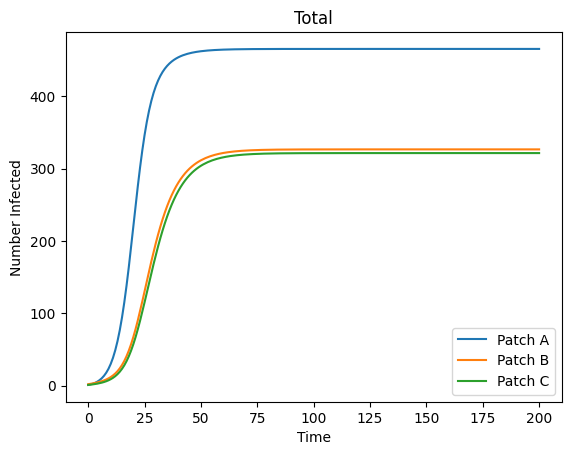

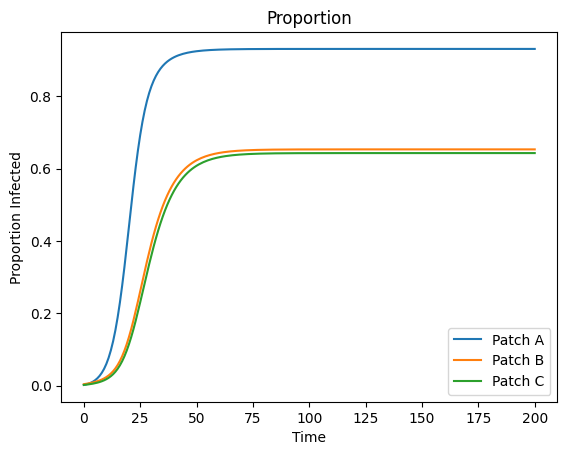


-------------------------------------


-------------------------------------



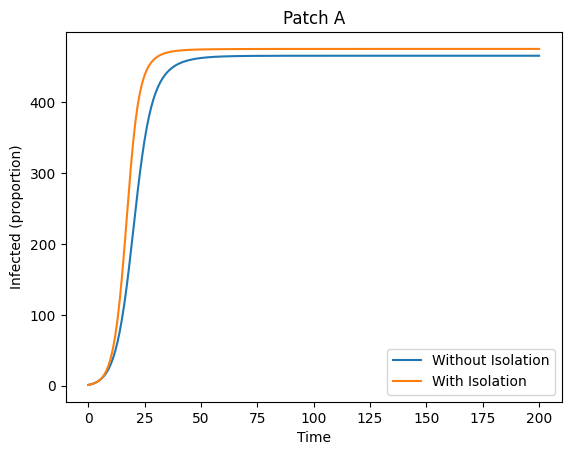

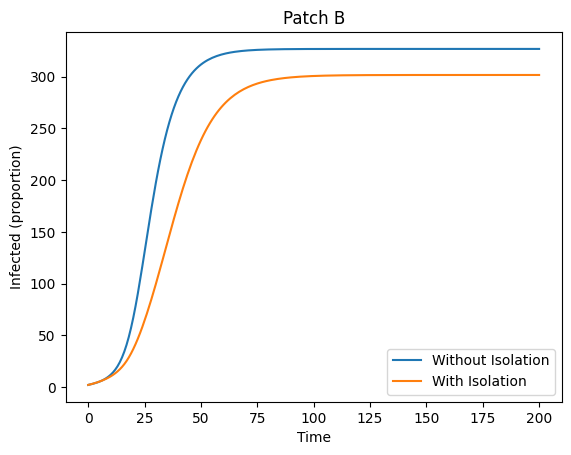

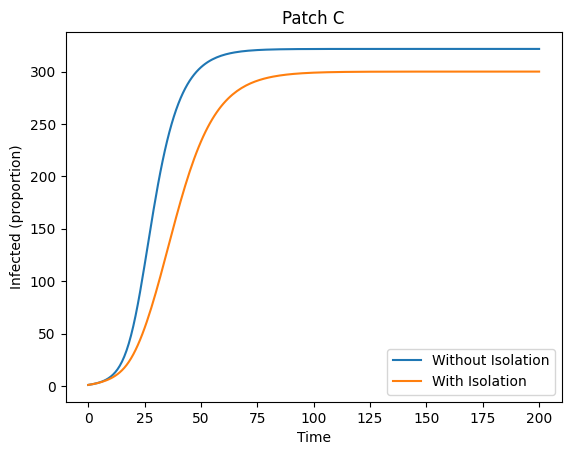

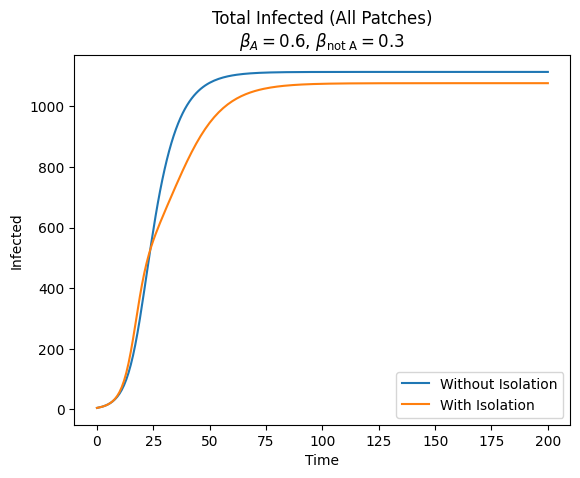

Total infections prevented by isolating ['A']: 37.19085670458958

Finished all runs.


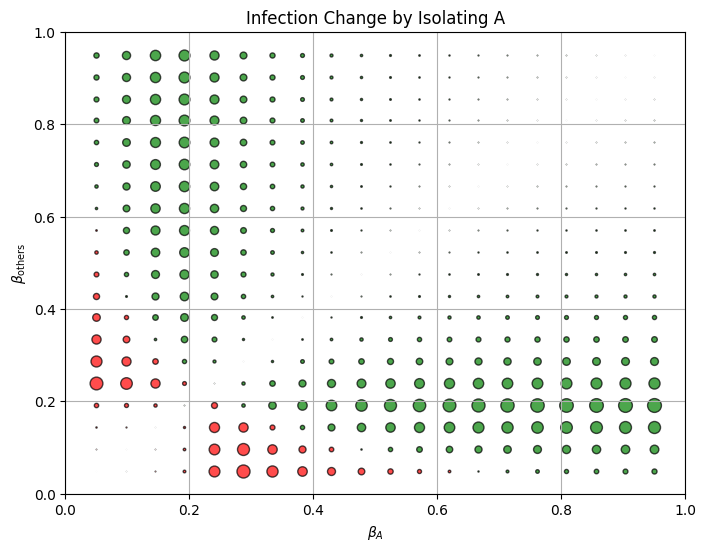

In [127]:
import scipy.sparse as sp

station_list = ["A","B","C"]
home_patches = [0,4,8]
travel_patches = [1,3,5,7]
valid_patch_indices = [0,1,3,4,5,7,8]

connections_list = []
for i in range(3):
    for j in range(3):
        connections_list.append((station_list[i],station_list[j]))



np.set_printoptions(suppress=True)





tspent = np.array([
    [1,0,0, 0,0,0, 0,0,0],
    [14/24, 1/24, 0, 1/24, 8/24, 0, 0, 0, 0],
    [10/24, 1/24, 0, 1/24, 0, 2/24, 0, 2/24, 8/24],
    [8/24, 1/24, 0, 1/24, 14/24, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 12/24, 2/24, 0, 2/24, 8/24],
    [8/24, 1/24, 0, 1/24, 0, 2/24, 0, 2/24, 10/24],
    [0, 0, 0, 0, 8/24, 2/24, 0, 2/24, 12/24],
    [0, 0, 0, 0, 0, 0, 0, 0, 1],
])

# N = [1000,300,100]
N = [500,500,500]

workpops = np.array([
    0.5*N[0],
    0.3*N[0],
    0.2*N[0],
    0.15*N[1],
    0.6*N[1],
    0.25*N[1],
    0.1*N[2],
    0.2*N[2],
    0.7*N[2],
])

expanded_p_matrix = (tspent.T*workpops).T


p_matrix = convert_back_to_classic_p(expanded_p_matrix)

sparse_expanded_p_matrix = sp.csr_matrix(expanded_p_matrix)



pairs_list = []
for i in range(3):
    for j in range(3):
        pairs_list.append((station_list[i],station_list[j]))
pairs_list = np.array(pairs_list)


isolated = sparse_isolate_patch(sparse_expanded_p_matrix,0,0.9).toarray()


def long(short):
    long = np.zeros(9)
    long[[0,4,8]] = short
    return long

# data_A = np.array([1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4])
# data_B = np.array([2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4])
# data_C = np.array([1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 5, 6])


pop_vector = long(N)

I0 = np.array([1,0,0,0,2,0,0,0,1])
S0 = pop_vector-I0
I_total_0 = I0.copy()
pop_vector,S0,I0

Nj = pop_vector @ p_matrix
for i in range(9):
    if Nj[i] == 0:
        Nj[i] = 1
        


def run_model(p_matrix,params):
    S0, I0, I_total0, beta, gamma, timesteps = params
    y0 = np.concatenate((S0, I0, I_total0))
    beta_p_matrix = csr_matrix(p_matrix).multiply(beta[:, None])
    t = np.linspace(0, timesteps, num=timesteps)
    y_log = np.zeros((len(t)+1, 27))
    y_log[0] = y0

    def sir(y):
        S, I, I_total = y[:9], y[9:18], y[18:]
        Ij = p_matrix.T @ I
        Ij_div_Nj = Ij / Nj
        inf = beta_p_matrix.multiply(S[:, None]) @ Ij_div_Nj
        dSdt = -inf
        dIdt = inf - gamma * I
        dI_totaldt = -dSdt
        return np.concatenate((dSdt, dIdt, dI_totaldt))

    for step in range(len(t)):
        y_log[step+1] = y_log[step] + sir(y_log[step])

    return y_log.T[18:]


everyone_else = 0.3
beta = np.array([0.6, everyone_else,everyone_else,everyone_else,everyone_else,everyone_else,everyone_else,everyone_else,everyone_else])
gamma = 1/5
gammas = np.ones(9)*gamma
timesteps = 200

output = run_model(p_matrix,(S0, I0, I_total_0, beta, gamma, timesteps))

t = np.linspace(0, timesteps, timesteps+1)

plt.plot(t, output[0], label='Patch A')
plt.plot(t, output[4], label='Patch B')
plt.plot(t, output[8], label='Patch C')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Number Infected")
plt.title("Total")
plt.show()

plt.plot(t, output[0]/pop_vector[0], label='Patch A')
plt.plot(t, output[4]/pop_vector[4], label='Patch B')
plt.plot(t, output[8]/pop_vector[8], label='Patch C')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Proportion Infected")
plt.title("Proportion")
plt.show()

print("\n-------------------------------------\n")
print("\n-------------------------------------\n")


list_of_p_matrices = []
list_of_p_matrices.append(p_matrix)
patches_to_isolate = [0]

modified_sparse = full_sparse_isolate(
    sparse_expanded_p_matrix,
    patch_indices=patches_to_isolate,
    station_list=station_list,
    pairs_list=pairs_list,
    home_patches=home_patches,
    modification=0.9
)


new_p = modified_sparse.toarray()

list_of_p_matrices.append(convert_back_to_classic_p(new_p))

results = []
totals = []

for p_matrix in list_of_p_matrices:
    Nj = pop_vector @ p_matrix
    Nj[Nj == 0] = 1

    output = run_model(p_matrix, (S0, I0, I_total_0, beta, gamma, timesteps))
    results.append(output[[0,4,8]])  # A, B, C
    totals.append(output.sum(axis=0))  # total across all patches

results = np.array(results)  # (num_runs, 3, timesteps+1)
totals = np.array(totals)    # (num_runs, timesteps+1)
t = np.linspace(0, timesteps, timesteps+1)

labels = ['Without Isolation', 'With Isolation']

# A, B, C plots
for i, patch_label in zip(range(3), ['Patch A', 'Patch B', 'Patch C']):
    plt.figure()
    for r, sim_label in zip(results, labels):
        plt.plot(t, r[i], label=sim_label)
    plt.title(patch_label)
    plt.xlabel("Time")
    plt.ylabel("Infected (proportion)")
    plt.legend()
    plt.show()

# Total plot
plt.figure()
for total, sim_label in zip(totals, labels):
    plt.plot(t, total, label=sim_label)
plt.title(f"Total Infected (All Patches)\n$\\beta_A = {beta[0]}$, $\\beta_{{\\mathrm{{not\\ A}}}} = {beta[1]}$")
plt.xlabel("Time")
plt.ylabel("Infected")
plt.legend()
plt.show()
print(f"Total infections prevented by isolating {np.array(station_list)[patches_to_isolate]}:",totals[0][-1]-totals[1][-1])


beta_A_vals = np.linspace(0.05, 0.95, 20)
beta_others_vals = np.linspace(0.05, 0.95, 20)

X, Y, sizes, colors = [], [], [], []

for beta_A in beta_A_vals:
    for beta_others in beta_others_vals:
        beta = np.array([beta_A] + [beta_others]*8)

        I0_current = np.array([1,0,0,0,2,0,0,0,1])
        S0_current = pop_vector - I0_current
        I_total_0_current = I0_current.copy()

        totals = []
        for p_mat in list_of_p_matrices:
            Nj = pop_vector @ p_mat
            Nj[Nj == 0] = 1

            output = run_model(p_mat, (S0_current.copy(), I0_current.copy(), I_total_0_current.copy(), beta, gamma, timesteps))
            total_infected = output.sum(axis=0)
            totals.append(total_infected)

        infections_prevented = totals[0][-1] - totals[1][-1]

        X.append(beta_A)
        Y.append(beta_others)
        sizes.append(abs(infections_prevented) * 0.5)
        colors.append('red' if infections_prevented < 0 else 'green')

print("\nFinished all runs.")

plt.figure(figsize=(8,6))
for x, y, s, c in zip(X, Y, sizes, colors):
    plt.scatter(x, y, s=s, alpha=0.7, color=c, edgecolors='k')

plt.xlabel(r'$\beta_A$')
plt.ylabel(r'$\beta_{\mathrm{others}}$')
plt.title('Infection Change by Isolating A')
plt.grid(True)
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()


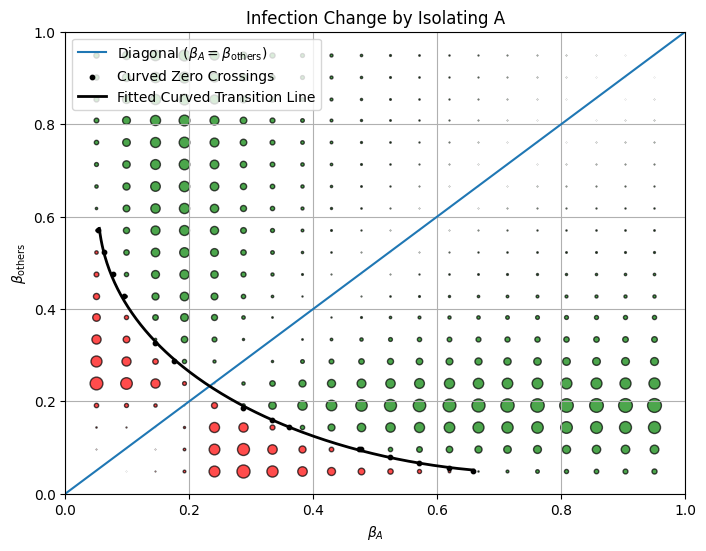

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev

# Assume X, Y, sizes, colors, pop_vector, list_of_p_matrices, gamma, run_model() already available

# 1. Recompute infections_prevented_list
infections_prevented_list = []

for beta_A, beta_others in zip(X, Y):
    beta = np.array([beta_A] + [beta_others]*8)

    I0_current = np.array([1,0,0,0,2,0,0,0,1])
    S0_current = pop_vector - I0_current
    I_total_0_current = I0_current.copy()

    totals = []
    for p_mat in list_of_p_matrices:
        Nj = pop_vector @ p_mat
        Nj[Nj == 0] = 1

        output = run_model(p_mat, (S0_current.copy(), I0_current.copy(), I_total_0_current.copy(), beta, gamma, 200))
        total_infected = output.sum(axis=0)
        totals.append(total_infected)

    infections_prevented = totals[0][-1] - totals[1][-1]
    infections_prevented_list.append(infections_prevented)

infections_prevented_list = np.array(infections_prevented_list)

# 2. Organize into grid for neighbor checking
beta_A_unique = np.unique(np.round(X, 4))
beta_others_unique = np.unique(np.round(Y, 4))

bubble_dict = {}
for i in range(len(X)):
    bubble_dict[(np.round(X[i],4), np.round(Y[i],4))] = infections_prevented_list[i]

transition_points = []

# 3. Walk grid to find zero crossings
for beta_A in beta_A_unique:
    for beta_others in beta_others_unique:
        key = (np.round(beta_A,4), np.round(beta_others,4))
        if key not in bubble_dict:
            continue

        # Right neighbor
        right_key = (np.round(beta_A+(beta_A_unique[1]-beta_A_unique[0]),4), np.round(beta_others,4))
        if right_key in bubble_dict:
            val1 = bubble_dict[key]
            val2 = bubble_dict[right_key]
            if val1 * val2 < 0:
                w = abs(val1) / (abs(val1) + abs(val2))
                x_zero = beta_A*(1-w) + right_key[0]*w
                y_zero = beta_others
                transition_points.append((x_zero, y_zero))

        # Up neighbor
        up_key = (np.round(beta_A,4), np.round(beta_others+(beta_others_unique[1]-beta_others_unique[0]),4))
        if up_key in bubble_dict:
            val1 = bubble_dict[key]
            val2 = bubble_dict[up_key]
            if val1 * val2 < 0:
                w = abs(val1) / (abs(val1) + abs(val2))
                x_zero = beta_A
                y_zero = beta_others*(1-w) + up_key[1]*w
                transition_points.append((x_zero, y_zero))

transition_points = np.array(transition_points)

# 4. Separate diagonal points from curved points
diag_thresh = 0.05  # threshold: how close to diagonal (beta_A ≈ beta_others)
diag_points = []
curve_points = []

for pt in transition_points:
    beta_A, beta_others = pt
    if abs(beta_A - beta_others) < diag_thresh:
        diag_points.append(pt)
    else:
        curve_points.append(pt)

diag_points = np.array(diag_points)
curve_points = np.array(curve_points)

# 5. Fit spline ONLY to curved points
if len(curve_points) > 0:
    sorted_idx = np.argsort(curve_points[:,0])
    curve_points = curve_points[sorted_idx]

    tck, u = splprep([curve_points[:,0], curve_points[:,1]], s=0.02)  # Smooth
    unew = np.linspace(0,1,300)
    out = splev(unew, tck)

# 6. Plot everything
plt.figure(figsize=(8,6))

# Bubbles
for x, y, s, c in zip(X, Y, sizes, colors):
    plt.scatter(x, y, s=s, alpha=0.7, color=c, edgecolors='k')
    
# Plot diagonal reference line
diag_line = np.linspace(0, 1, 100)
plt.plot(diag_line, diag_line, '-', label=r'Diagonal ($\beta_A = \beta_{\mathrm{others}}$)')

# Curved zero-crossing points
if len(curve_points) > 0:
    plt.scatter(curve_points[:,0], curve_points[:,1], c='k', s=10, label='Curved Zero Crossings')

# Fitted spline for curve
if len(curve_points) > 0:
    plt.plot(out[0], out[1], 'k-', linewidth=2, label='Fitted Curved Transition Line')

plt.xlabel(r'$\beta_A$')
plt.ylabel(r'$\beta_{\mathrm{others}}$')
plt.title('Infection Change by Isolating A')
plt.grid(True)
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.show()


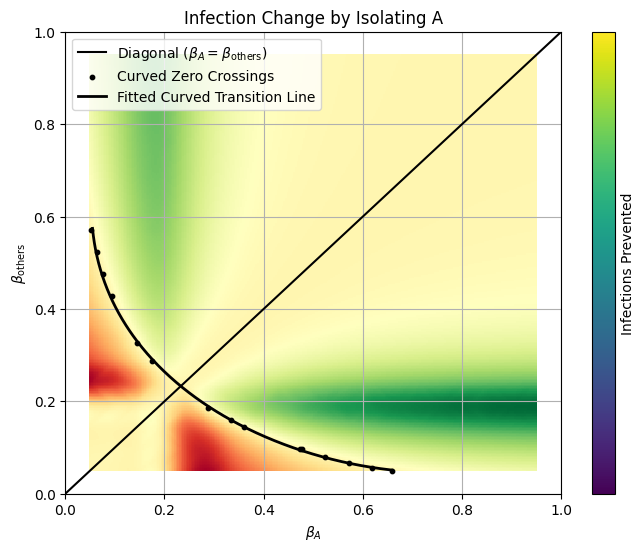

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev

# Assume X, Y, sizes, colors, pop_vector, list_of_p_matrices, gamma, run_model() already available

# 1. Recompute infections_prevented_list
infections_prevented_list = []

for beta_A, beta_others in zip(X, Y):
    beta = np.array([beta_A] + [beta_others]*8)

    I0_current = np.array([1,0,0,0,2,0,0,0,1])
    S0_current = pop_vector - I0_current
    I_total_0_current = I0_current.copy()

    totals = []
    for p_mat in list_of_p_matrices:
        Nj = pop_vector @ p_mat
        Nj[Nj == 0] = 1

        output = run_model(p_mat, (S0_current.copy(), I0_current.copy(), I_total_0_current.copy(), beta, gamma, 200))
        total_infected = output.sum(axis=0)
        totals.append(total_infected)

    infections_prevented = totals[0][-1] - totals[1][-1]
    infections_prevented_list.append(infections_prevented)

infections_prevented_list = np.array(infections_prevented_list)

# 2. Organize into grid for neighbor checking
beta_A_unique = np.unique(np.round(X, 4))
beta_others_unique = np.unique(np.round(Y, 4))

bubble_dict = {}
for i in range(len(X)):
    bubble_dict[(np.round(X[i],4), np.round(Y[i],4))] = infections_prevented_list[i]

transition_points = []

# 3. Walk grid to find zero crossings
for beta_A in beta_A_unique:
    for beta_others in beta_others_unique:
        key = (np.round(beta_A,4), np.round(beta_others,4))
        if key not in bubble_dict:
            continue

        # Right neighbor
        right_key = (np.round(beta_A+(beta_A_unique[1]-beta_A_unique[0]),4), np.round(beta_others,4))
        if right_key in bubble_dict:
            val1 = bubble_dict[key]
            val2 = bubble_dict[right_key]
            if val1 * val2 < 0:
                w = abs(val1) / (abs(val1) + abs(val2))
                x_zero = beta_A*(1-w) + right_key[0]*w
                y_zero = beta_others
                transition_points.append((x_zero, y_zero))

        # Up neighbor
        up_key = (np.round(beta_A,4), np.round(beta_others+(beta_others_unique[1]-beta_others_unique[0]),4))
        if up_key in bubble_dict:
            val1 = bubble_dict[key]
            val2 = bubble_dict[up_key]
            if val1 * val2 < 0:
                w = abs(val1) / (abs(val1) + abs(val2))
                x_zero = beta_A
                y_zero = beta_others*(1-w) + up_key[1]*w
                transition_points.append((x_zero, y_zero))

transition_points = np.array(transition_points)

# 4. Separate diagonal points from curved points
diag_thresh = 0.05  # threshold: how close to diagonal (beta_A ≈ beta_others)
diag_points = []
curve_points = []

for pt in transition_points:
    beta_A, beta_others = pt
    if abs(beta_A - beta_others) < diag_thresh:
        diag_points.append(pt)
    else:
        curve_points.append(pt)

diag_points = np.array(diag_points)
curve_points = np.array(curve_points)

# 5. Fit spline ONLY to curved points
if len(curve_points) > 0:
    sorted_idx = np.argsort(curve_points[:,0])
    curve_points = curve_points[sorted_idx]

    tck, u = splprep([curve_points[:,0], curve_points[:,1]], s=0.02)  # Smooth
    unew = np.linspace(0,1,300)
    out = splev(unew, tck)

# 6. Prepare grid for background coloring
from scipy.interpolate import griddata

plt.figure(figsize=(8,6))

# Create grid
xi = np.linspace(0, 1, 300)
yi = np.linspace(0, 1, 300)
xi, yi = np.meshgrid(xi, yi)

# Interpolate infections_prevented_list onto the grid
zi = griddata((X, Y), infections_prevented_list, (xi, yi), method='cubic')

# Plot the gradient background
plt.pcolormesh(xi, yi, zi, shading='auto', cmap='RdYlGn', vmin=np.min(infections_prevented_list), vmax=np.max(infections_prevented_list))

# Plot diagonal reference line
diag_line = np.linspace(0, 1, 100)
plt.plot(diag_line, diag_line, '-', color='black', label=r'Diagonal ($\beta_A = \beta_{\mathrm{others}}$)')

# Curved zero-crossing points
if len(curve_points) > 0:
    plt.scatter(curve_points[:,0], curve_points[:,1], c='k', s=10, label='Curved Zero Crossings')

# Fitted spline for curve
if len(curve_points) > 0:
    plt.plot(out[0], out[1], 'k-', linewidth=2, label='Fitted Curved Transition Line')

plt.xlabel(r'$\beta_A$')
plt.ylabel(r'$\beta_{\mathrm{others}}$')
plt.title('Infection Change by Isolating A')
plt.grid(True)
plt.xlim([0,1])
plt.ylim([0,1])
cbar = plt.colorbar(label='Infections Prevented')
cbar.set_ticks([])          # Remove ticks
cbar.ax.set_yticklabels([]) # Remove number labels
plt.legend()
plt.show()



[0, 1, 2, 3, 6] [0, 0, 0, 4, 8]


Isolating Patch: 100%|██████████| 5/5 [00:00<00:00, 5632.96it/s]


-------------------------------------


-------------------------------------




Finished all runs.


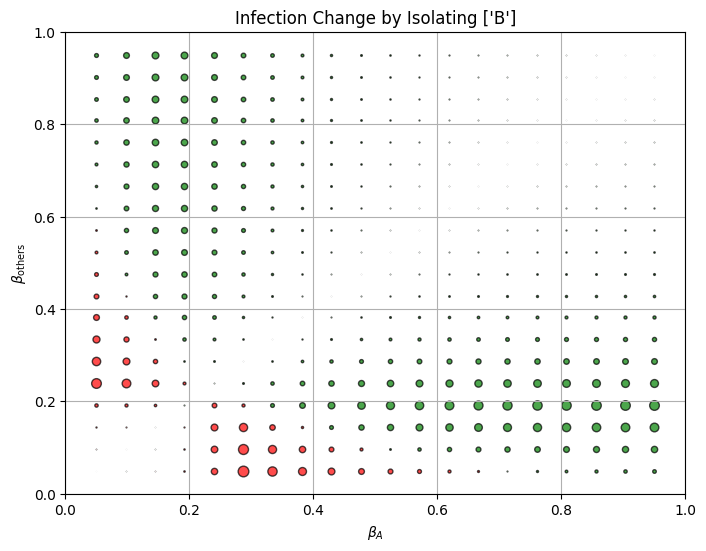

In [43]:
import scipy.sparse as sp

station_list = ["A","B","C"]
home_patches = [0,4,8]
travel_patches = [1,3,5,7]
valid_patch_indices = [0,1,3,4,5,7,8]

connections_list = []
for i in range(3):
    for j in range(3):
        connections_list.append((station_list[i],station_list[j]))



np.set_printoptions(suppress=True)





tspent = np.array([
    [1,0,0, 0,0,0, 0,0,0],
    [14/24, 1/24, 0, 1/24, 8/24, 0, 0, 0, 0],
    [10/24, 1/24, 0, 1/24, 0, 2/24, 0, 2/24, 8/24],
    [8/24, 1/24, 0, 1/24, 14/24, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 12/24, 2/24, 0, 2/24, 8/24],
    [8/24, 1/24, 0, 1/24, 0, 2/24, 0, 2/24, 10/24],
    [0, 0, 0, 0, 8/24, 2/24, 0, 2/24, 12/24],
    [0, 0, 0, 0, 0, 0, 0, 0, 1],
])

# N = [1000,300,100]
N = [500,500,500]

workpops = np.array([
    0.5*N[0],
    0.3*N[0],
    0.2*N[0],
    0.15*N[1],
    0.6*N[1],
    0.25*N[1],
    0.1*N[2],
    0.2*N[2],
    0.7*N[2],
])

expanded_p_matrix = (tspent.T*workpops).T


p_matrix = convert_back_to_classic_p(expanded_p_matrix)

sparse_expanded_p_matrix = sp.csr_matrix(expanded_p_matrix)



pairs_list = []
for i in range(3):
    for j in range(3):
        pairs_list.append((station_list[i],station_list[j]))
pairs_list = np.array(pairs_list)


isolated = sparse_isolate_patch(sparse_expanded_p_matrix,0,0.9).toarray()


def long(short):
    long = np.zeros(9)
    long[[0,4,8]] = short
    return long

# data_A = np.array([1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4])
# data_B = np.array([2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4])
# data_C = np.array([1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 5, 6])


pop_vector = long(N)

I0 = np.array([1,0,0,0,2,0,0,0,1])
S0 = pop_vector-I0
I_total_0 = I0.copy()
pop_vector,S0,I0

Nj = pop_vector @ p_matrix
for i in range(9):
    if Nj[i] == 0:
        Nj[i] = 1
        


def run_model(p_matrix,params):
    S0, I0, I_total0, beta, gamma, timesteps = params
    y0 = np.concatenate((S0, I0, I_total0))
    beta_p_matrix = csr_matrix(p_matrix).multiply(beta[:, None])
    t = np.linspace(0, timesteps, num=timesteps)
    y_log = np.zeros((len(t)+1, 27))
    y_log[0] = y0

    def sir(y):
        S, I, I_total = y[:9], y[9:18], y[18:]
        Ij = p_matrix.T @ I
        Ij_div_Nj = Ij / Nj
        inf = beta_p_matrix.multiply(S[:, None]) @ Ij_div_Nj
        dSdt = -inf
        dIdt = inf - gamma * I
        dI_totaldt = -dSdt
        return np.concatenate((dSdt, dIdt, dI_totaldt))

    for step in range(len(t)):
        y_log[step+1] = y_log[step] + sir(y_log[step])

    return y_log.T[18:]


everyone_else = 0.3
beta = np.array([0.6, everyone_else,everyone_else,everyone_else,everyone_else,everyone_else,everyone_else,everyone_else,everyone_else])
gamma = 1/5
gammas = np.ones(9)*gamma
timesteps = 200

output = run_model(p_matrix,(S0, I0, I_total_0, beta, gamma, timesteps))

t = np.linspace(0, timesteps, timesteps+1)

list_of_p_matrices = []
list_of_p_matrices.append(p_matrix)
patches_to_isolate = [1]

modified_sparse = full_sparse_isolate(
    sparse_expanded_p_matrix,
    patch_indices=patches_to_isolate,
    station_list=station_list,
    pairs_list=pairs_list,
    home_patches=home_patches,
    modification=0.9
)


new_p = modified_sparse.toarray()

list_of_p_matrices.append(convert_back_to_classic_p(new_p))

results = []
totals = []

for p_matrix in list_of_p_matrices:
    Nj = pop_vector @ p_matrix
    Nj[Nj == 0] = 1

    output = run_model(p_matrix, (S0, I0, I_total_0, beta, gamma, timesteps))
    results.append(output[[0,4,8]])  # A, B, C
    totals.append(output.sum(axis=0))  # total across all patches

results = np.array(results)  # (num_runs, 3, timesteps+1)
totals = np.array(totals)    # (num_runs, timesteps+1)
t = np.linspace(0, timesteps, timesteps+1)


beta_A_vals = np.linspace(0.05, 0.95, 20)
beta_others_vals = np.linspace(0.05, 0.95, 20)

X, Y, sizes, colors = [], [], [], []

for beta_A in beta_A_vals:
    for beta_others in beta_others_vals:
        beta = np.array([beta_A] + [beta_others]*8)

        I0_current = np.array([1,0,0,0,2,0,0,0,1])
        S0_current = pop_vector - I0_current
        I_total_0_current = I0_current.copy()

        totals = []
        for p_mat in list_of_p_matrices:
            Nj = pop_vector @ p_mat
            Nj[Nj == 0] = 1

            output = run_model(p_mat, (S0_current.copy(), I0_current.copy(), I_total_0_current.copy(), beta, gamma, timesteps))
            total_infected = output.sum(axis=0)
            totals.append(total_infected)

        infections_prevented = totals[0][-1] - totals[1][-1]

        X.append(beta_A)
        Y.append(beta_others)
        sizes.append(abs(infections_prevented) * 0.5)
        colors.append('red' if infections_prevented < 0 else 'green')

print("\nFinished all runs.")

plt.figure(figsize=(8,6))
for x, y, s, c in zip(X, Y, sizes, colors):
    plt.scatter(x, y, s=s, alpha=0.7, color=c, edgecolors='k')

plt.xlabel(r'$\beta_A$')
plt.ylabel(r'$\beta_{\mathrm{others}}$')
plt.title(f'Infection Change by Isolating {np.array(station_list)[patches_to_isolate]}')
plt.grid(True)
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()


[0, 1, 2, 3, 6] [0, 0, 0, 4, 8]


Isolating Patch: 100%|██████████| 5/5 [00:00<00:00, 5511.57it/s]



Finished all runs.


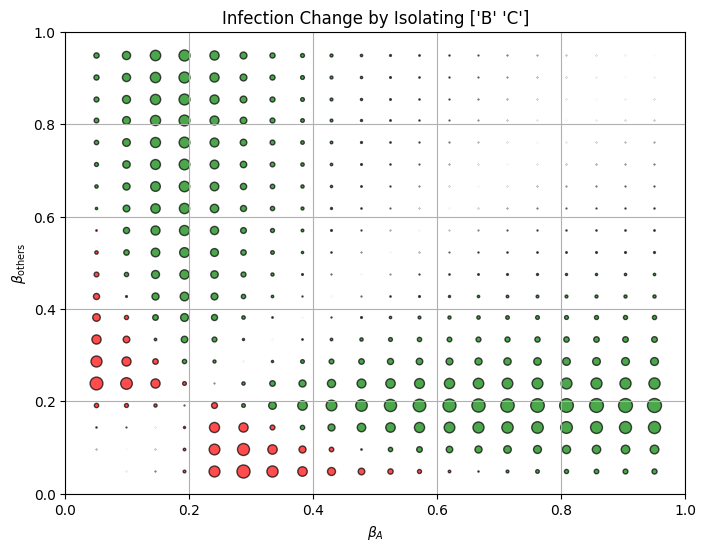

In [65]:
import scipy.sparse as sp

station_list = ["A","B","C"]
home_patches = [0,4,8]
travel_patches = [1,3,5,7]
valid_patch_indices = [0,1,3,4,5,7,8]

connections_list = []
for i in range(3):
    for j in range(3):
        connections_list.append((station_list[i],station_list[j]))



np.set_printoptions(suppress=True)





tspent = np.array([
    [1,0,0, 0,0,0, 0,0,0],
    [14/24, 1/24, 0, 1/24, 8/24, 0, 0, 0, 0],
    [10/24, 1/24, 0, 1/24, 0, 2/24, 0, 2/24, 8/24],
    [8/24, 1/24, 0, 1/24, 14/24, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 12/24, 2/24, 0, 2/24, 8/24],
    [8/24, 1/24, 0, 1/24, 0, 2/24, 0, 2/24, 10/24],
    [0, 0, 0, 0, 8/24, 2/24, 0, 2/24, 12/24],
    [0, 0, 0, 0, 0, 0, 0, 0, 1],
])

# N = [1000,300,100]
N = [500,500,500]

workpops = np.array([
    0.5*N[0],
    0.3*N[0],
    0.2*N[0],
    0.15*N[1],
    0.6*N[1],
    0.25*N[1],
    0.1*N[2],
    0.2*N[2],
    0.7*N[2],
])

expanded_p_matrix = (tspent.T*workpops).T


p_matrix = convert_back_to_classic_p(expanded_p_matrix)

sparse_expanded_p_matrix = sp.csr_matrix(expanded_p_matrix)



pairs_list = []
for i in range(3):
    for j in range(3):
        pairs_list.append((station_list[i],station_list[j]))
pairs_list = np.array(pairs_list)


isolated = sparse_isolate_patch(sparse_expanded_p_matrix,0,0.9).toarray()


def long(short):
    long = np.zeros(9)
    long[[0,4,8]] = short
    return long

# data_A = np.array([1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4])
# data_B = np.array([2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4])
# data_C = np.array([1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 5, 6])


pop_vector = long(N)

I0 = np.array([1,0,0,0,2,0,0,0,1])
S0 = pop_vector-I0
I_total_0 = I0.copy()
pop_vector,S0,I0

Nj = pop_vector @ p_matrix
for i in range(9):
    if Nj[i] == 0:
        Nj[i] = 1
        


def run_model(p_matrix,params):
    S0, I0, I_total0, beta, gamma, timesteps = params
    y0 = np.concatenate((S0, I0, I_total0))
    beta_p_matrix = csr_matrix(p_matrix).multiply(beta[:, None])
    t = np.linspace(0, timesteps, num=timesteps)
    y_log = np.zeros((len(t)+1, 27))
    y_log[0] = y0

    def sir(y):
        S, I, I_total = y[:9], y[9:18], y[18:]
        Ij = p_matrix.T @ I
        Ij_div_Nj = Ij / Nj
        inf = beta_p_matrix.multiply(S[:, None]) @ Ij_div_Nj
        dSdt = -inf
        dIdt = inf - gamma * I
        dI_totaldt = -dSdt
        return np.concatenate((dSdt, dIdt, dI_totaldt))

    for step in range(len(t)):
        y_log[step+1] = y_log[step] + sir(y_log[step])

    return y_log.T[18:]


everyone_else = 0.3
beta = np.array([0.6, everyone_else,everyone_else,everyone_else,everyone_else,everyone_else,everyone_else,everyone_else,everyone_else])
gamma = 1/5
gammas = np.ones(9)*gamma
timesteps = 200

output = run_model(p_matrix,(S0, I0, I_total_0, beta, gamma, timesteps))

t = np.linspace(0, timesteps, timesteps+1)

list_of_p_matrices = []
list_of_p_matrices.append(p_matrix)
patches_to_isolate = [1,2]

modified_sparse = full_sparse_isolate(
    sparse_expanded_p_matrix,
    patch_indices=patches_to_isolate,
    station_list=station_list,
    pairs_list=pairs_list,
    home_patches=home_patches,
    modification=0.9
)


new_p = modified_sparse.toarray()

list_of_p_matrices.append(convert_back_to_classic_p(new_p))

results = []
totals = []

for p_matrix in list_of_p_matrices:
    Nj = pop_vector @ p_matrix
    Nj[Nj == 0] = 1

    output = run_model(p_matrix, (S0, I0, I_total_0, beta, gamma, timesteps))
    results.append(output[[0,4,8]])  # A, B, C
    totals.append(output.sum(axis=0))  # total across all patches

results = np.array(results)  # (num_runs, 3, timesteps+1)
totals = np.array(totals)    # (num_runs, timesteps+1)
t = np.linspace(0, timesteps, timesteps+1)


beta_A_vals = np.linspace(0.05, 0.95, 20)
beta_others_vals = np.linspace(0.05, 0.95, 20)

X, Y, sizes, colors = [], [], [], []

for beta_A in beta_A_vals:
    for beta_others in beta_others_vals:
        beta = np.array([beta_A] + [beta_others]*8)

        I0_current = np.array([1,0,0,0,2,0,0,0,1])
        S0_current = pop_vector - I0_current
        I_total_0_current = I0_current.copy()

        totals = []
        for p_mat in list_of_p_matrices:
            Nj = pop_vector @ p_mat
            Nj[Nj == 0] = 1

            output = run_model(p_mat, (S0_current.copy(), I0_current.copy(), I_total_0_current.copy(), beta, gamma, timesteps))
            total_infected = output.sum(axis=0)
            totals.append(total_infected)

        infections_prevented = totals[0][-1] - totals[1][-1]

        X.append(beta_A)
        Y.append(beta_others)
        sizes.append(abs(infections_prevented) * 0.5)
        colors.append('red' if infections_prevented < 0 else 'green')

print("\nFinished all runs.")

plt.figure(figsize=(8,6))
for x, y, s, c in zip(X, Y, sizes, colors):
    plt.scatter(x, y, s=s, alpha=0.7, color=c, edgecolors='k')

plt.xlabel(r'$\beta_A$')
plt.ylabel(r'$\beta_{\mathrm{others}}$')
plt.title(f'Infection Change by Isolating {np.array(station_list)[patches_to_isolate]}')
plt.grid(True)
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()


In [58]:
print(len(patch_isolation_effects), len(patch_R0s))
print(np.shape(patch_isolation_effects), np.shape(patch_R0s))

78 78
(78,) (78,)


In [61]:
patch_isolation_effects

[np.float64(-19097.479729844024),
 np.float64(-532.5129214898916),
 np.float64(-193.78840906952973),
 np.float64(-44.81592074781656),
 np.float64(-519.6007116214605),
 np.float64(-4591.707550469087),
 np.float64(301.0931898934068),
 np.float64(-228.32010861078743),
 np.float64(-1478.3268018423114),
 np.float64(-218.6609692304628),
 np.float64(-223.15994185896125),
 np.float64(-3584.830804366735),
 np.float64(-243.49620279634837),
 np.float64(436.02110193064436),
 np.float64(1915.823160440661),
 np.float64(-772.1030559062492),
 np.float64(-132.24223646591417),
 np.float64(-27488.412668359),
 np.float64(51.78235295496415),
 np.float64(741.1657675383613),
 np.float64(-26746.383406705223),
 np.float64(-217.15259646321647),
 np.float64(-2415.84357174288),
 np.float64(467.54019513120875),
 np.float64(523.9792179365177),
 np.float64(2381.195177124231),
 np.float64(49.18691068084445),
 np.float64(-765.3522598989075),
 np.float64(-1427.1361902774079),
 np.float64(-174.79415602353401),
 np.float

In [62]:
import numpy as np
import matplotlib.pyplot as plt
patch_R0s

array([0.30484064, 0.67269841, 0.71669321, 0.71397636, 0.63867369,
       0.57533484, 0.90432912, 0.84806593, 0.78970077, 0.70296743,
       0.69106927, 0.47221471, 0.78574332, 0.54304126, 1.07412655,
       0.73795365, 0.8170694 , 0.24260265, 0.56599077, 0.60679328,
       0.21233274, 0.81577851, 0.46947525, 0.8718967 , 0.85753064,
       1.11413002, 0.89335147, 0.75760229, 0.51044519, 0.85885805,
       0.46259637, 0.57931811, 0.83765751, 0.75983867, 0.94813373,
       1.08960965, 0.54142562, 0.8625811 , 0.76833619, 0.82168754,
       0.65500244, 0.71608209, 0.80247873, 0.74303645, 0.42482485,
       0.72066866, 0.70739242, 0.93864764, 0.60936545, 0.78862207,
       0.70405014, 0.70818829, 0.54535453, 1.00997676, 0.76462948,
       0.59577958, 0.77370393, 0.7592592 , 0.79236232, 0.58930394,
       0.64227454, 0.3250127 , 0.61620649, 0.73639542, 0.34184835,
       0.68495228, 0.74802247, 0.85415524, 0.73683084, 0.83150604,
       0.52551068, 0.52309547, 0.67710373, 0.64787974, 0.96033

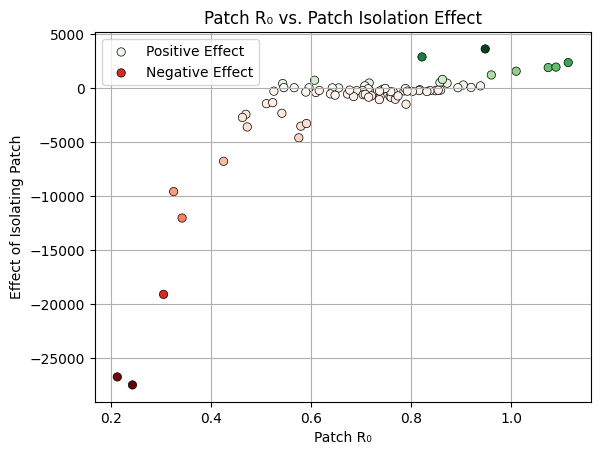

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Load patch isolation effects
with open("14 Day Fitted Beta 8 Day Buffer 280 Days Total Buenos Aires Patch Isolation Effects.pkl", 'rb') as file:
    patch_isolation_effects = pickle.load(file)

patch_isolation_effects = np.array(patch_isolation_effects)

# Separate positive and negative
positives = patch_isolation_effects > 0
negatives = patch_isolation_effects < 0

# Normalize correctly
pos_norm = patch_isolation_effects[positives] / patch_isolation_effects[positives].max()
neg_norm = patch_isolation_effects[negatives] / patch_isolation_effects[negatives].min()

# Get colors
pos_colors = plt.cm.Greens(pos_norm)
neg_colors = plt.cm.Reds(neg_norm)

# Plot
plt.figure()
plt.scatter(np.array(patch_R0s)[positives], patch_isolation_effects[positives],
            color=pos_colors, edgecolors='black', linewidth=0.5, label="Positive Effect")
plt.scatter(np.array(patch_R0s)[negatives], patch_isolation_effects[negatives],
            color=neg_colors, edgecolors='black', linewidth=0.5, label="Negative Effect")

plt.xlabel("Patch R₀")
plt.ylabel("Effect of Isolating Patch")
plt.title("Patch R₀ vs. Patch Isolation Effect")
plt.grid(True)
plt.legend()
plt.show()


NameError: name 'degrees' is not defined

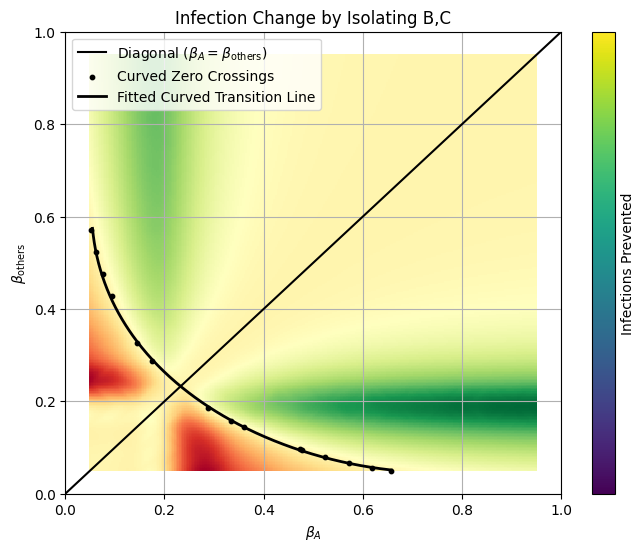

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev

# Assume X, Y, sizes, colors, pop_vector, list_of_p_matrices, gamma, run_model() already available

# 1. Recompute infections_prevented_list
infections_prevented_list = []

for beta_A, beta_others in zip(X, Y):
    beta = np.array([beta_A] + [beta_others]*8)

    I0_current = np.array([1,0,0,0,2,0,0,0,1])
    S0_current = pop_vector - I0_current
    I_total_0_current = I0_current.copy()

    totals = []
    for p_mat in list_of_p_matrices:
        Nj = pop_vector @ p_mat
        Nj[Nj == 0] = 1

        output = run_model(p_mat, (S0_current.copy(), I0_current.copy(), I_total_0_current.copy(), beta, gamma, 200))
        total_infected = output.sum(axis=0)
        totals.append(total_infected)

    infections_prevented = totals[0][-1] - totals[1][-1]
    infections_prevented_list.append(infections_prevented)

infections_prevented_list = np.array(infections_prevented_list)

# 2. Organize into grid for neighbor checking
beta_A_unique = np.unique(np.round(X, 4))
beta_others_unique = np.unique(np.round(Y, 4))

bubble_dict = {}
for i in range(len(X)):
    bubble_dict[(np.round(X[i],4), np.round(Y[i],4))] = infections_prevented_list[i]

transition_points = []

# 3. Walk grid to find zero crossings
for beta_A in beta_A_unique:
    for beta_others in beta_others_unique:
        key = (np.round(beta_A,4), np.round(beta_others,4))
        if key not in bubble_dict:
            continue

        # Right neighbor
        right_key = (np.round(beta_A+(beta_A_unique[1]-beta_A_unique[0]),4), np.round(beta_others,4))
        if right_key in bubble_dict:
            val1 = bubble_dict[key]
            val2 = bubble_dict[right_key]
            if val1 * val2 < 0:
                w = abs(val1) / (abs(val1) + abs(val2))
                x_zero = beta_A*(1-w) + right_key[0]*w
                y_zero = beta_others
                transition_points.append((x_zero, y_zero))

        # Up neighbor
        up_key = (np.round(beta_A,4), np.round(beta_others+(beta_others_unique[1]-beta_others_unique[0]),4))
        if up_key in bubble_dict:
            val1 = bubble_dict[key]
            val2 = bubble_dict[up_key]
            if val1 * val2 < 0:
                w = abs(val1) / (abs(val1) + abs(val2))
                x_zero = beta_A
                y_zero = beta_others*(1-w) + up_key[1]*w
                transition_points.append((x_zero, y_zero))

transition_points = np.array(transition_points)

# 4. Separate diagonal points from curved points
diag_thresh = 0.05  # threshold: how close to diagonal (beta_A ≈ beta_others)
diag_points = []
curve_points = []

for pt in transition_points:
    beta_A, beta_others = pt
    if abs(beta_A - beta_others) < diag_thresh:
        diag_points.append(pt)
    else:
        curve_points.append(pt)

diag_points = np.array(diag_points)
curve_points = np.array(curve_points)

# 5. Fit spline ONLY to curved points
if len(curve_points) > 0:
    sorted_idx = np.argsort(curve_points[:,0])
    curve_points = curve_points[sorted_idx]

    tck, u = splprep([curve_points[:,0], curve_points[:,1]], s=0.02)  # Smooth
    unew = np.linspace(0,1,300)
    out = splev(unew, tck)

# 6. Prepare grid for background coloring
from scipy.interpolate import griddata

plt.figure(figsize=(8,6))

# Create grid
xi = np.linspace(0, 1, 300)
yi = np.linspace(0, 1, 300)
xi, yi = np.meshgrid(xi, yi)

# Interpolate infections_prevented_list onto the grid
zi = griddata((X, Y), infections_prevented_list, (xi, yi), method='cubic')

# Plot the gradient background
plt.pcolormesh(xi, yi, zi, shading='auto', cmap='RdYlGn', vmin=np.min(infections_prevented_list), vmax=np.max(infections_prevented_list))

# Plot diagonal reference line
diag_line = np.linspace(0, 1, 100)
plt.plot(diag_line, diag_line, '-', color='black', label=r'Diagonal ($\beta_A = \beta_{\mathrm{others}}$)')

# Curved zero-crossing points
if len(curve_points) > 0:
    plt.scatter(curve_points[:,0], curve_points[:,1], c='k', s=10, label='Curved Zero Crossings')

# Fitted spline for curve
if len(curve_points) > 0:
    plt.plot(out[0], out[1], 'k-', linewidth=2, label='Fitted Curved Transition Line')

plt.xlabel(r'$\beta_A$')
plt.ylabel(r'$\beta_{\mathrm{others}}$')
plt.title('Infection Change by Isolating B,C')
plt.grid(True)
plt.xlim([0,1])
plt.ylim([0,1])
cbar = plt.colorbar(label='Infections Prevented')
cbar.set_ticks([])          # Remove ticks
cbar.ax.set_yticklabels([]) # Remove number labels
plt.legend()
plt.show()


[0, 1, 2, 3, 6] [0, 0, 0, 4, 8]


Isolating Patch: 100%|██████████| 5/5 [00:00<00:00, 5869.44it/s]


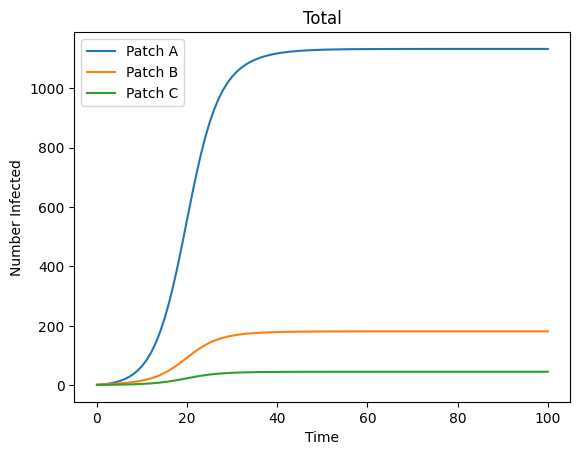

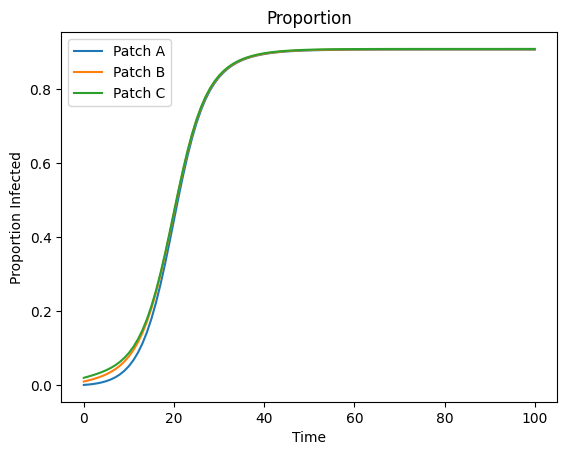


-------------------------------------


-------------------------------------



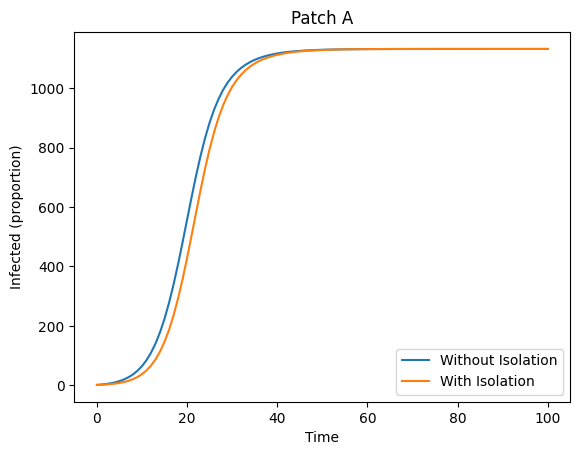

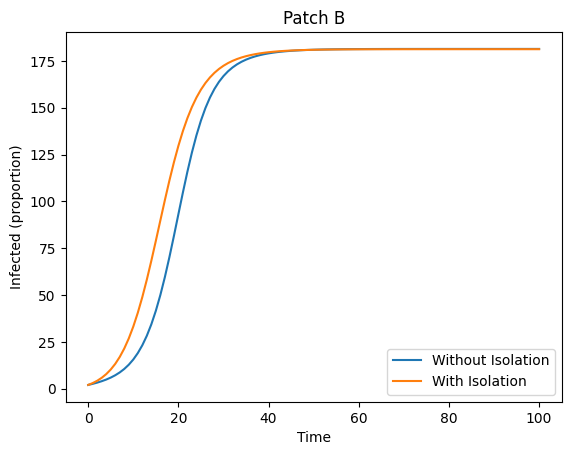

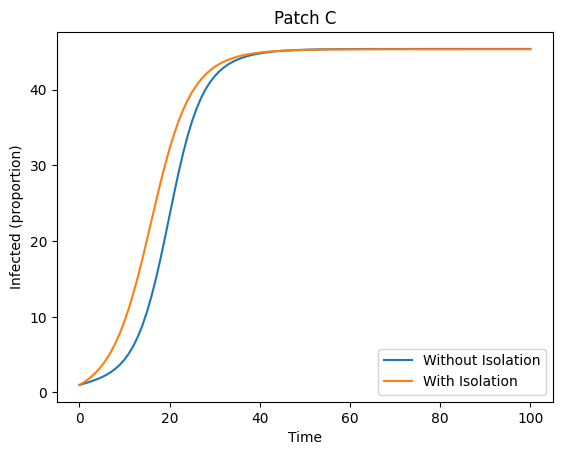

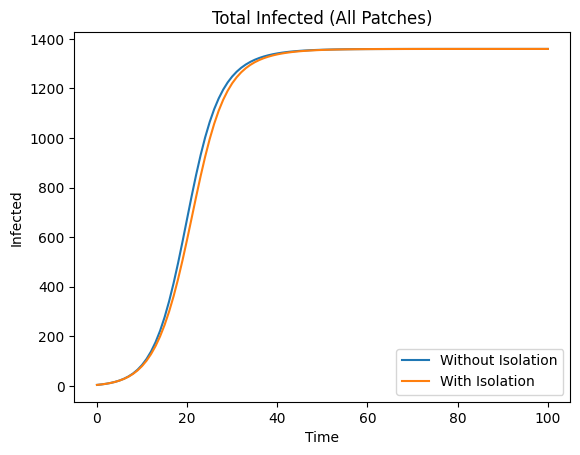

Total infections prevented by isolating ['A']: 0.07328978215764437


In [64]:
import scipy.sparse as sp

station_list = ["A","B","C"]
home_patches = [0,4,8]
travel_patches = [1,3,5,7]
valid_patch_indices = [0,1,3,4,5,7,8]

connections_list = []
for i in range(3):
    for j in range(3):
        connections_list.append((station_list[i],station_list[j]))



np.set_printoptions(suppress=True)





tspent = np.array([
    [1,0,0, 0,0,0, 0,0,0],
    [14/24, 1/24, 0, 1/24, 8/24, 0, 0, 0, 0],
    [10/24, 1/24, 0, 1/24, 0, 2/24, 0, 2/24, 8/24],
    [8/24, 1/24, 0, 1/24, 14/24, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 12/24, 2/24, 0, 2/24, 8/24],
    [8/24, 1/24, 0, 1/24, 0, 2/24, 0, 2/24, 10/24],
    [0, 0, 0, 0, 8/24, 2/24, 0, 2/24, 12/24],
    [0, 0, 0, 0, 0, 0, 0, 0, 1],
])

N = [1250,200,50]
# N = [500,500,500]

workpops = np.array([
    0.5*N[0],
    0.3*N[0],
    0.2*N[0],
    0.15*N[1],
    0.6*N[1],
    0.25*N[1],
    0.1*N[2],
    0.2*N[2],
    0.7*N[2],
])

expanded_p_matrix = (tspent.T*workpops).T


p_matrix = convert_back_to_classic_p(expanded_p_matrix)

sparse_expanded_p_matrix = sp.csr_matrix(expanded_p_matrix)



pairs_list = []
for i in range(3):
    for j in range(3):
        pairs_list.append((station_list[i],station_list[j]))
pairs_list = np.array(pairs_list)


isolated = sparse_isolate_patch(sparse_expanded_p_matrix,0,0.9).toarray()




def long(short):
    long = np.zeros(9)
    long[[0,4,8]] = short
    return long

# data_A = np.array([1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4])
# data_B = np.array([2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4])
# data_C = np.array([1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 5, 6])


pop_vector = long(N)

I0 = np.array([1,0,0,0,2,0,0,0,1])
S0 = pop_vector-I0
I_total_0 = I0.copy()
pop_vector,S0,I0

Nj = pop_vector @ p_matrix
for i in range(9):
    if Nj[i] == 0:
        Nj[i] = 1
        


def run_model(p_matrix,params):
    S0, I0, I_total0, beta, gamma, timesteps = params
    y0 = np.concatenate((S0, I0, I_total0))
    beta_p_matrix = csr_matrix(p_matrix).multiply(beta[:, None])
    t = np.linspace(0, timesteps, num=timesteps)
    y_log = np.zeros((len(t)+1, 27))
    y_log[0] = y0

    def sir(y):
        S, I, I_total = y[:9], y[9:18], y[18:]
        Ij = p_matrix.T @ I
        Ij_div_Nj = Ij / Nj
        inf = beta_p_matrix.multiply(S[:, None]) @ Ij_div_Nj
        dSdt = -inf
        dIdt = inf - gamma * I
        dI_totaldt = -dSdt
        return np.concatenate((dSdt, dIdt, dI_totaldt))

    for step in range(len(t)):
        y_log[step+1] = y_log[step] + sir(y_log[step])

    return y_log.T[18:]


everyone_else = 0.5
beta = np.array([everyone_else, everyone_else,everyone_else,everyone_else,everyone_else,everyone_else,everyone_else,everyone_else,everyone_else])
gamma = 1/5
gammas = np.ones(9)*gamma
timesteps = 100

output = run_model(p_matrix,(S0, I0, I_total_0, beta, gamma, timesteps))

t = np.linspace(0, timesteps, timesteps+1)

plt.plot(t, output[0], label='Patch A')
plt.plot(t, output[4], label='Patch B')
plt.plot(t, output[8], label='Patch C')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Number Infected")
plt.title("Total")
plt.show()

plt.plot(t, output[0]/pop_vector[0], label='Patch A')
plt.plot(t, output[4]/pop_vector[4], label='Patch B')
plt.plot(t, output[8]/pop_vector[8], label='Patch C')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Proportion Infected")
plt.title("Proportion")
plt.show()


print("\n-------------------------------------\n")
print("\n-------------------------------------\n")


list_of_p_matrices = []
list_of_p_matrices.append(p_matrix)



patches_to_isolate = [0]

modified_sparse = full_sparse_isolate(
    sparse_expanded_p_matrix,
    patch_indices=patches_to_isolate,
    station_list=station_list,
    pairs_list=pairs_list,
    home_patches=home_patches,
    modification=0.9
)


new_p = modified_sparse.toarray()

list_of_p_matrices.append(convert_back_to_classic_p(new_p))

results = []
totals = []

for p_matrix in list_of_p_matrices:
    Nj = pop_vector @ p_matrix
    Nj[Nj == 0] = 1

    output = run_model(p_matrix, (S0, I0, I_total_0, beta, gamma, timesteps))
    results.append(output[[0,4,8]])  # A, B, C
    totals.append(output.sum(axis=0))  # total across all patches

results = np.array(results)  # (num_runs, 3, timesteps+1)
totals = np.array(totals)    # (num_runs, timesteps+1)
t = np.linspace(0, timesteps, timesteps+1)

labels = ['Without Isolation', 'With Isolation']

# A, B, C plots
for i, patch_label in zip(range(3), ['Patch A', 'Patch B', 'Patch C']):
    plt.figure()
    for r, sim_label in zip(results, labels):
        plt.plot(t, r[i], label=sim_label)
    plt.title(patch_label)
    plt.xlabel("Time")
    plt.ylabel("Infected (proportion)")
    plt.legend()
    plt.show()

# Total plot
plt.figure()
for total, sim_label in zip(totals, labels):
    plt.plot(t, total, label=sim_label)
plt.title("Total Infected (All Patches)")
plt.xlabel("Time")
plt.ylabel("Infected")
plt.legend()
plt.show()
print(f"Total infections prevented by isolating {np.array(station_list)[patches_to_isolate]}:",totals[0][-1]-totals[1][-1])


In [274]:
for i in range(9):
    print(sparse_expanded_p_matrix.toarray()[i])
    print(isolated[i])
    print("\n")

[300.   0.   0.   0.   0.   0.   0.   0.   0.]
[300.   0.   0.   0.   0.   0.   0.   0.   0.]


[100.   2.   0.   2.  96.   0.   0.   0.   0.]
[190.    0.2   0.    0.2   9.6   0.    0.    0.    0. ]


[60.  2.  0.  2.  0.  3.  0.  3. 30.]
[60.  2.  0.  2.  0.  3.  0.  3. 30.]


[ 96.   2.   0.   2. 100.   0.   0.   0.   0.]
[  9.6   0.2   0.    0.2 190.    0.    0.    0.    0. ]


[  0.   0.   0.   0. 300.   0.   0.   0.   0.]
[  0.   0.   0.   0. 300.   0.   0.   0.   0.]


[  0.   0.   0.   0. 100.   3.   0.   3.  84.]
[  0.    0.    0.    0.  181.    0.3   0.    0.3   8.4]


[30.  2.  0.  2.  0.  3.  0.  3. 60.]
[30.  2.  0.  2.  0.  3.  0.  3. 60.]


[  0.   0.   0.   0.  84.   3.   0.   3. 100.]
[  0.    0.    0.    0.    8.4   0.3   0.    0.3 181. ]


[  0.   0.   0.   0.   0.   0.   0.   0. 300.]
[  0.   0.   0.   0.   0.   0.   0.   0. 300.]




In [46]:
isolated_p_matrix = convert_back_to_classic_p(isolated)
for i in range(9):
    round_to = 6
    print(np.round(p_matrix[i],round_to))
    print(np.round(isolated_p_matrix[i],round_to))
    print("\n")

[0.766667 0.006667 0.       0.006667 0.16     0.005    0.       0.005
 0.05    ]
[0.916667 0.003667 0.       0.003667 0.016    0.005    0.       0.005
 0.05    ]


[0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0.]


[0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0.]


[0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0.]


[0.13913  0.002899 0.       0.002899 0.724638 0.004348 0.       0.004348
 0.121739]
[0.013913 0.00029  0.       0.00029  0.972464 0.000435 0.       0.000435
 0.012174]


[0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0.]


[0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0.]


[0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0.]


[0.050847 0.00339  0.       0.00339  0.142373 0.010169 0.       0.010169
 0.779661]
[0.050847 0.00339  0.       0.00339  0.014237 0.005593 0.       0.005593
 0.916949]




In [75]:
def modify_p_matrix(p_matrix,percentage):
    modifier = percentage/100
    p_matrix2 = p_matrix.copy()
    
    for row in range(p_matrix.shape[0]):
        p_matrix2[row][row] += modifier*(np.sum(p_matrix2[row])-p_matrix2[row][row])
        p_matrix2[row] *= 1-modifier
        p_matrix2[row][row] /= (1-modifier)
    return p_matrix2

def modify_p_matrix_sparse(p_matrix, percentage):
    modifier = percentage / 100
    p_matrix2 = p_matrix.tocsr()  # Convert to CSR format for efficient row-wise operations
    
    row_sums = np.array(p_matrix2.sum(axis=1)).flatten()  # Compute row sums
    diag_values = p_matrix2.diagonal()  # Extract diagonal elements
    
    # Update diagonal first to match dense implementation
    new_diag_values = diag_values + modifier * (row_sums - diag_values)
    
    # Scale entire matrix
    p_matrix2 = p_matrix2.multiply(1 - modifier)
    
    # Correct the diagonal values properly
    p_matrix2.setdiag(new_diag_values)
    
    return p_matrix2

In [148]:
np.sum(short_pop_vector)

np.float64(1339058.7229030002)

In [17]:
timesteps = 100
print(p_matrix.shape)
p_matrix = modify_p_matrix_sparse(sparse_p,5).toarray()
print(p_matrix.shape)

short_pop_vector = np.array(list(pop_dict.values()))
pop_vector = np.zeros(6084)
pop_vector[np.arange(78) * (78 + 1)] = short_pop_vector

I0 = np.zeros(6084)
I0[home_patches] = current_cases
S0 = pop_vector - I0
I_total_0 = cum_cases

gamma = 1/5

params = [S0, I0, I_total_0, beta, gamma, timesteps]
sol = run_model_London(params)

totals = sol[2]
I_span = sol[1]



(63001, 63001)
(63001, 63001)


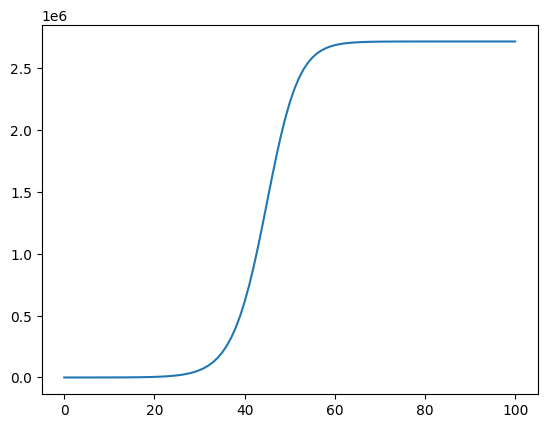

In [18]:
tspan = np.linspace(0,timesteps,timesteps+1)
plt.plot(tspan,np.sum(I_span,axis=0))


Running simulations: 100%|██████████| 6/6 [01:21<00:00, 13.65s/run]


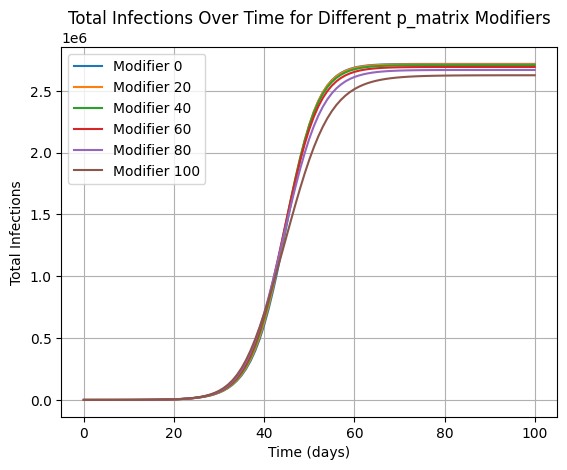

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress bar

# Define time range
timesteps = 100
tspan = np.linspace(0, timesteps, timesteps+1)

# Initialize storage for results
modifier_values = np.arange(0, 120, 20)  # [0, 5, 10, ..., 50]
infection_sums = []

# Loop over modifier values with progress bar
for modifier in tqdm(modifier_values, desc="Running simulations", unit="run"):
    # Modify p_matrix
    p_matrix = modify_p_matrix_sparse(sparse_p,modifier).toarray()

    # Define initial conditions
    short_pop_vector = np.array(list(pop_dict.values()))
    pop_vector = np.zeros(6084)
    pop_vector[np.arange(78) * (78 + 1)] = short_pop_vector

    I0 = np.zeros(6084)
    I0[home_patches] = current_cases
    S0 = pop_vector - I0
    I_total_0 = cum_cases

    # Define model parameters
    gamma = 1/5
    params = [S0, I0, I_total_0, beta, gamma, timesteps]

    # Solve the model
    sol = run_model_London(params)

    # Extract the infected subpopulation
    I_span = sol[1]
    
    # Compute the total number of infections at each timestep
    total_infections = np.sum(I_span, axis=0)
    
    # Store the result
    infection_sums.append(total_infections)

    # Plot each curve
    plt.plot(tspan, total_infections, label=f"Modifier {modifier}")

# Configure the plot
plt.xlabel("Time (days)")
plt.ylabel("Total Infections")
plt.title("Total Infections Over Time for Different p_matrix Modifiers")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress bar

# Define time range
timesteps = 150

# Initialize storage for results
modifier_values = np.arange(0, 120, 20)  # [0, 20, 40, ..., 100]
final_infection_counts = []

# Loop over modifier values with progress bar
for modifier in tqdm(modifier_values, desc="Running simulations", unit="run"):
    # Modify p_matrix
    p_matrix = modify_p_matrix_sparse(sparse_p, modifier).toarray()

    # Define initial conditions
    short_pop_vector = np.array(list(pop_dict.values()))
    pop_vector = np.zeros(6084)
    pop_vector[np.arange(78) * (78 + 1)] = short_pop_vector

    I0 = np.zeros(6084)
    I0[home_patches] = current_cases
    S0 = pop_vector - I0
    I_total_0 = cum_cases

    # Define model parameters
    gamma = 1/5
    params = [S0, I0, I_total_0, beta, gamma, timesteps]

    # Solve the model
    sol = run_model_London(params)

    # Extract the infected subpopulation at the final timestep
    I_span = sol[1]
    final_infections = np.sum(I_span[:, -1])  # Sum over the last timestep

    # Store the result
    final_infection_counts.append(final_infections)


Running simulations: 100%|██████████| 6/6 [01:53<00:00, 18.95s/run]


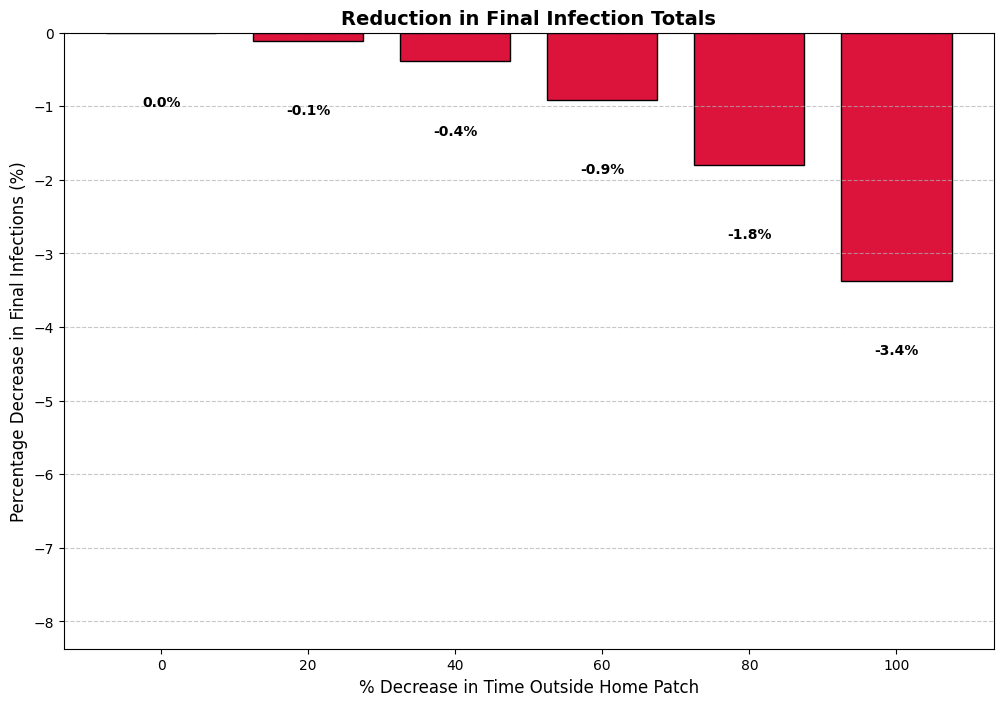

In [23]:

# Compute percentage decrease from Modifier 0
baseline = final_infection_counts[0]
percentage_decreases = [(count / baseline - 1) * 100 for count in final_infection_counts]  # Negative values

# Plot bar chart
plt.figure(figsize=(12, 8))
bars = plt.bar(modifier_values, percentage_decreases, color="crimson", edgecolor="black", width=15)

# Add labels on top of bars (now at the bottom since bars are negative)
for bar, percent in zip(bars, percentage_decreases):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 1, 
             f"{percent:.1f}%", ha="center", fontsize=10, fontweight="bold")

# Configure the plot
plt.xlabel("% Decrease in Time Outside Home Patch", fontsize=12)
plt.ylabel("Percentage Decrease in Final Infections (%)", fontsize=12)
plt.title("Reduction in Final Infection Totals", fontsize=14, fontweight="bold")
plt.xticks(modifier_values, fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(min(percentage_decreases) - 5, 0)  # Ensure negative direction is clear
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()


(77, 63002)
step: 0
step: 1
step: 2
step: 3
step: 4
step: 5
step: 6
step: 7
step: 8
step: 9
step: 10
step: 11
step: 12
step: 13
step: 14
step: 15
step: 16
step: 17
step: 18
step: 19
step: 20
step: 21
step: 22
step: 23
step: 24
step: 25
step: 26
step: 27
step: 28
step: 29
step: 30
step: 31
step: 32
step: 33
step: 34
step: 35
step: 36
step: 37
step: 38
step: 39
step: 40
step: 41
step: 42
step: 43
step: 44
step: 45
step: 46
step: 47
step: 48
step: 49
step: 50
step: 51
step: 52
step: 53
step: 54
step: 55
step: 56
step: 57
step: 58
step: 59
step: 60
step: 61
step: 62
step: 63
step: 64
step: 65
step: 66
step: 67
step: 68
step: 69
step: 70
step: 71
step: 72
step: 73
step: 74
step: 75


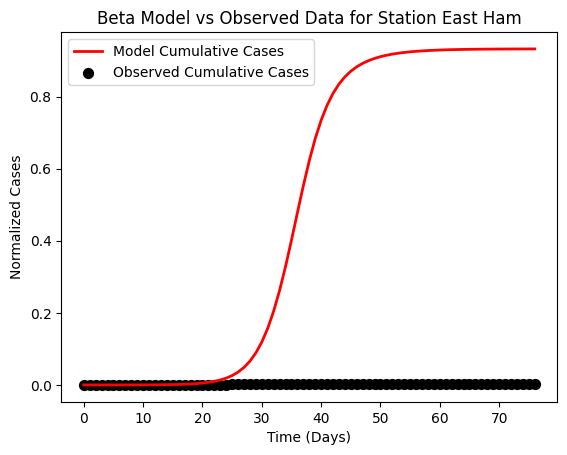

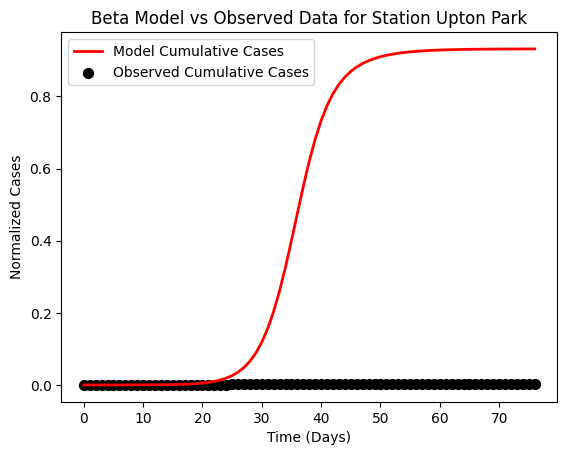

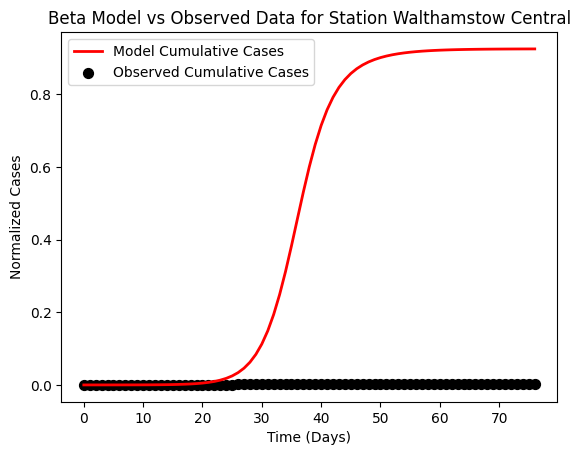

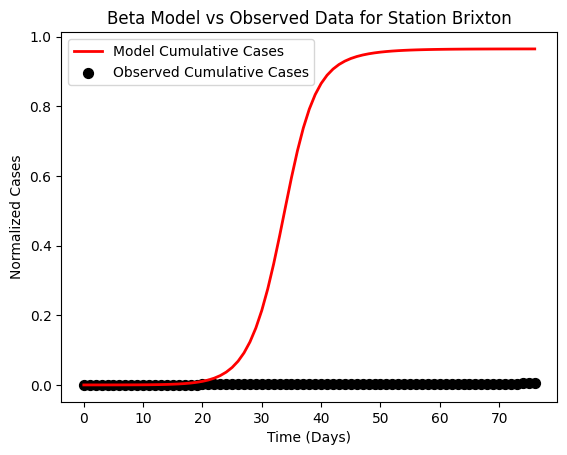

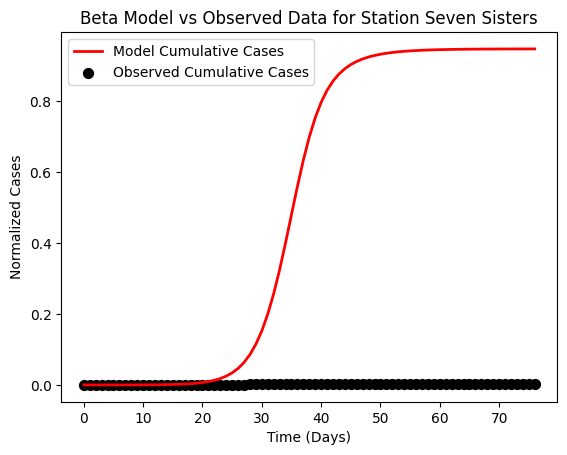

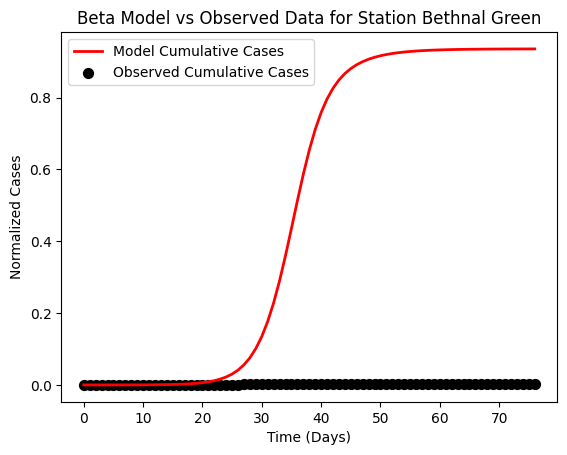

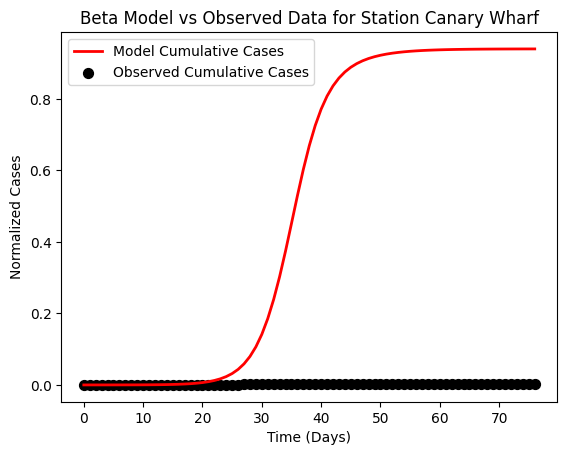

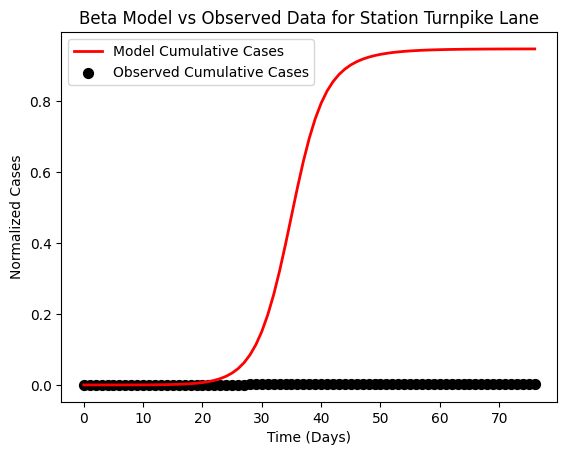

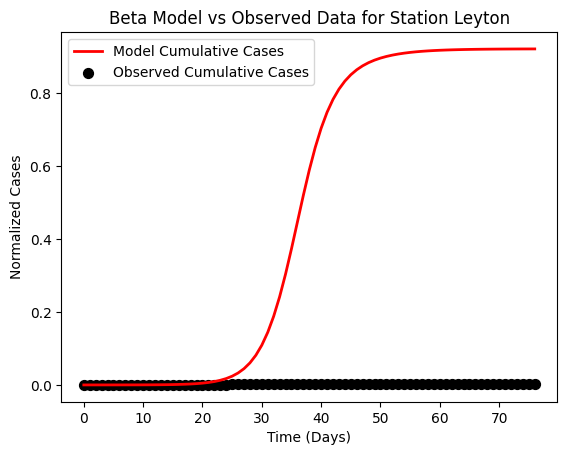

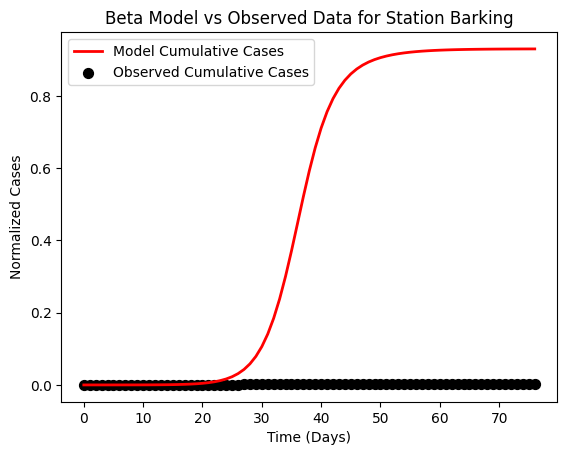

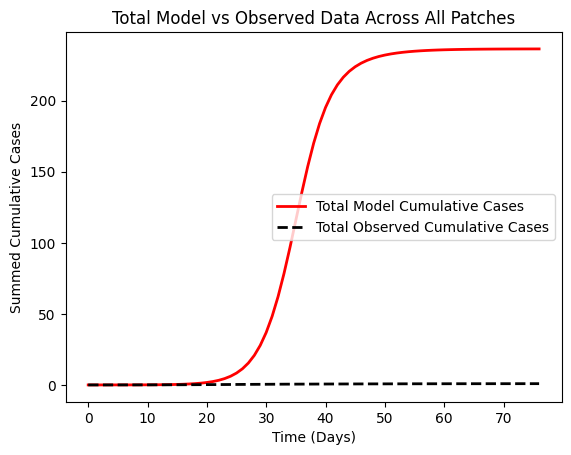


Total Progress:   0%|          | 0/25 [01:37<?, ?it/s]


KeyboardInterrupt: 

In [188]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import zoom

# Define lighter sampling
num_indices_list = np.linspace(5, 200, 5, dtype=int)  # 5 points
isolation_strength_list = np.linspace(0.1, 1.0, 5)    # 5 points
result_grid = np.zeros((len(isolation_strength_list), len(num_indices_list)))

# Precompute top patch indices
indices_dict = {}
for num_indices in num_indices_list:
    idx = np.argpartition(patch_R0s, -num_indices)[-num_indices:]
    indices_dict[num_indices] = idx[np.argsort(patch_R0s[idx])[::-1]]

# Solve once for base (no isolation) solution
solution_base, params_base = plot_best_beta_vs_data(all_station_timeseries, pop_dict)
y1_sum_base = solution_base[2][home_patches].sum(axis=0)

total_runs = len(isolation_strength_list) * len(num_indices_list)
pbar = tqdm(total=total_runs, desc="Total Progress")

for i, isolation_strength in enumerate(isolation_strength_list):
    for j, num_indices in enumerate(num_indices_list):
        # Step 1: isolate patches
        indices = indices_dict[num_indices]
        modified_sparse_p = sparse_expanded_p_matrix.copy()
        for patch in indices:
            modified_sparse_p = sparse_isolate_patch(modified_sparse_p, patch, isolation_strength)

        second_p_matrix = convert_back_to_classic_p(modified_sparse_p)
        sparse_second_p = csr_matrix(second_p_matrix)

        # Step 2: run model with isolation
        solution_with_iso, params_with_iso = plot_best_beta_vs_data_with_isolation(all_station_timeseries, pop_dict)

        # Step 3: calculate final difference
        y2_sum = solution_with_iso[2][home_patches].sum(axis=0)
        final_difference = (y1_sum_base - y2_sum)[-1]

        result_grid[i, j] = final_difference

        pbar.update(1)

pbar.close()

# Smooth interpolation for better visualization
result_grid_smooth = zoom(result_grid, 3, order=3)

# Plot
plt.figure(figsize=(10,8))
plt.imshow(result_grid_smooth, aspect='auto', origin='lower', 
           extent=[num_indices_list[0], num_indices_list[-1], 
                   isolation_strength_list[0], isolation_strength_list[-1]])
plt.colorbar(label='Final y1_sum - y2_sum')
plt.xlabel('Number of Isolated Patches')
plt.ylabel('Isolation Strength')
plt.title('Impact of Isolation on Final Outcome (Smoothed)')
plt.tight_layout()
plt.show()


In [ ]:
# PIECEWISE FUNCTION
# Define function to process solution
def process_solution(solution,timesteps):
    # Grouping by station subpopulation
    S_sol = solution[:6084]
    I_sol = solution[6084:12168]
    I_sol_total = solution[12168:]

    return [S_sol,I_sol,I_sol_total]



def run_model_London_with_isolation(params):
    S0,I0,I_total0,beta,gamma,timesteps = params
    
    if beta.shape[0]==837:
        beta = expand_betas(beta,6084)

    
    # Ensure no dividing by zero
    Nj[Nj == 0] = 1
    
    # Set up initial y0 vector
    y0 = np.concatenate((S0,I0,I_total0))
    
    # beta_p_matrix = (beta*p_matrix.T).T
    # beta_p_matrix = beta[:, None] * p_matrix 
    beta_p_matrix = sparse_p.multiply(beta[:, None])
    
    t = np.linspace(0,timesteps-1,num=timesteps)
    
    
    
    def sir(y,timestep,used_p,used_p_sparse,bpm):
        S = y[:6084]
        I = y[6084:12168]
        I_total = y[12168:]

        dSdt = np.zeros_like(S)
        dIdt = np.zeros_like(I)
        dI_totaldt = np.zeros_like(I_total)

        Ij = used_p.T @ I
        
        
        method = "vector"
        
        if method == "vector":

            # Compute Ij_div_Nj efficiently
            Ij_div_Nj = Ij / Nj  # Shape (6084,)
        
            # Vectorized computation of infection terms using sparse matrix multiplication
            infection_terms = bpm.multiply(S[:, None])  # (6084, 6084)
            infection_terms = infection_terms @ Ij_div_Nj  # (6084,)
        
            # Update derivatives
            dSdt -= infection_terms
            dIdt += infection_terms
            

        else:
            # Essentially, for all i, all j, dSdt[i] += -beta[j]*p_matrix[i][j]*S[i]*Ij[j]/Nj[j]
            for i in valid_patch_indices:
                for j in valid_patch_indices:
                    dSdt[i] += -beta[j]*used_p[i][j]*S[i]*Ij[j]/Nj[j]
            dIdt -= dSdt
    
        dI_totaldt += dIdt

        # Add the gamma terms
        dIdt -= gamma * I
        # dSdt += gamma * I

        # Concatenate results
        dx = np.concatenate((dSdt, dIdt, dI_totaldt))

        return dx
    
    y_log = np.zeros((len(t)+1,18252))
    y_log[0] = y0.copy()
    
    beta_p_matrix = sparse_p.multiply(beta[:, None])
    
    fitting_days = 14
    isolation_period = 90

    for step in range(len(t)):
        if step == fitting_days:
            beta_p_matrix = sparse_second_p.multiply(beta[:, None])
        if step == (fitting_days+isolation_period):
            beta_p_matrix = sparse_p.multiply(beta[:, None])
            
        if step >= fitting_days and step < (fitting_days+isolation_period):
            results = sir(y_log[step],step,second_p_matrix,sparse_second_p,beta_p_matrix)
        else:
            results = sir(y_log[step],step,p_matrix,sparse_p,beta_p_matrix)
        # print("step:",step)
        y_log[step+1] = y_log[step] + results
    
    solution = process_solution(y_log.T,timesteps)
    
    return solution
    
    
def plot_best_beta_vs_data_with_isolation(full_timeseries, pop_dict):
    """
    Extracts the relevant data, runs the SIR model with best_beta_yet, 
    and plots the beta values against the corresponding observed data.

    Parameters:
        full_timeseries (array-like): The full dataset of observed values.
        pop_dict (dict): Dictionary mapping population values.
    """
     # Load data
    working_timeseries = expand_timeseries(full_timeseries)
    
    short_pop_vector = np.array(list(pop_dict.values()))
    pop_vector = expand_array(short_pop_vector)
    
    day_list = np.arange(day_range)  # There are day_range days

    # Stack so each row is [day_index, corresponding 9 values]
    data = np.column_stack((day_list[:, None], working_timeseries))

    tspan = data[:, 0]
    timespan = tspan.shape[0] - 1
    gamma = 1 / 5

    # print(data.shape)
    
    I0 = np.zeros(6084)
    I0[home_patches] = current_cases
    S0 = pop_vector - I0
    I_total_0 = cum_cases
    
    params = [S0, I0, I_total_0, best_beta_yet, gamma, timespan]
    solution = run_model_London_with_isolation(params)
    y = solution[2]

    I_sum_model = compress_timeseries(y.T)
    raw_real_data = compress_timeseries(data.T[1:].T)
    normalizer = compress_array(pop_vector)[:, np.newaxis]
    test_data = I_sum_model / normalizer
    real_data = raw_real_data / normalizer

    # Get indices of the 10 stations with the highest total populations
    top_10_indices = np.argsort(-short_pop_vector)[:10]
    

    # Plot results
    # for i in top_10_indices:
        # plt.figure()
        # plt.plot(data[:, 0], test_data[i], 'r-', linewidth=2, label='Model Cumulative Cases')
        # plt.scatter(data[:, 0], real_data[i], c='k', s=50, label='Observed Cumulative Cases')

        # plt.xlabel('Time (Days)')
        # plt.ylabel('Normalized Cases')
        # plt.title(f'Beta Model vs Observed Data for Station {station_list[i]}')
        # plt.legend()
        # plt.show()
        
    # Plot total summed data across all patches
    summed_model = test_data.sum(axis=0)
    summed_real = real_data.sum(axis=0)

    # plt.figure()
    # plt.plot(data[:, 0], summed_model, 'r-', linewidth=2, label='Total Model Cumulative Cases')
    # plt.plot(data[:, 0], summed_real, 'k--', linewidth=2, label='Total Observed Cumulative Cases')
    # plt.xlabel('Time (Days)')
    # plt.ylabel('Summed Cumulative Cases')
    # plt.title('Total Model vs Observed Data Across All Patches')
    # plt.legend()
    # plt.show()
        
    return np.array(solution),params


import numpy as np
import pickle
import sys
import os
import contextlib
import matplotlib
from tqdm import tqdm
from scipy.sparse import csr_matrix

# Suppress matplotlib GUI
matplotlib.use('Agg')

# Load travel times
with open("combined_travel_times.pkl", "rb") as file:
    travel_times = pickle.load(file)

# Build travel vector
connections_list = [(station_list[i], station_list[j]) for i in range(78) for j in range(78)]
travel_vector = np.zeros(6084)
for i, current_leg in enumerate(connections_list):
    if current_leg[0] == current_leg[1]:
        travel_vector[i] = 8/24
    elif current_leg in travel_times:
        travel_vector[i] = travel_times[current_leg] / (60*24)

# Initialize
patch_isolation_benefits = []

# Save original stdout
saved_stdout = sys.stdout
saved_stderr = sys.stderr

# Suppress everything except tqdm
class TqdmCompatibleFile:
    def write(self, x):
        if x.strip():
            saved_stdout.write(x)
    def flush(self):
        saved_stdout.flush()

sys.stdout = TqdmCompatibleFile()
sys.stderr = TqdmCompatibleFile()

solution, params = plot_best_beta_vs_data(all_station_timeseries, pop_dict)
y1_sum = solution[2][home_patches].sum(axis=0)

try:
    for patch in tqdm(range(78), desc="Evaluating isolated matrices one by one"):
        # Load precomputed isolated matrix
        isolated_p_matrix_path = f"isolated_p_matrices_ba/isolated_p_matrix_patch_{patch}.pkl"
        if not os.path.exists(isolated_p_matrix_path):
            continue  # Skip if missing
        
        with open(isolated_p_matrix_path, "rb") as f:
            sparse_second_p = pickle.load(f)
            
        second_p_matrix = sparse_second_p.toarray()
        
        # Simulate using loaded matrix
        
        solution_with_iso, params_with_iso = plot_best_beta_vs_data_with_isolation(all_station_timeseries, pop_dict)

        
        y2_sum = solution_with_iso[2][home_patches].sum(axis=0)
        infections_prevented = (y1_sum - y2_sum)[-1]

        patch_isolation_benefits.append(infections_prevented)
finally:
    sys.stdout = saved_stdout
    sys.stderr = saved_stderr

In [ ]:
def run_model_segment(y0_state, second_p_matrix, beta, gamma, segment_days=30):
    """
    Simulates a segment of the model starting from y0_state using a given second_p_matrix.

    Parameters:
        y0_state (array): The initial state vector (length 18252).
        second_p_matrix (array): The classic-format p-matrix to use during the segment.
        beta (array): The beta vector for the segment.
        gamma (float): The recovery rate.
        segment_days (int): Number of days to simulate.

    Returns:
        solution (list): Processed [S, I, I_total] arrays over the segment.
    """
    from scipy.sparse import csr_matrix
    t_segment = np.linspace(0, segment_days - 1, segment_days)
    
    used_sparse_p = csr_matrix(second_p_matrix)
    beta_p_matrix = used_sparse_p.multiply(beta[:, None])
    
    def sir_segment(y, timestep):
        S = y[:6084]
        I = y[6084:12168]
        I_total = y[12168:]

        dSdt = np.zeros_like(S)
        dIdt = np.zeros_like(I)
        dI_totaldt = np.zeros_like(I_total)

        Ij = used_sparse_p.T @ I
        Ij_div_Nj = Ij / Nj

        infection_terms = beta_p_matrix.multiply(S[:, None]) @ Ij_div_Nj
        dSdt -= infection_terms
        dIdt += infection_terms
        dI_totaldt += infection_terms

        dIdt -= gamma * I

        dx = np.concatenate((dSdt, dIdt, dI_totaldt))
        return dx

    y_log = np.zeros((segment_days + 1, 18252))
    y_log[0] = y0_state.copy()

    for step in range(segment_days):
        results = sir_segment(y_log[step], step)
        y_log[step + 1] = y_log[step] + results

    return process_solution(y_log.T, segment_days)



# Load travel times
with open("combined_travel_times.pkl", "rb") as file:
    travel_times = pickle.load(file)

# Build travel vector
connections_list = [(station_list[i], station_list[j]) for i in range(78) for j in range(78)]
travel_vector = np.zeros(6084)
for i, current_leg in enumerate(connections_list):
    if current_leg[0] == current_leg[1]:
        travel_vector[i] = 8/24
    elif current_leg in travel_times:
        travel_vector[i] = travel_times[current_leg] / (60*24)

# Initialize
patch_isolation_benefits = []

# Save original stdout
saved_stdout = sys.stdout
saved_stderr = sys.stderr

# Suppress everything except tqdm
class TqdmCompatibleFile:
    def write(self, x):
        if x.strip():
            saved_stdout.write(x)
    def flush(self):
        saved_stdout.flush()

sys.stdout = TqdmCompatibleFile()
sys.stderr = TqdmCompatibleFile()

solution, params = plot_best_beta_vs_data(all_station_timeseries, pop_dict)
y1_sum = solution[2][home_patches].sum(axis=0)

try:
    for patch in tqdm(range(78), desc="Evaluating isolated matrices one by one"):
        # Load precomputed isolated matrix
        isolated_p_matrix_path = f"isolated_p_matrices_ba/isolated_p_matrix_patch_{patch}.pkl"
        if not os.path.exists(isolated_p_matrix_path):
            continue  # Skip if missing
        
        with open(isolated_p_matrix_path, "rb") as f:
            sparse_second_p = pickle.load(f)
            
        second_p_matrix = sparse_second_p.toarray()
        
        # Simulate using loaded matrix
        
        solution_with_iso, params_with_iso = plot_best_beta_vs_data_with_isolation(all_station_timeseries, pop_dict)

        
        y2_sum = solution_with_iso[2][home_patches].sum(axis=0)
        infections_prevented = (y1_sum - y2_sum)[-1]

        patch_isolation_benefits.append(infections_prevented)
finally:
    sys.stdout = saved_stdout
    sys.stderr = saved_stderr
    
patch_isolation_effects = np.array(patch_isolation_benefits)
    
# Sort patches most helpful first
patch_order = np.argsort(-np.array(patch_isolation_effects))

# Initial baseline solution
solution, params = plot_best_beta_vs_data(all_station_timeseries, pop_dict)
y1_sum = solution[2][home_patches].sum(axis=0)

final_infections_prevented = []

for n in tqdm(range(1, len(patch_order)+1), desc="Increasing number of patches isolated"):
    isolated_patches = patch_order[:n]
    patch_station_names = get_patch_station_names(isolated_patches, station_list)
    isolation_strength = 0.9

    modified_expanded_p_matrix = full_sparse_isolate_ultrafast_csr(
        sparse_expanded_p_matrix,
        patch_station_names,
        station_to_rows,
        row_home_patches,
        modification=isolation_strength
    ).toarray()

    second_p_matrix = convert_back_to_classic_p(modified_expanded_p_matrix)
    sparse_second_p = csr_matrix(second_p_matrix)

    solution_with_iso, params_with_iso = plot_best_beta_vs_data_with_isolation(all_station_timeseries, pop_dict)
    y2_sum = solution_with_iso[2][home_patches].sum(axis=0)

    infections_prevented = (y1_sum - y2_sum)[-1]
    final_infections_prevented.append(infections_prevented)


# PIECEWISE FUNCTION 2
# Define function to process solution
def process_solution(solution,timesteps):
    # Grouping by station subpopulation
    S_sol = solution[:6084]
    I_sol = solution[6084:12168]
    I_sol_total = solution[12168:]

    return [S_sol,I_sol,I_sol_total]



def run_model_London_with_isolation(params):
    S0,I0,I_total0,beta,gamma,timesteps = params
    
    if beta.shape[0]==837:
        beta = expand_betas(beta,6084)

    
    # Ensure no dividing by zero
    Nj[Nj == 0] = 1
    
    # Set up initial y0 vector
    y0 = np.concatenate((S0,I0,I_total0))
    
    # beta_p_matrix = (beta*p_matrix.T).T
    # beta_p_matrix = beta[:, None] * p_matrix 
    beta_p_matrix = sparse_p.multiply(beta[:, None])
    
    t = np.linspace(0,timesteps-1,num=timesteps)
    
    
    
    def sir(y,timestep,used_p,used_p_sparse,bpm):
        S = y[:6084]
        I = y[6084:12168]
        I_total = y[12168:]

        dSdt = np.zeros_like(S)
        dIdt = np.zeros_like(I)
        dI_totaldt = np.zeros_like(I_total)

        Ij = used_p.T @ I
        
        
        method = "vector"
        
        if method == "vector":

            # Compute Ij_div_Nj efficiently
            Ij_div_Nj = Ij / Nj  # Shape (6084,)
        
            # Vectorized computation of infection terms using sparse matrix multiplication
            infection_terms = bpm.multiply(S[:, None])  # (6084, 6084)
            infection_terms = infection_terms @ Ij_div_Nj  # (6084,)
        
            # Update derivatives
            dSdt -= infection_terms
            dIdt += infection_terms
            

        else:
            # Essentially, for all i, all j, dSdt[i] += -beta[j]*p_matrix[i][j]*S[i]*Ij[j]/Nj[j]
            for i in valid_patch_indices:
                for j in valid_patch_indices:
                    dSdt[i] += -beta[j]*used_p[i][j]*S[i]*Ij[j]/Nj[j]
            dIdt -= dSdt
    
        dI_totaldt += dIdt

        # Add the gamma terms
        dIdt -= gamma * I
        # dSdt += gamma * I

        # Concatenate results
        dx = np.concatenate((dSdt, dIdt, dI_totaldt))

        return dx
    
    y_log = np.zeros((len(t)+1,18252))
    y_log[0] = y0.copy()
    
    beta_p_matrix = sparse_p.multiply(beta[:, None])
    
    fitting_days = 14
    isolation_period = 30

    for step in range(len(t)):
        if step == fitting_days:
            beta_p_matrix = sparse_second_p.multiply(beta[:, None])
        # Inside run_model_London_with_isolation after fitting_days
        if step >= fitting_days and (step - fitting_days) % isolation_period == 0:
            # Recalculate patch benefits
            patch_isolation_benefits = []
            solution_base = y_log[step].copy()

            for patch in range(78):
                path = f"isolated_p_matrices_ba/isolated_p_matrix_patch_{patch}.pkl"
                if not os.path.exists(path): continue
                with open(path, "rb") as f:
                    iso_sparse_p = pickle.load(f)
                iso_p = iso_sparse_p.toarray()
                temp_sol = run_model_segment(solution_base, iso_p, beta, gamma, 30)  # Define this
                y2 = temp_sol[2][home_patches].sum(axis=0)
                y1 = y_log[step][12168 + np.array(home_patches)].sum()
                patch_isolation_benefits.append(y1 - y2[-1])

            patch_order = np.argsort(-np.array(patch_isolation_benefits))
            # Recompute benefit of isolating top k patches for k = 1 to 78
            best_total = -np.inf
            best_n = 1

            for n in range(1, 79):
                candidate_patches = patch_order[:n]
                patch_station_names = get_patch_station_names(candidate_patches, station_list)

                modified_expanded_p_matrix = full_sparse_isolate_ultrafast_csr(
                    sparse_expanded_p_matrix,
                    patch_station_names,
                    station_to_rows,
                    row_home_patches,
                    modification=0.9
                ).toarray()

                second_p_matrix_candidate = convert_back_to_classic_p(modified_expanded_p_matrix)
                sparse_candidate = csr_matrix(second_p_matrix_candidate)

                temp_sol = run_model_segment(solution_base, second_p_matrix_candidate, beta, gamma, 30)
                y2 = temp_sol[2][home_patches].sum(axis=0)
                y1 = solution_base[12168 + np.array(home_patches)].sum()
                benefit = y1 - y2[-1]

                if benefit > best_total:
                    best_total = benefit
                    best_n = n
                    best_sparse = sparse_candidate

            best_patches = patch_order[:best_n]
            patch_station_names = get_patch_station_names(best_patches, station_list)

            new_sparse = full_sparse_isolate_ultrafast_csr(
                sparse_expanded_p_matrix,
                patch_station_names,
                station_to_rows,
                row_home_patches,
                modification=0.9
            )

            sparse_second_p = csr_matrix(convert_back_to_classic_p(new_sparse.toarray()))
            second_p_matrix = sparse_second_p.toarray()
            beta_p_matrix = sparse_second_p.multiply(beta[:, None])
            
        if step >= fitting_days:
            results = sir(y_log[step],step,second_p_matrix,sparse_second_p,beta_p_matrix)
        else:
            results = sir(y_log[step],step,p_matrix,sparse_p,beta_p_matrix)
        # print("step:",step)
        y_log[step+1] = y_log[step] + results
    
    solution = process_solution(y_log.T,timesteps)
    
    return solution
    
    
def plot_best_beta_vs_data_with_isolation(full_timeseries, pop_dict):
    """
    Extracts the relevant data, runs the SIR model with best_beta_yet, 
    and plots the beta values against the corresponding observed data.

    Parameters:
        full_timeseries (array-like): The full dataset of observed values.
        pop_dict (dict): Dictionary mapping population values.
    """
     # Load data
    working_timeseries = expand_timeseries(full_timeseries)
    
    short_pop_vector = np.array(list(pop_dict.values()))
    pop_vector = expand_array(short_pop_vector)
    
    day_list = np.arange(day_range)  # There are day_range days

    # Stack so each row is [day_index, corresponding 9 values]
    data = np.column_stack((day_list[:, None], working_timeseries))

    tspan = data[:, 0]
    timespan = tspan.shape[0] - 1
    gamma = 1 / 5

    # print(data.shape)
    
    I0 = np.zeros(6084)
    I0[home_patches] = current_cases
    S0 = pop_vector - I0
    I_total_0 = cum_cases
    
    params = [S0, I0, I_total_0, best_beta_yet, gamma, timespan]
    solution = run_model_London_with_isolation(params)
    y = solution[2]

    I_sum_model = compress_timeseries(y.T)
    raw_real_data = compress_timeseries(data.T[1:].T)
    normalizer = compress_array(pop_vector)[:, np.newaxis]
    test_data = I_sum_model / normalizer
    real_data = raw_real_data / normalizer

    # Get indices of the 10 stations with the highest total populations
    top_10_indices = np.argsort(-short_pop_vector)[:10]
    

    # Plot results
    # for i in top_10_indices:
        # plt.figure()
        # plt.plot(data[:, 0], test_data[i], 'r-', linewidth=2, label='Model Cumulative Cases')
        # plt.scatter(data[:, 0], real_data[i], c='k', s=50, label='Observed Cumulative Cases')

        # plt.xlabel('Time (Days)')
        # plt.ylabel('Normalized Cases')
        # plt.title(f'Beta Model vs Observed Data for Station {station_list[i]}')
        # plt.legend()
        # plt.show()
        
    # Plot total summed data across all patches
    summed_model = test_data.sum(axis=0)
    summed_real = real_data.sum(axis=0)

    # plt.figure()
    # plt.plot(data[:, 0], summed_model, 'r-', linewidth=2, label='Total Model Cumulative Cases')
    # plt.plot(data[:, 0], summed_real, 'k--', linewidth=2, label='Total Observed Cumulative Cases')
    # plt.xlabel('Time (Days)')
    # plt.ylabel('Summed Cumulative Cases')
    # plt.title('Total Model vs Observed Data Across All Patches')
    # plt.legend()
    # plt.show()
        
    return np.array(solution),params

In [10]:
# PIECEWISE FUNCTION 2
# Define function to process solution
def process_solution(solution,timesteps):
    # Grouping by station subpopulation
    S_sol = solution[:6084]
    I_sol = solution[6084:12168]
    I_sol_total = solution[12168:]

    return [S_sol,I_sol,I_sol_total]



def run_model_London_with_isolation(params):
    S0,I0,I_total0,beta,gamma,timesteps = params
    
    if beta.shape[0]==837:
        beta = expand_betas(beta,6084)

    
    # Ensure no dividing by zero
    Nj[Nj == 0] = 1
    
    # Set up initial y0 vector
    y0 = np.concatenate((S0,I0,I_total0))
    
    # beta_p_matrix = (beta*p_matrix.T).T
    # beta_p_matrix = beta[:, None] * p_matrix 
    beta_p_matrix = sparse_p.multiply(beta[:, None])
    
    t = np.linspace(0,timesteps-1,num=timesteps)
    sparse_second_p = sparse_p  # start with the default sparse_p matrix
    second_p_matrix = sparse_p.toarray()

    
    
    def sir(y,timestep,used_p,used_p_sparse,bpm):
        S = y[:6084]
        I = y[6084:12168]
        I_total = y[12168:]

        dSdt = np.zeros_like(S)
        dIdt = np.zeros_like(I)
        dI_totaldt = np.zeros_like(I_total)

        Ij = used_p.T @ I
        
        
        method = "vector"
        
        if method == "vector":

            # Compute Ij_div_Nj efficiently
            Ij_div_Nj = Ij / Nj  # Shape (6084,)
        
            # Vectorized computation of infection terms using sparse matrix multiplication
            infection_terms = bpm.multiply(S[:, None])  # (6084, 6084)
            infection_terms = infection_terms @ Ij_div_Nj  # (6084,)
        
            # Update derivatives
            dSdt -= infection_terms
            dIdt += infection_terms
            

        else:
            # Essentially, for all i, all j, dSdt[i] += -beta[j]*p_matrix[i][j]*S[i]*Ij[j]/Nj[j]
            for i in valid_patch_indices:
                for j in valid_patch_indices:
                    dSdt[i] += -beta[j]*used_p[i][j]*S[i]*Ij[j]/Nj[j]
            dIdt -= dSdt
    
        dI_totaldt += dIdt

        # Add the gamma terms
        dIdt -= gamma * I
        # dSdt += gamma * I

        # Concatenate results
        dx = np.concatenate((dSdt, dIdt, dI_totaldt))

        return dx
    
    y_log = np.zeros((len(t)+1,18252))
    y_log[0] = y0.copy()
    
    beta_p_matrix = sparse_p.multiply(beta[:, None])
    
    fitting_days = 14
    isolation_period = 30

    for step in range(len(t)):
        if step == fitting_days:
            beta_p_matrix = sparse_second_p.multiply(beta[:, None])
        # Inside run_model_London_with_isolation after fitting_days
        if step >= fitting_days and (step - fitting_days) % isolation_period == 0:
            # Recalculate patch benefits
            patch_isolation_benefits = []
            solution_base = y_log[step].copy()

            for patch in range(78):
                path = f"isolated_p_matrices_ba/isolated_p_matrix_patch_{patch}.pkl"
                if not os.path.exists(path): continue
                with open(path, "rb") as f:
                    iso_sparse_p = pickle.load(f)
                iso_p = iso_sparse_p.toarray()
                temp_sol = run_model_segment(solution_base, iso_p, beta, gamma, 30)  # Define this
                y2 = temp_sol[2][home_patches].sum(axis=0)
                y1 = y_log[step][12168 + np.array(home_patches)].sum()
                patch_isolation_benefits.append(y1 - y2[-1])

            patch_order = np.argsort(-np.array(patch_isolation_benefits))
            # Recompute benefit of isolating top k patches for k = 1 to 78
            best_total = -np.inf
            best_n = 1

            for n in range(1, 79):
                candidate_patches = patch_order[:n]
                patch_station_names = get_patch_station_names(candidate_patches, station_list)

                modified_expanded_p_matrix = full_sparse_isolate_ultrafast_csr(
                    sparse_expanded_p_matrix,
                    patch_station_names,
                    station_to_rows,
                    row_home_patches,
                    modification=0.9
                ).toarray()

                second_p_matrix_candidate = convert_back_to_classic_p(modified_expanded_p_matrix)
                sparse_candidate = csr_matrix(second_p_matrix_candidate)

                temp_sol = run_model_segment(solution_base, second_p_matrix_candidate, beta, gamma, 30)
                y2 = temp_sol[2][home_patches].sum(axis=0)
                y1 = solution_base[12168 + np.array(home_patches)].sum()
                benefit = y1 - y2[-1]

                if benefit > best_total:
                    best_total = benefit
                    best_n = n
                    best_sparse = sparse_candidate

            best_patches = patch_order[:best_n]
            patch_station_names = get_patch_station_names(best_patches, station_list)

            new_sparse = full_sparse_isolate_ultrafast_csr(
                sparse_expanded_p_matrix,
                patch_station_names,
                station_to_rows,
                row_home_patches,
                modification=0.9
            )

            sparse_second_p = csr_matrix(convert_back_to_classic_p(new_sparse.toarray()))
            second_p_matrix = sparse_second_p.toarray()
            beta_p_matrix = sparse_second_p.multiply(beta[:, None])
            
        if step >= fitting_days:
            results = sir(y_log[step],step,second_p_matrix,sparse_second_p,beta_p_matrix)
        else:
            results = sir(y_log[step],step,p_matrix,sparse_p,beta_p_matrix)
        # print("step:",step)
        y_log[step+1] = y_log[step] + results
    
    solution = process_solution(y_log.T,timesteps)
    
    return solution

def plot_best_beta_vs_data_with_isolation(full_timeseries, pop_dict):
    """
    Extracts the relevant data, runs the SIR model with best_beta_yet, 
    and plots the beta values against the corresponding observed data.

    Parameters:
        full_timeseries (array-like): The full dataset of observed values.
        pop_dict (dict): Dictionary mapping population values.
    """
     # Load data
    working_timeseries = expand_timeseries(full_timeseries)
    
    short_pop_vector = np.array(list(pop_dict.values()))
    pop_vector = expand_array(short_pop_vector)
    
    day_list = np.arange(day_range)  # There are day_range days

    # Stack so each row is [day_index, corresponding 9 values]
    data = np.column_stack((day_list[:, None], working_timeseries))

    tspan = data[:, 0]
    timespan = tspan.shape[0] - 1
    gamma = 1 / 5

    # print(data.shape)
    
    I0 = np.zeros(6084)
    I0[home_patches] = current_cases
    S0 = pop_vector - I0
    I_total_0 = cum_cases
    
    params = [S0, I0, I_total_0, best_beta_yet, gamma, timespan]
    solution = run_model_London_with_isolation(params)
    y = solution[2]

    I_sum_model = compress_timeseries(y.T)
    raw_real_data = compress_timeseries(data.T[1:].T)
    normalizer = compress_array(pop_vector)[:, np.newaxis]
    test_data = I_sum_model / normalizer
    real_data = raw_real_data / normalizer

    # Get indices of the 10 stations with the highest total populations
    top_10_indices = np.argsort(-short_pop_vector)[:10]
    

    # Plot results
    # for i in top_10_indices:
        # plt.figure()
        # plt.plot(data[:, 0], test_data[i], 'r-', linewidth=2, label='Model Cumulative Cases')
        # plt.scatter(data[:, 0], real_data[i], c='k', s=50, label='Observed Cumulative Cases')

        # plt.xlabel('Time (Days)')
        # plt.ylabel('Normalized Cases')
        # plt.title(f'Beta Model vs Observed Data for Station {station_list[i]}')
        # plt.legend()
        # plt.show()
        
    # Plot total summed data across all patches
    summed_model = test_data.sum(axis=0)
    summed_real = real_data.sum(axis=0)

    # plt.figure()
    # plt.plot(data[:, 0], summed_model, 'r-', linewidth=2, label='Total Model Cumulative Cases')
    # plt.plot(data[:, 0], summed_real, 'k--', linewidth=2, label='Total Observed Cumulative Cases')
    # plt.xlabel('Time (Days)')
    # plt.ylabel('Summed Cumulative Cases')
    # plt.title('Total Model vs Observed Data Across All Patches')
    # plt.legend()
    # plt.show()
        
    return np.array(solution),params

def run_model_segment(y0_state, second_p_matrix, beta, gamma, segment_days=30):
    from scipy.sparse import csr_matrix
    t_segment = np.linspace(0, segment_days - 1, segment_days)
    used_sparse_p = csr_matrix(second_p_matrix)
    beta_p_matrix = used_sparse_p.multiply(beta[:, None])

    def sir_segment(y, timestep):
        S = y[:6084]
        I = y[6084:12168]
        I_total = y[12168:]

        dSdt = np.zeros_like(S)
        dIdt = np.zeros_like(I)
        dI_totaldt = np.zeros_like(I_total)

        Ij = used_sparse_p.T @ I
        Ij_div_Nj = Ij / Nj
        infection_terms = beta_p_matrix.multiply(S[:, None]) @ Ij_div_Nj

        dSdt -= infection_terms
        dIdt += infection_terms
        dI_totaldt += infection_terms
        dIdt -= gamma * I

        return np.concatenate((dSdt, dIdt, dI_totaldt))

    y_log = np.zeros((segment_days + 1, 18252))
    y_log[0] = y0_state.copy()

    for step in range(segment_days):
        results = sir_segment(y_log[step], step)
        y_log[step + 1] = y_log[step] + results

    return process_solution(y_log.T, segment_days)




matplotlib.use('Agg')

with open("combined_travel_times.pkl", "rb") as file:
    travel_times = pickle.load(file)

connections_list = [(station_list[i], station_list[j]) for i in range(78) for j in range(78)]
travel_vector = np.zeros(6084)
for i, current_leg in enumerate(connections_list):
    if current_leg[0] == current_leg[1]:
        travel_vector[i] = 8/24
    elif current_leg in travel_times:
        travel_vector[i] = travel_times[current_leg] / (60*24)

patch_isolation_benefits = []

saved_stdout = sys.stdout
saved_stderr = sys.stderr
class TqdmCompatibleFile:
    def write(self, x):
        if x.strip():
            saved_stdout.write(x)
    def flush(self):
        saved_stdout.flush()

sys.stdout = TqdmCompatibleFile()
sys.stderr = TqdmCompatibleFile()

solution, params = plot_best_beta_vs_data(all_station_timeseries, pop_dict)
y1_sum = solution[2][home_patches].sum(axis=0)

try:
    for patch in tqdm(range(78), desc="Evaluating isolated matrices one by one"):
        isolated_p_matrix_path = f"isolated_p_matrices_ba/isolated_p_matrix_patch_{patch}.pkl"
        if not os.path.exists(isolated_p_matrix_path):
            continue
        with open(isolated_p_matrix_path, "rb") as f:
            sparse_second_p = pickle.load(f)
        second_p_matrix = sparse_second_p.toarray()

        solution_with_iso, params_with_iso = plot_best_beta_vs_data_with_isolation(all_station_timeseries, pop_dict)
        y2_sum = solution_with_iso[2][home_patches].sum(axis=0)
        infections_prevented = (y1_sum - y2_sum)[-1]
        patch_isolation_benefits.append(infections_prevented)
finally:
    sys.stdout = saved_stdout
    sys.stderr = saved_stderr

patch_isolation_effects = np.array(patch_isolation_benefits)
patch_order = np.argsort(-patch_isolation_effects)

# Final simulation loop
solution, params = plot_best_beta_vs_data(all_station_timeseries, pop_dict)
y1_sum = solution[2][home_patches].sum(axis=0)

final_infections_prevented = []
isolation_history_indices = []

for n in tqdm(range(1, len(patch_order)+1), desc="Increasing number of patches isolated"):
    isolated_patches = patch_order[:n]
    patch_station_names = get_patch_station_names(isolated_patches, station_list)

    print(f"\n--- New Isolation Strategy Applied ---")
    print(f"Isolated Patch Indices: {isolated_patches}")
    print(f"Isolated Patch Names: {[station_list[i] for i in isolated_patches]}")
    print(f"Number of Isolated Patches: {len(isolated_patches)}\n")

    isolation_history_indices.append(isolated_patches.tolist())

    modified_expanded_p_matrix = full_sparse_isolate_ultrafast_csr(
        sparse_expanded_p_matrix,
        patch_station_names,
        station_to_rows,
        row_home_patches,
        modification=0.9
    ).toarray()

    second_p_matrix = convert_back_to_classic_p(modified_expanded_p_matrix)
    sparse_second_p = csr_matrix(second_p_matrix)

    solution_with_flexible_iso, params_with_iso = plot_best_beta_vs_data_with_isolation(
        all_station_timeseries, pop_dict
    )
    y2_sum = solution_with_flexible_iso[2][home_patches].sum(axis=0)

    infections_prevented = (y1_sum - y2_sum)[-1]
    final_infections_prevented.append(infections_prevented)

# Save final outputs
final_solution_with_flexible_iso = solution_with_flexible_iso
all_isolated_patch_indices_by_segment = isolation_history_indices


Evaluating isolated matrices one by one:   0%|          | 0/78 [02:22<?, ?it/s]

KeyboardInterrupt: 

In [21]:
path = "isolation_patch_history_by_step.pkl"
with open(path, "rb") as f:
    iso_history = pickle.load(f)
iso_history

[[77, 54], [48, 4], [39, 40], [13], [49], [66], [49], [66]]

In [ ]:
plt.ion()
%matplotlib notebook

# ========== Helper Functions ==========
def process_solution(solution, timesteps):
    S_sol = solution[:6084]
    I_sol = solution[6084:12168]
    I_sol_total = solution[12168:]
    return [S_sol, I_sol, I_sol_total]

def run_model_segment(y0_state, second_p_matrix, beta, gamma, segment_days=60):
    used_sparse_p = csr_matrix(second_p_matrix)
    beta_p_matrix = used_sparse_p.multiply(beta[:, None])

    def sir_segment(y):
        S = y[:6084]
        I = y[6084:12168]
        I_total = y[12168:]
        dSdt = np.zeros_like(S)
        dIdt = np.zeros_like(I)
        dI_totaldt = np.zeros_like(I_total)
        Ij = used_sparse_p.T @ I
        Ij_div_Nj = Ij / Nj
        infection_terms = beta_p_matrix.multiply(S[:, None]) @ Ij_div_Nj
        dSdt -= infection_terms
        dIdt += infection_terms
        dI_totaldt += infection_terms
        dIdt -= gamma * I
        return np.concatenate((dSdt, dIdt, dI_totaldt))

    y_log = np.zeros((segment_days + 1, 18252))
    y_log[0] = y0_state.copy()
    for step in range(segment_days):
        y_log[step + 1] = y_log[step] + sir_segment(y_log[step])
    return process_solution(y_log.T, segment_days)

# ========== Main Model Function ==========
def run_model_London_with_isolation(params):
    S0, I0, I_total0, beta, gamma, timesteps = params
    if beta.shape[0] == 837:
        beta = expand_betas(beta, 6084)
    Nj[Nj == 0] = 1
    y0 = np.concatenate((S0, I0, I_total0))
    t = np.linspace(0, timesteps - 1, num=timesteps)
    y_log = np.zeros((len(t) + 1, 18252))
    y_log[0] = y0.copy()
    sparse_second_p = sparse_p
    second_p_matrix = sparse_p.toarray()
    beta_p_matrix = sparse_p.multiply(beta[:, None])
    fitting_days = 14
    isolation_period = 60

    isolation_history_indices = []

    for step in tqdm(range(len(t)), desc="Simulating epidemic with isolation"):
        if step == fitting_days:
            beta_p_matrix = sparse_second_p.multiply(beta[:, None])

        if step >= fitting_days and (step - fitting_days) % isolation_period == 0:
            solution_base = y_log[step].copy()
            y1 = solution_base[12168 + np.array(home_patches)].sum()

            patch_benefits = []
            for patch in tqdm(range(78), desc="Isolating separately"):
                path = f"isolated_p_matrices_ba/isolated_p_matrix_patch_{patch}.pkl"
                if not os.path.exists(path):
                    continue
                with open(path, "rb") as f:
                    iso_sparse_p = pickle.load(f)
                iso_p = iso_sparse_p.toarray()
                intermediate = run_model_segment(solution_base, iso_p, beta, gamma, 60)
                y_after_iso = np.concatenate(intermediate, axis=0)[:,-1]
                post_iso = run_model_segment(y_after_iso, p_matrix, beta, gamma, 240 - step - 60)
                y2 = post_iso[2][home_patches].sum(axis=0)
                benefit = y1 - y2[-1]
                patch_benefits.append((patch, benefit))

            patch_order = [p for p, _ in sorted(patch_benefits, key=lambda x: -x[1])]
            benefits = [b for _, b in sorted(patch_benefits, key=lambda x: -x[1])]

            best_total = -np.inf
            best_n = 1
            best_sparse = None

            for n in range(1, 79):
                top_n = patch_order[:n]
                patch_station_names = get_patch_station_names(top_n, station_list)
                modified = full_sparse_isolate_ultrafast_csr(
                    sparse_expanded_p_matrix, patch_station_names,
                    station_to_rows, row_home_patches, modification=0.9
                ).toarray()
                classic_p = convert_back_to_classic_p(modified)
                sparse_candidate = csr_matrix(classic_p)
                temp_sol = run_model_segment(solution_base, classic_p, beta, gamma, 60)
                y2 = temp_sol[2][home_patches].sum(axis=0)
                benefit = y1 - y2[-1]
                if benefit > best_total:
                    best_total = benefit
                    best_n = n
                    best_sparse = sparse_candidate

            best_patches = patch_order[:best_n]


            n_vals = np.arange(1, len(benefits) + 1)
            plt.figure(figsize=(10, 6))
            plt.plot(n_vals, benefits, marker='o', label='Infections Prevented')
            plt.axvline(best_n, color='red', linestyle='--', label=f'Best n = {best_n}')
            plt.xlabel('Number of Patches Isolated (Top-N)', fontsize=14)
            plt.ylabel('Total Infections Prevented', fontsize=14)
            plt.title(f'Isolation Benefit at Day {step}', fontsize=16, fontweight='bold')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.draw()
            plt.pause(0.001)
            plt.savefig(f"isolation_benefit_day_{step}.png", dpi=300)
            plt.clf()

            isolation_history_indices.append(best_patches)

            print(f"\n--- Isolation Reassessment at Day {step} ---")
            print(f"Isolating patches: {best_patches}")
            print(f"Patch names: {[station_list[i] for i in best_patches]}")
            print(f"Number of patches isolated: {len(best_patches)}\n")

            patch_station_names = get_patch_station_names(best_patches, station_list)
            new_sparse = full_sparse_isolate_ultrafast_csr(
                sparse_expanded_p_matrix, patch_station_names,
                station_to_rows, row_home_patches, modification=0.9
            )
            sparse_second_p = csr_matrix(convert_back_to_classic_p(new_sparse.toarray()))
            second_p_matrix = sparse_second_p.toarray()
            beta_p_matrix = sparse_second_p.multiply(beta[:, None])

        used_p, used_sparse, bpm = (
            (second_p_matrix, sparse_second_p, beta_p_matrix)
            if step >= fitting_days else
            (p_matrix, sparse_p, beta_p_matrix)
        )

        S = y_log[step][:6084]
        I = y_log[step][6084:12168]
        I_total = y_log[step][12168:]
        Ij = used_p.T @ I
        Ij_div_Nj = Ij / Nj
        infection_terms = bpm.multiply(S[:, None]) @ Ij_div_Nj
        dSdt = -infection_terms
        dIdt = infection_terms - gamma * I
        dI_totaldt = dIdt.copy()
        dx = np.concatenate((dSdt, dIdt, dI_totaldt))
        y_log[step + 1] = y_log[step] + dx

    with open("isolation_patch_history_by_step.pkl", "wb") as f:
        pickle.dump(isolation_history_indices, f)

    return process_solution(y_log.T, timesteps)

# === Run it ===
solution_flex_iso = run_model_London_with_isolation(params)


Isolating separately: 100%|██████████| 78/78 [00:43<00:00,  1.80it/s]

Isolating separately: 100%|██████████| 78/78 [00:40<00:00,  1.91it/s]
